<a href="https://colab.research.google.com/github/Yuto-T-440/25s-MatDataSci-Tohoku/blob/main/Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ファイルパスを指定
file_path = '/content/drive/MyDrive/InformationTechnologyFundamental/DFT_all.npz'

# npzファイルの読み込み
data = np.load(file_path, allow_pickle=True)

# 中身を確認（格納されているキー一覧）
print(data.files)

['compounds', 'atoms', 'freqs', 'vibmodes', 'zpves', 'U0', 'U298', 'H', 'S', 'G', 'Cv', 'Cp', 'coordinates', 'Vesp', 'Qmulliken', 'dipole', 'quadrupole', 'octupole', 'hexadecapole', 'rots', 'gap', 'Eee', 'Exc', 'Edisp', 'Etot', 'Eatomization']


In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install rdkit-pypi

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

In [ ]:
# DFT_all.npzファイルを読み込む
data = np.load('/content/drive/MyDrive/InformationTechnologyFundamental/DFT_all.npz',allow_pickle=True)

In [ ]:
# 浮動小数点型の配列を抽出し、DataFrameに変換
float_data = {}
for key in data.files:
    array = data[key]
    if np.issubdtype(array.dtype, np.floating):
        # 1次元または2次元の配列のみを対象とする
        if array.ndim == 1:
            float_data[key] = array
        elif array.ndim == 2 and array.shape[1] == 1:
            float_data[key] = array.flatten()

# DataFrameの作成
df = pd.DataFrame(float_data)
df

,zpves,U0,U298,H,S,G,Cv,Cp,gap,Eee,Exc,Edisp,Etot,Eatomization
0,0.015336,-399.373920,-399.371071,-399.370127,0.078365,-399.393491,6.166,8.153,0.463952,183.848975,-19.427148,-0.000250,-399.389256,-0.284607
1,0.006165,-2574.652632,-2574.650272,-2574.649328,0.075563,-2574.671857,4.969,6.956,0.475748,1090.367120,-70.138299,-0.000018,-2574.658797,-0.144988
2,0.006857,-460.798691,-460.796330,-460.795386,0.071095,-460.816583,4.968,6.955,0.522899,203.344497,-21.188737,-0.000011,-460.805548,-0.164667
3,0.031175,-291.837641,-291.834571,-291.833627,0.085850,-291.859223,8.246,10.233,0.567573,148.485076,-16.170319,-0.007043,-291.868816,-0.505883
4,0.021592,-76.379035,-76.376200,-76.375256,0.071891,-76.396691,6.003,7.990,0.538935,44.065160,-6.504129,-0.000033,-76.400627,-0.350599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784870,0.017593,-1493.976011,-1493.969233,-1493.968289,0.136245,-1494.008910,20.564,22.552,0.322933,1008.743372,-74.741570,-0.030742,-1493.993604,-0.360378
784871,0.031495,-1168.287462,-1168.281852,-1168.280908,0.123106,-1168.317612,19.009,20.996,0.276534,797.925189,-61.465322,-0.031091,-1168.318957,-0.890742
784872,0.121951,-1220.307634,-1220.296284,-1220.295339,0.167332,-1220.345230,35.723,37.710,0.325322,909.545093,-64.950971,-0.124894,-1220.429585,-1.783156
784873,0.058961,-1108.000434,-1107.992385,-1107.991441,0.143666,-1108.034275,25.980,27.967,0.242490,790.897044,-60.063850,-0.055055,-1108.059395,-1.164866


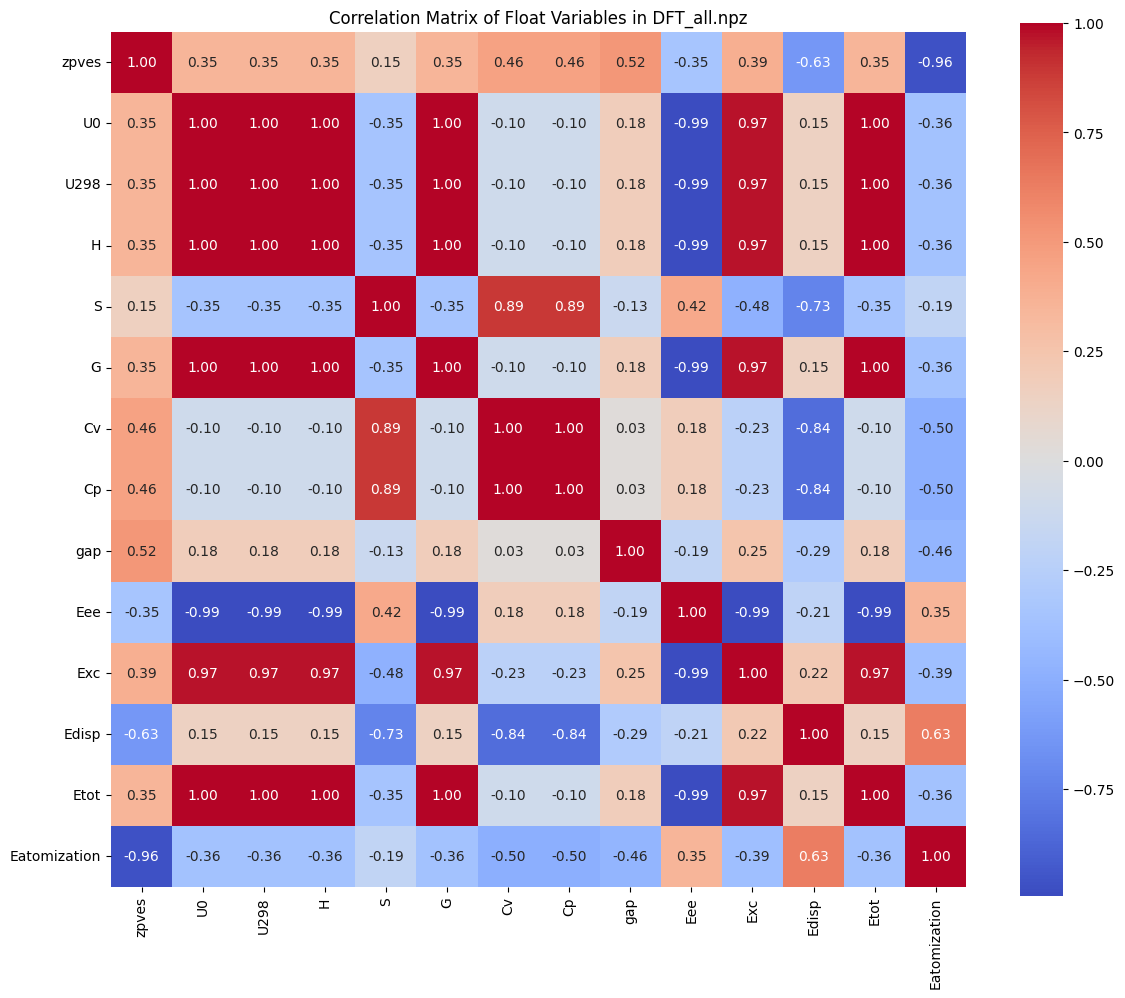

In [ ]:
# 相関行列の計算
corr_matrix = df.corr()

# ヒートマップの表示
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Float Variables in DFT_all.npz")
plt.tight_layout()
plt.show()

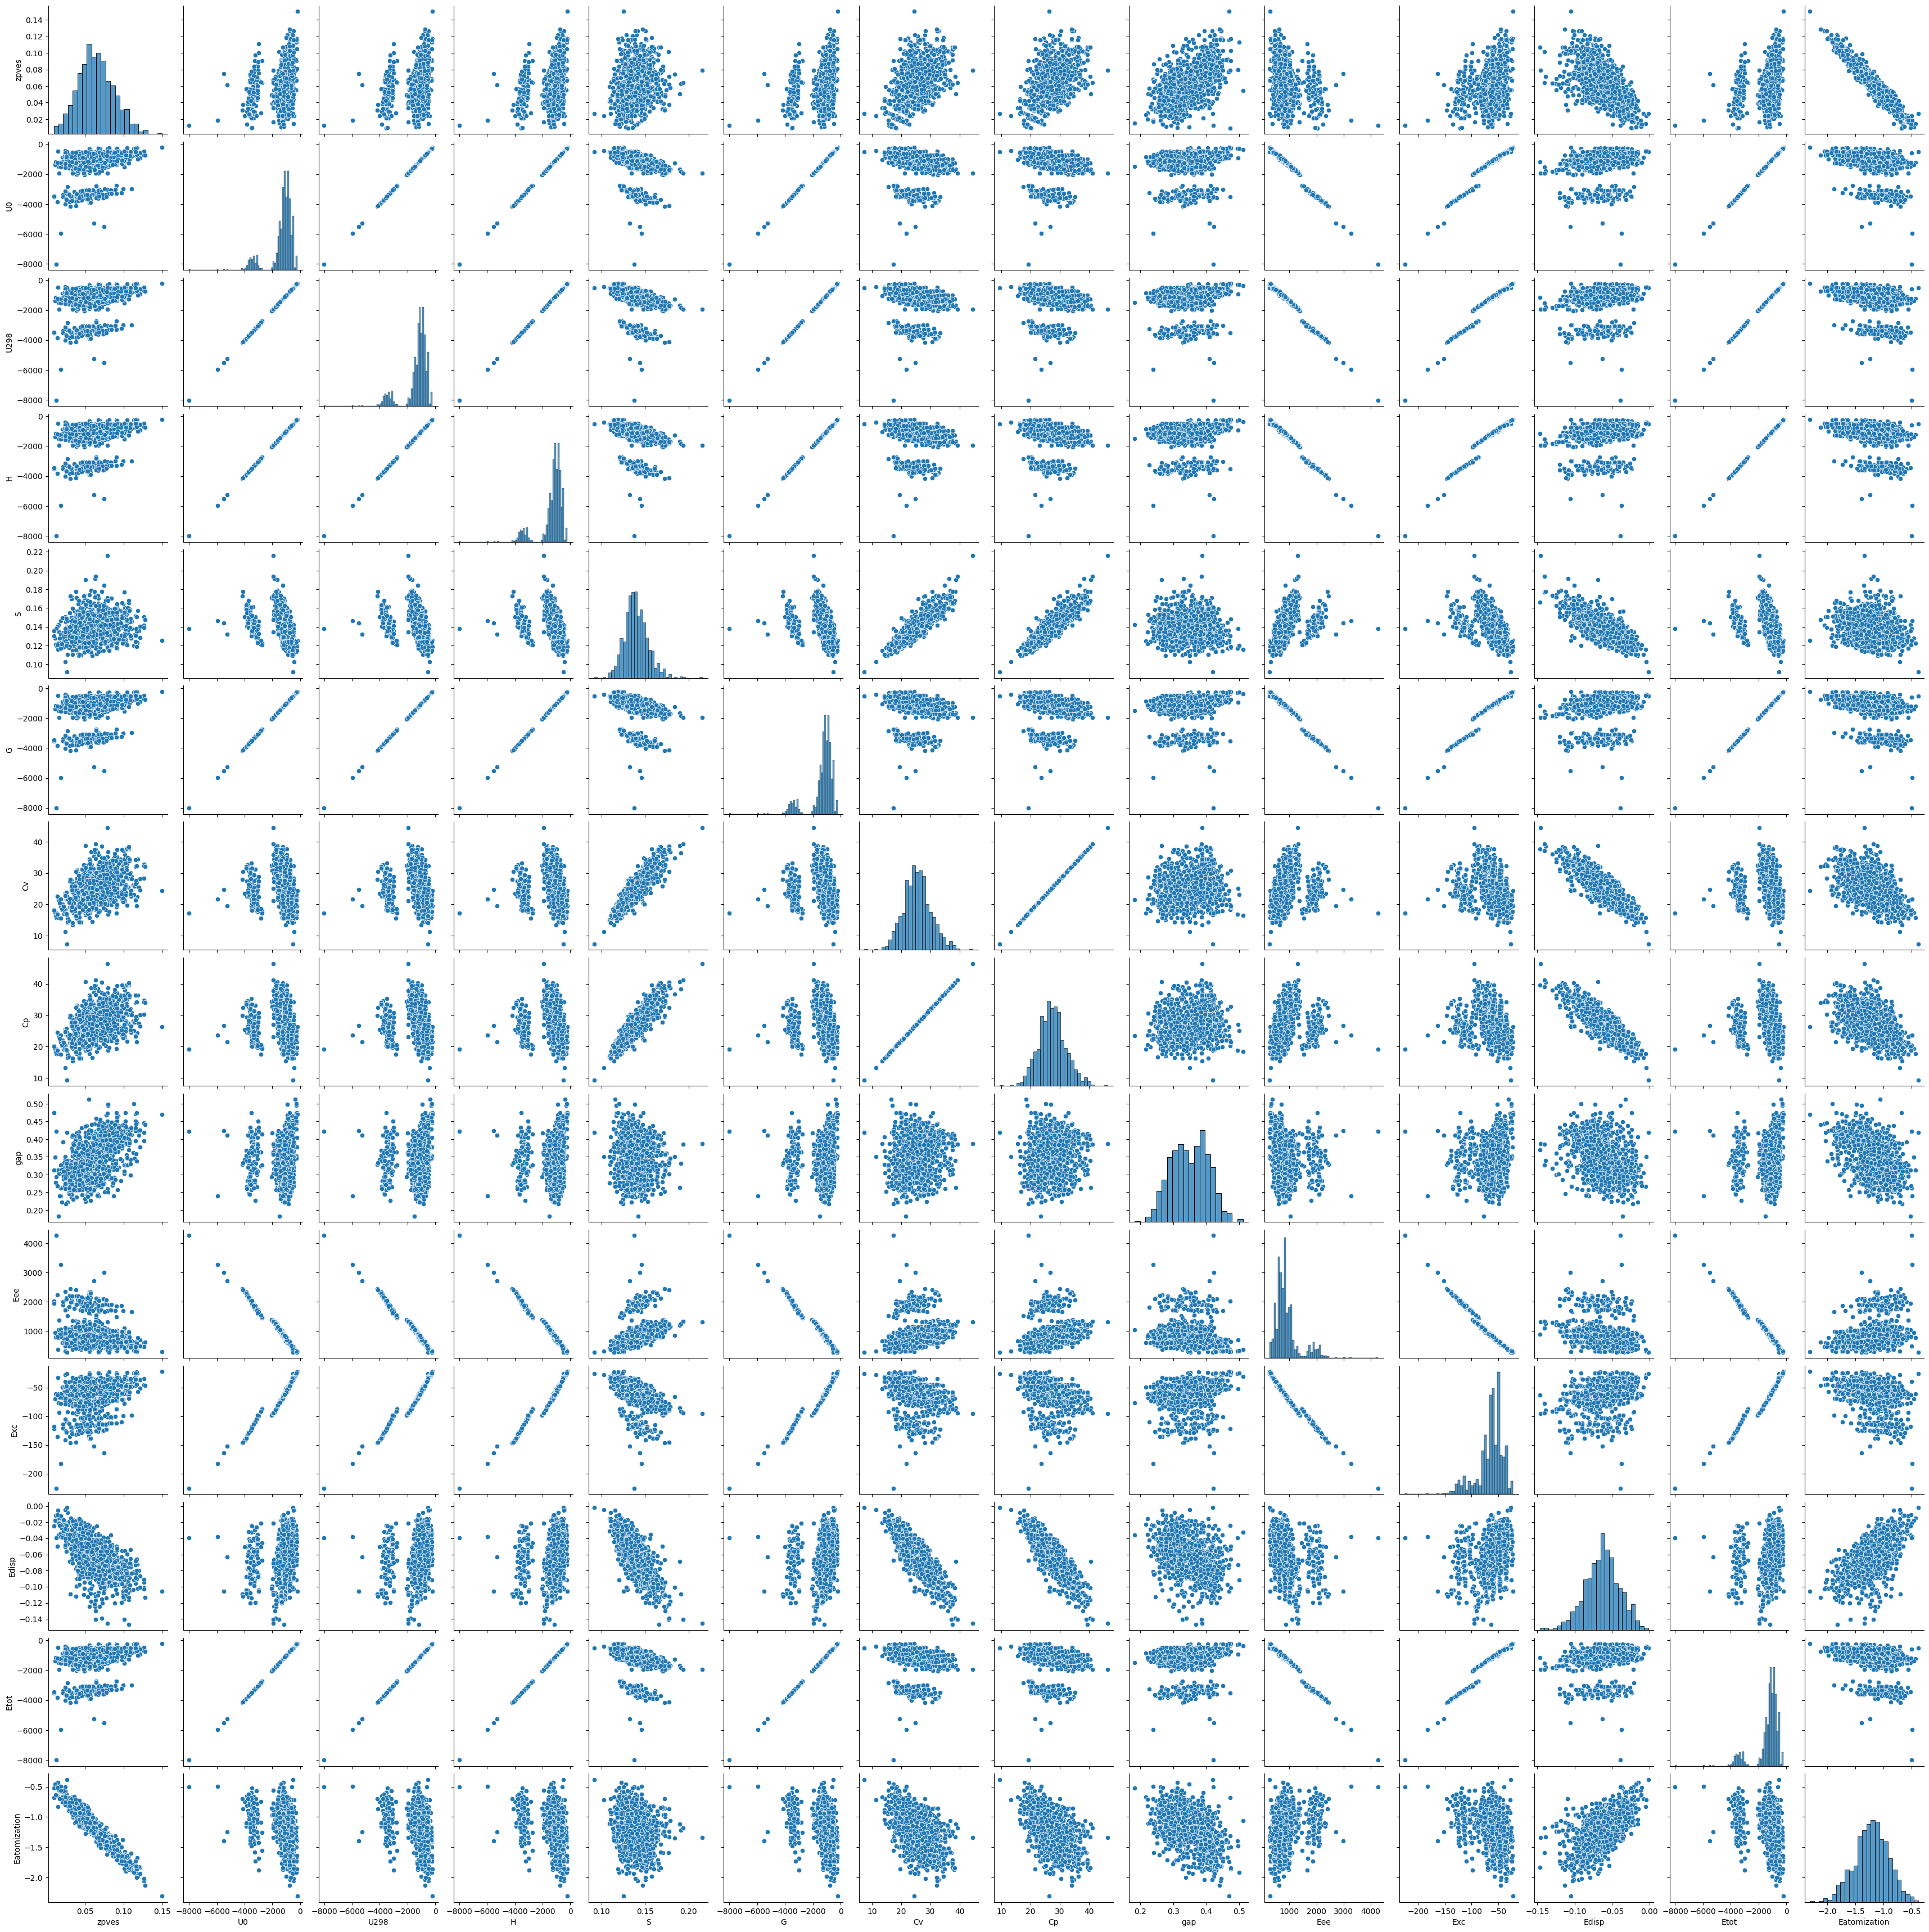

In [ ]:
# Select numeric columns only
num_cols = df.select_dtypes(include="number").columns

# Limit to 1000 samples as too many samples are heavy
sns.pairplot(df[num_cols].sample(1000, random_state=0))
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

Zs = data['atoms']             # atomic numbers (per molecule)
Rs = data['coordinates']       # 3D positions (per molecule)

In [ ]:
print(Zs[0])
#print(Rs[0:10])

[16  1  1]


In [ ]:
# 各サンプルについて、atomsリストのベクトル平均を計算
Zs_mean = [np.mean(np.array(vectors), axis=0) for vectors in Zs]

# リストを配列に変換
Zs_mean = np.array(Zs_mean)

print(Zs_mean)

[ 6.    18.     9.    ...  4.375  6.2    6.8  ]


In [ ]:
print("Zs_mean shape:", np.array(Zs_mean).shape)

Zs_mean shape: (784875,)


In [ ]:
Zs_mean = np.array(Zs_mean).reshape(-1, 1)  # 明示的に2次元にする
Zs_mean_df = pd.DataFrame(Zs_mean, columns=['Zs_mean_0'])

In [ ]:
{
 "cells": [
  {
   "cell_type": "code",
   "execution_count": 1,
   "id": "69cfa737-4254-4db9-a36c-cb25d927045f",
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "['compounds', 'atoms', 'freqs', 'vibmodes', 'zpves', 'U0', 'U298', 'H', 'S', 'G', 'Cv', 'Cp', 'coordinates', 'Vesp', 'Qmulliken', 'dipole', 'quadrupole', 'octupole', 'hexadecapole', 'rots', 'gap', 'Eee', 'Exc', 'Edisp', 'Etot', 'Eatomization']\n"
     ]
    }
   ],
   "source": [
    "import numpy as np\n",
    "\n",
    "# Load the dataset\n",
    "data = np.load('C:/Users/nchni/OneDrive/Desktop/M1/Material Informatics/datasets/DFT_all.npz', allow_pickle=True)\n",
    "\n",
    "# Inspect available keys\n",
    "print(data.files)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 3,
   "id": "1680d75d-56f5-4fc4-8a3c-44b0c16be8e1",
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "         gap        U0\n",
      "16 -0.157963 -0.165541\n",
      "1   0.407587  0.239875\n",
      "35 -0.041817 -0.926947\n",
      "17  0.031726 -0.070167\n",
      "14 -0.229477 -0.029565\n",
      "8   0.205795  0.156284\n",
      "9   0.126409  0.080524\n",
      "7   0.239145  0.248023\n",
      "6   0.102675  0.266658\n",
      "15 -0.159990 -0.070134\n"
     ]
    }
   ],
   "source": [
    "import pandas as pd\n",
    "from collections import Counter\n",
    "\n",
    "# Extract relevant data\n",
    "atoms = data['atoms']\n",
    "gaps = data['gap']\n",
    "U0 = data['U0']\n",
    "\n",
    "# Count atom types for each molecule\n",
    "atom_counts = [Counter(atom_list.astype(int)) for atom_list in atoms]\n",
    "\n",
    "# Create a DataFrame from atom counts\n",
    "df_atoms = pd.DataFrame(atom_counts).fillna(0).astype(int)\n",
    "\n",
    "# Add property columns\n",
    "df_atoms['gap'] = gaps\n",
    "df_atoms['U0'] = U0\n",
    "\n",
    "# Compute correlation matrix\n",
    "corr_matrix = df_atoms.corr()\n",
    "\n",
    "# Display correlation of atom types with 'gap' and 'U0'\n",
    "print(corr_matrix[['gap', 'U0']].drop(['gap', 'U0']))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 5,
   "id": "f507ef96-79d7-44bc-b8c0-5496d4e97195",
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAA5gAAAJOCAYAAADS2Kg7AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAACYHElEQVR4nOzdd3QU1fvH8c+mh5AEUulJ6L0qVUTpRREbKoqAiqIoCgqKiBQLol8LIoqNKiIqIIpIRwQp0pHee2iBFAKpe39/8GPNkk0gySZLeb/OmXPYO/fOPDObHfbuM/eOxRhjBAAAAABAHrm5OgAAAAAAwI2BDiYAAAAAwCnoYAIAAAAAnIIOJgAAAADAKehgAgAAAACcgg4mAAAAAMAp6GACAAAAAJyCDiYAAAAAwCnoYAIAAAAAnIIOJm4amzdvVo8ePRQVFSUfHx8VLlxYdevW1fvvv68zZ864Ojw7f/75pywWi/78888ct922bZuGDh2qAwcOZFrXvXt3RUZG5jm+nDpw4IAsFov+97//OW2bx44d09ChQ7Vx40anbfNadt9998lisej55593uH7OnDkaOnRowQZ1BZGRkbJYLFdcJkyY4OpQr0lXex2YMGGC3fn08PBQqVKl1KNHDx09erRggs0H2X3Ghw4dKovFUvBBSXriiSfUtm1bl+w7Ly79Pf38888O1z///PMOz+nChQvVqFEjFSpUSCEhIerevbtOnjxpV2fRokUqXLjwdf33BsB56GDipvD111+rXr16WrNmjfr376+5c+dq5syZevDBBzV27Fg9+eSTrg7RabZt26Zhw4Y57GAOHjxYM2fOLPig8sGxY8c0bNiwm6KDefLkSc2ePVuSNGXKFCUlJWWqM2fOHA0bNqygQ8vWzJkztXLlStty6XM2d+5cu/IOHTq4ONIbw/jx47Vy5UotWLBAPXv21NSpU9W0aVMlJia6OrRcye4z/tRTT2nlypUFHtOGDRs0ceJEvf322wW+b1dYunSp2rVrp/DwcM2aNUujRo3SwoUL1aJFCyUnJ9vqtWjRQvXr19frr7/uwmgBXCs8XB0AkN9WrlypZ599Vq1atdIvv/wib29v27pWrVrp5Zdf1ty5c52yr/Pnz6tQoUKZytPT05WWlma3b1coV66cS/eP3Jk0aZJSU1PVoUMH/f7775oxY4a6dOni6rCuqE6dOnavL33O6tWrp5CQEFeEdEOrXr26brnlFknSnXfeqfT0dL311lv65Zdf9Oijjzpsk9U1y5UuXS+zU6pUKZUqVaqAIvrPe++9p/r169vO842uf//+qlixon7++Wd5eFz8yhgVFaUmTZpo3LhxevbZZ211e/furYceekhvv/22Spcu7aqQAVwDyGDihvfuu+/KYrHoq6++ctjB8/LyUseOHW2vrVar3n//fVWuXFne3t4KCwvT448/riNHjti1u+OOO1S9enX99ddfaty4sQoVKqQnnnjCdjvo+++/r7fffltRUVHy9vbWkiVLJElr165Vx44dFRQUJB8fH9WpU0c//vjjFY9j7dq1evjhhxUZGSlfX19FRkbqkUce0cGDB211JkyYoAcffFDSxS+Yl9+C6OgW2aSkJA0cOFBRUVHy8vJSyZIl1bt3b8XGxtrVi4yM1F133aW5c+eqbt268vX1VeXKlTVu3Lgrxp7x3L7zzjsqU6aMfHx8dMstt2jRokWZ6u3evVtdunRRWFiYvL29VaVKFY0ZM8a2/s8//9Stt94qSerRo4ftOIcOHarff/9dFotFa9assdWfPn26LBZLpkxZzZo1df/999teG2P0+eefq3bt2vL19VXRokX1wAMPaN++fZlivPQrfkBAgAoVKqQmTZpkOpZLt/Ft3bpVjzzyiAIDAxUeHq4nnnhCcXFxV33exo0bp/DwcE2cOFG+vr6Zznn37t1t5yfjrZKXstg5fY9nz56tOnXqyNfXV1WqVLFlTydMmKAqVarIz89P9evX19q1a6/6GBx566235OHhocOHD2da98QTTyg4ONiWrb0U28yZM1WzZk35+PiobNmy+vTTTzO1jY+P1yuvvGJ3vC+99FKmTN5PP/2kBg0aKDAwUIUKFVLZsmX1xBNPXDHuMWPG6Pbbb1dYWJj8/PxUo0YNvf/++0pNTbWrd+kasWbNGjVt2tS2j/fee09Wq9Wu7o4dO9S2bVvbbYi9evVSQkLCFWPJTsOGDSXJdo3o3r27ChcurH///VetW7eWv7+/WrRoIUk6c+aMnnvuOZUsWVJeXl4qW7asBg0aZJelkmS7TfvLL79UxYoV5e3trapVq+qHH37ItP/jx4/rmWeeUalSpeTl5aWoqCgNGzbMrvOY3fUyq8+4lPUtstOmTVOjRo3k5+enwoULq02bNtqwYYNdnX379unhhx9WiRIl5O3trfDwcLVo0eKKd0OcOHFCM2fOVNeuXTOt27p1q1q3bq1ChQopNDRUvXv3tl2LMt7ivGDBAt1zzz0qVaqUfHx8VL58eT3zzDM6ffq03fYuHd+GDRt03333KSAgQIGBgXrsscd06tSpbON0lqNHj2rNmjXq2rWrrXMpSY0bN1bFihUz3Q1z9913q3Dhwvr6668LJD4A1zAD3MDS0tJMoUKFTIMGDa66zdNPP20kmeeff97MnTvXjB071oSGhprSpUubU6dO2eo1a9bMBAUFmdKlS5vRo0ebJUuWmKVLl5r9+/cbSaZkyZLmzjvvND///LOZP3++2b9/v1m8eLHx8vIyTZs2NdOmTTNz58413bt3N5LM+PHjbdtesmSJkWSWLFliK/vpp5/Mm2++aWbOnGmWLl1qfvjhB9OsWTMTGhpqi+vkyZPm3XffNZLMmDFjzMqVK83KlSvNyZMnjTHGdOvWzURERNi2abVaTZs2bYyHh4cZPHiwmT9/vvnf//5n/Pz8TJ06dUxSUpKtbkREhClVqpSpWrWqmTRpkpk3b5558MEHjSSzdOnSbM/ppXNSunRpc9ttt5np06ebn376ydx6663G09PTrFixwlZ369atJjAw0NSoUcNMmjTJzJ8/37z88svGzc3NDB061BhjTFxcnBk/fryRZN544w3bcR4+fNgkJCQYT09P8+6779q22atXL+Pr62v8/PxMSkqKMcaYEydOGIvFYj7//HNbvZ49expPT0/z8ssvm7lz55rvv//eVK5c2YSHh5vjx4/b6k2ePNlYLBbTqVMnM2PGDPPbb7+Zu+66y7i7u5uFCxfa6g0ZMsRIMpUqVTJvvvmmWbBggfnoo4+Mt7e36dGjR7bn7JK///7bSDL9+/c3xhjz2GOPGYvFYvbt22ers2fPHvPAAw8YSbZzsXLlSpOUlJSr97h69epm6tSpZs6cOaZBgwbG09PTvPnmm6ZJkyZmxowZZubMmaZixYomPDzcnD9//qqOI+P5uPT3euLECePt7W0GDRpkVy8mJsb4+vrajvlSbCVLljRlypQx48aNM3PmzDGPPvqokWQ++OADW73ExERTu3ZtExISYj766COzcOFCM2rUKBMYGGiaN29urFarMcaYFStWGIvFYh5++GEzZ84cs3jxYjN+/HjTtWvXKx5H3759zRdffGHmzp1rFi9ebD7++GMTEhKS6T1t1qyZCQ4ONhUqVDBjx441CxYsMM8995yRZCZOnGird/z4cRMWFmZKlixpxo8fbzu2MmXKZLoOOHLps7BmzRq78lGjRhlJ5quvvjLGXPz8e3p6msjISDNixAizaNEiM2/ePHPhwgVTs2ZN4+fnZ/73v/+Z+fPnm8GDBxsPDw/Tvn17u21e+hxXrVrVTJ061fz666+mbdu2RpL56aefbPWio6NN6dKlTUREhPnyyy/NwoULzVtvvWW8vb1N9+7dbfWyul5u2rQpy8+4Mf/9LWX0zjvvGIvFYp544gkze/ZsM2PGDNOoUSPj5+dntm7daqtXqVIlU758eTN58mSzdOlSM336dPPyyy9f8TxPmjTJSDLbtm2zKz927JgJDg42ZcqUMRMmTDBz5swxXbt2NZGRkZnevy+++MKMGDHC/Prrr2bp0qVm4sSJplatWqZSpUq2a1PG44uIiDD9+/c38+bNMx999JHtc5ux7tW69P9Kxvcpo969e9ud07lz5xpJ5vfff89U94EHHjDFixfPVN6uXTtTt27dHMcG4MZCBxM3tOPHjxtJ5uGHH76q+tu3bzeSzHPPPWdXvnr1aiPJvP7667ayZs2aGUlm0aJFdnUvfWEqV65cpi8BlStXNnXq1DGpqal25XfddZcpXry4SU9PN8Y47mBeLi0tzZw7d874+fmZUaNG2cp/+umnLNte3sG89AXi/ffft6s3bdo0uy+mxlz8gu/j42MOHjxoK7tw4YIJCgoyzzzzTJZxGvPfOSlRooS5cOGCrTw+Pt4EBQWZli1b2sratGljSpUqZeLi4uy28fzzzxsfHx9z5swZY4wxa9asydQxv+S2224zzZs3t70uX7686d+/v3Fzc7N1hqdMmWIkmV27dhljjFm5cqWRZD788EO7bR0+fNj4+vqaAQMGGGMudmCCgoLM3XffbVcvPT3d1KpVy9SvX99WdulL4uXn97nnnjM+Pj62zk52nnjiCSPJbN++3Rjz39/G4MGD7epd/uXwkpy+x76+vubIkSO2so0bNxpJpnjx4iYxMdFW/ssvvxhJ5tdff73iMVxyeQfTmIt/k2FhYSY5OdlWNnLkSOPm5mb2799vF5vFYjEbN26022arVq1MQECALbYRI0YYNze3TJ2tn3/+2Ugyc+bMMcYY87///c9IMrGxsVcdvyPp6ekmNTXVTJo0ybi7u9v+Po357xqxevVquzZVq1Y1bdq0sb1+9dVXszy2nHQwV61aZVJTU01CQoKZPXu2CQ0NNf7+/rYfR7p162YkmXHjxtm1Hzt2rJFkfvzxR7vykSNHGklm/vz5tjJJxtfX1+4Hl7S0NFO5cmVTvnx5W9kzzzxjChcubHe9MOa/836pw5fd9TK7z/jlHcxDhw4ZDw8P88ILL9jVS0hIMMWKFTOdO3c2xhhz+vRpI8l88sknjk9mNp599lnj6+ub6XPbv39/Y7FY7Dqxxly8lmX3/lmtVpOammoOHjxoJJlZs2ZlOr6+ffvatbl03fruu+9yHH9OO5iX9rVy5cpMdZ9++mnj5eWVqXzQoEHGzc3NnDt3LsfxAbhxcIsskMGl21i7d+9uV16/fn1VqVIl0y2QRYsWVfPmzR1uq2PHjvL09LS93rNnj3bs2GEbC5WWlmZb2rdvr+joaO3cuTPL2M6dO6dXX31V5cuXl4eHhzw8PFS4cGElJiZq+/btuTlcLV68WFLm433wwQfl5+eX6Xhr166tMmXK2F77+PioYsWKdrfpZue+++6Tj4+P7bW/v7/uvvtu/fXXX0pPT1dSUpIWLVqke++9V4UKFcp0jpKSkrRq1aor7qdFixb6+++/deHCBR08eFB79uzRww8/rNq1a2vBggWSLt7iWqZMGVWoUEGSNHv2bFksFj322GN2+y1WrJhq1aplu81txYoVOnPmjLp162ZXz2q1qm3btlqzZk2mWzEz3oItXbw1NykpKdNMjJc7d+6cfvzxRzVu3FiVK1eWJDVr1kzlypXThAkTMt1m6Uhu3uOSJUvaXlepUkXSxds9M47Vu1R+te99Vl588UWdPHlSP/30k6SLt1F/8cUX6tChQ6bbuatVq6ZatWrZlXXp0kXx8fFav369pIvvY/Xq1VW7dm2796dNmzZ2tyteuv2yc+fO+vHHH3M0++WGDRvUsWNHBQcHy93dXZ6ennr88ceVnp6uXbt22dUtVqyY6tevb1dWs2ZNu/O2ZMmSLI8tJxo2bChPT0/5+/vrrrvuUrFixfTHH38oPDzcrl7G28Kli38jfn5+euCBB+zKL/3NXP430qJFC7tturu766GHHtKePXtsQwlmz56tO++8UyVKlLB7H9q1ayfp4uQxGV1+vcypefPmKS0tTY8//rjd/nx8fNSsWTPb+x4UFKRy5crpgw8+0EcffaQNGzZc1edIujjpUGhoaKZbc5cuXarq1auratWqduWPPPJIpm2cPHlSvXr1UunSpeXh4SFPT09FRERIksPr+OVjZzt37iwPDw/b/1UFIavZeh2Vh4WFyWq16vjx4/kdFoBrGB1M3NBCQkJUqFAh7d+//6rqx8TESJKKFy+eaV2JEiVs6y9xVC+rdSdOnJAkvfLKK/L09LRbnnvuOUnKNA4noy5duuizzz7TU089pXnz5umff/7RmjVrFBoaqgsXLlzV8V0uJiZGHh4eCg0NtSu3WCwqVqxYpuMNDg7OtA1vb++r3n+xYsUclqWkpOjcuXOKiYlRWlqaRo8enekctW/fXlL25+iSli1bKjk5WcuXL9eCBQsUEhKiOnXqqGXLllq4cKGki1+aW7ZsaWtz4sQJGWMUHh6ead+rVq2y7ffS+/jAAw9kqjdy5EgZYzI99uby83ZpLPCVztu0adN07tw5de7cWbGxsYqNjVVcXJw6d+6sw4cP2zrL2cnpexwUFGT32svLK9tyRzPa5kSdOnXUtGlT2xjS2bNn68CBAw4fx5LV34/032f3xIkT2rx5c6b3xt/fX8YY2/t4++2365dffrF1SkqVKqXq1atr6tSp2cZ76NAhNW3aVEePHtWoUaO0bNkyrVmzxhb/5e/p1XxmYmJisj22qzVp0iStWbNGGzZs0LFjx7R582Y1adLErk6hQoUUEBBgV3Zp/5d3GMLCwuTh4ZHpb+Rq34fffvst0/tQrVo1SZk/x9ldS6/Gpc/lrbfemmmf06ZNs+3PYrFo0aJFatOmjd5//33VrVtXoaGh6tOnzxXHvF64cMHuB7JLYmJiMnXiJWUqs1qtat26tWbMmKEBAwZo0aJF+ueff2w/mjm6Hlx+rj08PBQcHJzpPbkal8ZRpqenO1yflpZmN9by0t+uo32dOXMm0zVBku385Pb/JAA3BmaRxQ3N3d1dLVq00B9//KEjR45ccdbBS/+hRkdHZ6p77NixTDNfZvcctsvXXWo7cOBA3XfffQ7bVKpUyWF5XFycZs+erSFDhui1116zlScnJ+fpGZ7BwcFKS0vTqVOn7DogxhgdP37cluVxFke/ah8/flxeXl4qXLiwPD095e7urq5du6p3794OtxEVFXXF/TRo0ECFCxfWwoULdeDAAbVo0UIWi0UtWrTQhx9+qDVr1ujQoUN2HcyQkBBZLBYtW7bM4WRQl8ouvY+jR4+2TaJyOUdfNnPj22+/lSS99NJLeumllxyub9OmTbbbKOj3ODf69OmjBx98UOvXr9dnn32mihUrqlWrVpnqZfX3I/332Q0JCXE4EdIlGT/D99xzj+655x4lJydr1apVGjFihLp06aLIyEg1atTIYftffvlFiYmJmjFjhi3zJClPj8sJDg7O9tiuVpUqVa44u6mja1ZwcLBWr14tY4zd+pMnTyotLS3Tde9q34eaNWvqnXfecRhHiRIlrhhXTlyK8eeff7Z7XxyJiIiwfbZ27dqlH3/8UUOHDlVKSorGjh2b7T4uZcozCg4OtnVwM7r8PG3ZskWbNm3ShAkT1K1bN1v5nj17stzn8ePH7e4oSEtLU0xMjMMfLq7k0nUpq2z90aNH7a5d1atXlyT9+++/th/4Lvn3339t6zO69P8Rs0QDNzcymLjhDRw4UMYY9ezZUykpKZnWp6am6rfffpMk2+2u3333nV2dNWvWaPv27bYZF3OjUqVKqlChgjZt2qRbbrnF4eLv7++wrcVikTEmU8fnm2++yfRr9NVmxyTZjufy450+fboSExPzdLyOzJgxwy7jlZCQoN9++01NmzaVu7u7ChUqpDvvvFMbNmxQzZo1HZ6jS1+ssjtOT09P3X777VqwYIEWL15s66w0bdpUHh4eeuONN2wdzkvuuusuGWN09OhRh/utUaOGJKlJkyYqUqSItm3bluX7eCm7lxfbt2/XypUrdf/992vJkiWZlhYtWmjWrFm27EJW56Og3+PcuPfee1WmTBm9/PLLWrhwoZ577jmHHY6tW7dq06ZNdmXff/+9/P39VbduXUkX38e9e/cqODjY4Xtz+W230sVz16xZM40cOVKSMs06mtGluDJ+Fo0xeZo5884778zy2ApCixYtdO7cOf3yyy925ZMmTbKtz2jRokV2Har09HRNmzZN5cqVs/0wd9ddd2nLli0qV66cw/fh8g6mIzm5lrVp00YeHh7au3dvlp9LRypWrKg33nhDNWrUcNh5zKhy5cqKiYnJNAN0s2bNtGXLFm3bts2u/PKZdR397UjSl19+meU+p0yZYvf6xx9/VFpamu64445sY3WkQoUKioiI0E8//SRjjN26U6dOacmSJXY/upUsWVL169fXd999Z/f/zKpVq7Rz506HP5Tu27dPwcHBTvuRDcD1iQwmbniNGjXSF198oeeee0716tXTs88+q2rVqik1NVUbNmzQV199perVq+vuu+9WpUqV9PTTT2v06NFyc3NTu3btdODAAQ0ePFilS5dW37598xTLl19+qXbt2qlNmzbq3r27SpYsqTNnzmj79u1av369bRza5QICAnT77bfrgw8+UEhIiCIjI7V06VJ9++23KlKkiF3dS78qf/XVV/L395ePj4+ioqIc/uLdqlUrtWnTRq+++qri4+PVpEkTbd68WUOGDFGdOnUcTsefF+7u7mrVqpX69esnq9WqkSNHKj4+XsOGDbPVGTVqlG677TY1bdpUzz77rCIjI5WQkKA9e/bot99+s40pLFeunHx9fTVlyhRVqVJFhQsXVokSJWxfXFu0aKGXX35Zkmxfmnx9fdW4cWPNnz9fNWvWVFhYmG2/TZo00dNPP60ePXpo7dq1uv322+Xn56fo6GgtX75cNWrU0LPPPqvChQtr9OjR6tatm86cOaMHHnhAYWFhOnXqlDZt2qRTp07piy++yPO5upRhGTBgQKYxfNLFzvmiRYv03Xff6cUXX7R1gEeOHKl27drJ3d1dNWvWLPD3ODfc3d3Vu3dvvfrqq/Lz88s0XvSSEiVKqGPHjho6dKiKFy+u7777TgsWLNDIkSNt40NfeuklTZ8+Xbfffrv69u2rmjVrymq16tChQ5o/f75efvllNWjQQG+++aaOHDmiFi1aqFSpUoqNjdWoUaPk6empZs2aZRlrq1at5OXlpUceeUQDBgxQUlKSvvjiC509ezbXx//SSy9p3Lhx6tChg95++22Fh4drypQp2rFjR663mROPP/64xowZo27duunAgQOqUaOGli9frnfffVft27e363RIF7NTzZs31+DBg+Xn56fPP/9cO3bssOtQDR8+XAsWLFDjxo3Vp08fVapUSUlJSTpw4IDmzJmjsWPHXvGOkit9xjOKjIzU8OHDNWjQIO3bt09t27ZV0aJFdeLECf3zzz/y8/PTsGHDtHnzZj3//PN68MEHVaFCBXl5eWnx4sXavHmz3d0hjtxxxx0yxmj16tVq3bq1rfzS+9euXTsNHz5c4eHh+v77723vn5vbxd/yK1eurHLlyum1116TMUZBQUH67bffsr3VfcaMGfLw8FCrVq20detWDR48WLVq1VLnzp1tdSZMmKAePXpo/PjxWX52Lvnf//6nzp07q0WLFurZs6eKFSum3bt367333pOXl5cGDx5sV3/kyJFq1aqVHnzwQT333HM6efKkXnvtNVWvXl09evTItP1Vq1apWbNmec5IA7jOuWRqIcAFNm7caLp162bKlCljvLy8bNO9v/nmm7bHeBhzcVbIkSNHmooVKxpPT08TEhJiHnvsMdv0+Jc0a9bMVKtWLdN+Ls2KmPHRCRlt2rTJdO7c2YSFhRlPT09TrFgx07x5czN27FhbHUezyB45csTcf//9pmjRosbf39+0bdvWbNmyxURERJhu3brZ7eOTTz4xUVFRxt3d3W4WxstnkTXm4kywr776qomIiDCenp6mePHi5tlnnzVnz561qxcREWE6dOiQ6XiaNWtmmjVr5vBYLz8nI0eONMOGDTOlSpUyXl5epk6dOmbevHkO6z/xxBOmZMmSxtPT04SGhprGjRubt99+267e1KlTTeXKlY2np6eRZIYMGWJbt2nTJiPJVKhQwa7NO++8YySZfv36OYx13LhxpkGDBsbPz8/4+vqacuXKmccff9ysXbvWrt7SpUtNhw4dTFBQkPH09DQlS5Y0HTp0sJuh0dGsqcb8N+tnxllSM0pJSTFhYWGmdu3aDtcbc3HmzlKlSpkaNWoYY4xJTk42Tz31lAkNDTUWi8Vu+3l9jyWZ3r1725Vd6e/ckazOhzHGHDhwwEgyvXr1ctj2Umw///yzqVatmvHy8jKRkZHmo48+ylT33Llz5o033jCVKlUyXl5etsfe9O3b1zb76ezZs027du1MyZIljZeXlwkLCzPt27c3y5Ytu+Jx/Pbbb6ZWrVrGx8fHlCxZ0vTv39/88ccfmT6zWV0jHH0Ot23bZlq1amV8fHxMUFCQefLJJ82sWbPy9JgSR/v18/NzuC4mJsb06tXLFC9e3Hh4eJiIiAgzcOBAu8fYGPPf38Lnn39uypUrZzw9PU3lypXNlClTMm3z1KlTpk+fPiYqKsp4enqaoKAgU69ePTNo0CDbLKNX+jvK6jPu6DElxlyc3fjOO+80AQEBxtvb20RERJgHHnjA9vigEydOmO7du5vKlSsbPz8/U7hwYVOzZk3z8ccfm7S0tGzPX3p6uomMjMw0y7gxxmzZssW0bNnS7v2bOHGikWQ2bdpkq3fpffb39zdFixY1Dz74oDl06FCm69el41u3bp25++67TeHChY2/v7955JFHzIkTJ+z2PXr0aCPJzJ07N9v4L1m4cKFp3bq1KVKkiPHw8DDFixc3jz32mNm9e7fD+vPnzzcNGza0Hdvjjz+eKQZjLj4uSZKZPn36VcUB4MZlMeay+yQAAChgo0ePVp8+fbRlyxbbRDAZRUZGqnr16po9e7YLosMlFotFvXv31meffebqUFziww8/1DvvvKOjR4/K19c327pPP/20pk6dqpiYmBzfNj906FANGzZMp06duuJ4xs6dO2v//v1as2ZNjvbhbIMHD9akSZO0d+9eu8mCANx8uAIAAFxmw4YN2r9/v4YPH6577rnHYecSuFZc6lyPGTNGr7zyiq18+PDhKlGihMqWLatz585p9uzZ+uabb/TGG284ZUx2Vowx+vPPPzONsS5osbGxGjNmjEaPHk3nEgAdTACA69x77706fvy4mjZtmu0MnsC1wMfHR5MnT840EZSnp6c++OADHTlyRGlpaapQoYI++ugjvfjii/kaj8ViueLzdAvC/v37NXDgwBw/uxXAjYlbZAEAAAAATsFjSgAAAAAATkEHEwAAAADgFHQwAQAAAABOQQcTAAAAAK4Tn3/+uaKiouTj46N69epp2bJlV9Xu77//loeHh2rXrp2v8d2Qk/yc3bTU1SEAAPLIWPgNFACud0E1m7o6hFz53bNSgeynQ+rOHNWfNm2aunbtqs8//1xNmjTRl19+qW+++Ubbtm1TmTJlsmwXFxenunXrqnz58jpx4oQ2btyYx8izxv/eAAAAAHAd+Oijj/Tkk0/qqaeeUpUqVfTJJ5+odOnS+uKLL7Jt98wzz6hLly5q1KhRvsdIBxMAAAAAMrB4WgpkSU5OVnx8vN2SnJzsMKaUlBStW7dOrVu3titv3bq1VqxYkeWxjB8/Xnv37tWQIUOceo6yQgcTAAAAAFxgxIgRCgwMtFtGjBjhsO7p06eVnp6u8PBwu/Lw8HAdP37cYZvdu3frtdde05QpU+Th4eH0+B0pmL0AAAAAwHXCzcNSIPsZOHCg+vXrZ1fm7e2dbRuLxT42Y0ymMklKT09Xly5dNGzYMFWsWDHvwV4lOpgAAAAA4ALe3t5X7FBeEhISInd390zZypMnT2bKakpSQkKC1q5dqw0bNuj555+XJFmtVhlj5OHhofnz56t58+Z5P4jL0MEEAAAAgAwsntfeSEIvLy/Vq1dPCxYs0L333msrX7Bgge65555M9QMCAvTvv//alX3++edavHixfv75Z0VFReVLnHQwAQAAAOA60K9fP3Xt2lW33HKLGjVqpK+++kqHDh1Sr169JF285fbo0aOaNGmS3NzcVL16dbv2YWFh8vHxyVTuTHQwAQAAAOA68NBDDykmJkbDhw9XdHS0qlevrjlz5igiIkKSFB0drUOHDrk0Rosxxrg0gnxwdtNSV4cAAMgjY7n2bk8CAORMUM2mrg4hVxaE51+GL6NWJ7YUyH4KEv97AwAAAACcgltkAQAAACADi2fBPKbkRkQGEwAAAADgFGQwAQAAACADNw8ymLlFBhMAAAAA4BRkMAEAAAAgA8Zg5h4ZTAAAAACAU5DBBAAAAIAMGIOZe2QwAQAAAABOQQYTAAAAADKwuJPBzC0ymAAAAAAApyCDCVwDjDH65qffNGvRMiWcO6+qFaLU/8kuKlu6RJZt9h0+pq+mzdKO/Yd0/FSMXurWWQ93aJmp3skzZzXmuxlauXGLklNSVKZ4uAY9202Vy0bk5yEBwE3HGKNvf/pVsxb+pfhz51WtQpReeepRlS1dMss2+w4f1dfTZmnHvoM6fipGL3Z/SA93aGVX597nXtXxUzGZ2t7X5k71f+pRpx8HAMmNDGauubSDeeTIEfn4+CgkJESStGzZMo0dO1aHDh1SRESEevfurUaNGrkyRKBATJ41T1N/X6jBz3VXmeLhGj/jd/V5+2NN++Qt+fn6OGyTlJyikuGhatGonj6Z+KPDOvHnEvX04PdVr1olffx6HxUN8NfRE6dUuJBvfh4OANyUvps1V1NnL9Dg3j1UungxTZg+Wy++9ZF+GPVOttfyEmGhat7oFo2aMM1hnXEj3pDVarW93nv4qF586yO1aFQvX44DAPLCpbfIdu7cWWvWrJEkzZo1S3fccYfOnTunJk2a6Pz582rWrJlmz57tyhCBfGeM0bQ5C9X93va6s0FdlStTUm/27qGk5BTNX746y3ZVy0fqha4PqFWT+vL09HRYZ/KseQoPLqrBz3VXtfJRKhEWoltrVFGpYmH5dTgAcFMyxmja7wvV/b4OuqNBPZUrU1KDn3/iKq7lUXrh8Qf//1ru+Hf/ooH+Ci4aaFv+XrdZJcNDVadqpfw6HOCmZ3GzFMhyI3JpBnPLli2qUqWKJGnEiBF699139eqrr9rWf/bZZ3rzzTd11113uSpEIN8dO3laMbHxalCrqq3My9NTdapW1L879+neVs1yve1lazepYa2qev2jsdqwbbdCg4rovtZ3qFPLps4IHQDw/y5ey+NUv1Y1W9nFa3kl/btzT56u5RmlpqZp3rJVeviuVrJYbswvpwCuby7NYLq5uSk+Pl6StH//frVr185ufbt27bRz505XhAYUmJjYi5+BoMAAu/KgwADFxMXladvHTp7SjAVLVbpYuD4Z9KLubXW7Ph7/g+YsXZmn7QIA7MXEXrxeO7qWn/n/67wzLF2zQecSz6vDHU2ctk0AmVnc3QpkuRG5NIPZrFkzTZ06VTVr1lSdOnX0559/qmbNmrb1S5YsUcmSWQ+Ml6Tk5GQlJyfbl6WkyNvLK19iBvJq7rLVGvnVd7bXHw58XpJ0+Q/RxhhZlLdfp61WoyrlIvRsl3slSZWiymjf4WjNmL9U7ZsxvhkAcmveslUa+eVk2+v/DewjycG1XMap+529eLka1qmu0KAiTt0uADiLSzuY7733npo2bapjx47ptttu06BBg7RmzRpVqVJFO3fu1LRp0zR27NhstzFixAgNGzbMrmzAM9302rM98jN0INea3lJL1SpE2V6npqZJupjJDClaxFZ+Nj4h0y/hORVSNFCRpexnoo0sVUx/rl6fp+0CwM3utltqq2r5DNfytCyu5XEJCiqSt2v5JdGnYrRm8zaN6P+cU7YHIGvMIpt7Lu1gVqlSRatXr9Ybb7yh999/X4mJiZoyZYo8PDx066236ocfflCnTp2y3cbAgQPVr18/u7LzO7MeTA+4mp+vj91sgsYYBRcJ0D+bt6lSVBlJF7+obNi2S70fvS9P+6pZqbwOHTtuV3b42AkVCw3K03YB4Gbn+FoeqDWbt/53LU9N04ZtO/XcYw84ZZ+/L1muooEBaly35pUrA4CLuPw5mOXKldPUqVNljNHJkydltVoVEhKS5ayYl/P29pa3t7ddWTq3x+I6YrFY9FD7lpo48w+VLh6u0sXCNHHmH/Lx9lLr2xrY6g37bJxCg4rouS4XO52paWnafyRakpSWlqZTZ2K168Bh+fp4q/T/zxL7cIeW6jn4PU2YMUctGt+ibXv265dFy/Ta010L/kAB4AZmsVj0UIeWmjhjjkoVC1fp4uGaOOP3zNfy0d9evJY/er+ki53Q/UeOSfr/a3lMrHbtP3TxWl483NbOarXq9yV/q32zRvJwdy/YgwNuQjfqDK8FweUdzEssFovCw8Ptyg4fPqwhQ4Zo3LhxLooKKBhd72mj5JQUffDNFCUknle18lEaNeglu1/Hj58+Yzdj4KkzsXp8wFu211N+m68pv81XnaoV9cXQVyRdfJTJyFee0xffz9C46bNVPCxEL3V7SG2b/vdlBwDgHI/d01bJKSn63zdTlJCYqKrly+qTN/rZXctPnI6RW4Zr+emzseo2YLjt9fe/zdP3v81TnaoV9fmwAbbyNf9u1/HTZ3RX89sK5mAAIJcsxhjnjj53ok2bNqlu3bpKT0/PUbuzm5bmU0QAgIJiLDfm7HoAcDMJqnl9PhptzW0NC2Q/ty5fVSD7KUguzWD++uuv2a7ft29fAUUCAAAAAMgrl3YwO3XqJIvFouySqDxEGAAAAEBBsjCLbK659P6j4sWLa/r06bJarQ6X9et5lAIAAAAAXC9c2sGsV69etp3IK2U3AQAAAMDZLG5uBbLciFx6i2z//v2VmJiY5fry5ctryZIlBRgRAAAAACC3XNrBbNo0+1ml/Pz81KxZswKKBgAAAAB4DmZe3Jh5WQAAAABAgXNpBhMAAAAArjVuzCKba2QwAQAAAABOQQYTAAAAADJgDGbukcEEAAAAADgFGUwAAAAAyOBGfUZlQeDMAQAAAACcgg4mAAAAAMApuEUWAAAAADJgkp/cI4MJAAAAAHAKMpgAAAAAkIGbOxnM3CKDCQAAAABwCjKYAAAAAJABYzBzjwwmAAAAAMApyGACAAAAQAYWN/JwuXVDdjBX3PK0q0MAAORR1a6VXB0CACCPgsY1dXUIKGA3ZAcTAAAAAHKLMZi5R+4XAAAAAOAUZDABAAAAIAMymLlHBhMAAAAA4BRkMAEAAAAgAzKYuUcGEwAAAADgFGQwAQAAACADnoOZe5w5AAAAAIBTkMEEAAAAgAzc3BmDmVtkMAEAAAAATkEGEwAAAAAyYBbZ3CODCQAAAABwCjKYAAAAAJABs8jmHmcOAAAAAOAUZDABAAAAIAPGYOYeGUwAAAAAgFOQwQQAAACADMhg5h4ZTAAAAACAU5DBBAAAAIAMmEU29+hgAteAiF5dVLbfk/IuHqpz23Zra793dfbvdVdsV7RxXTVcNFkJW3dr+S2dbOWFq5ZXxSF9FFi3mgpFltLWl9/VgU8n5uMRAAD872ynwLb3yb1IUaUePaSYqd8oefc2h3UL1W2kgDvbyatMlCwenko5ekixs6bqwtYNDuv71W+qsF79lbh+lU5+9m5+HgYA5Aldc8DFij/YTlU/HKg9732h5bd20pnl61R/9tfyKV0823YeAYVVa9xIxSxemWmdeyFfnd9/RDsGfaik6JP5FToA4P/53Xqbgh95SrGzf9SxoS8pafc2Fes7RO5BIQ7r+1SqpgtbN+r4x8N0dFhfJe34V+EvviGvMmUz1fUIDlVQ5x5K2rk1vw8DwP+zuFkKZLkR0cEEXCzqpR46PH66Do/7Wed27NO2l99V0uHjinjmkWzb1fh8uI79MFtnV23MtC5u7b/a8dr7iv5xjqzJKfkUOQDgkoA29yhh2UKdW7ZAqdFHdGbqN0o7c1oBd7Z3WP/M1G8UN3eGUg7sUdrJaJ2dMVmpJ6JVqNat9hUtbgp9+mWdnTVVqaeOF8CRAEDe0MEEXMji6anAutV0asFyu/JTC/9W0UZ1smxXqtt9KlSujHa/9Vl+hwgAuBJ3D3lHlM90e+uFrRvkXb7y1W3DYpGbj6/SE8/ZFRfp+JDSE+J0btkCZ0UL4CpY3NwKZLkRMQYTcCGvkKJy8/BQyskYu/LkE6flHR7qsE2h8hGq/M7LWnnnozLp6QURJgAgG+7+AbK4uys9LtauPD0+Tu6BRa5qG4FtOsni7a3ENf/94Ohdvor8m7bS0aEvOjFaAMhf13S3+fDhw3riiSeyrZOcnKz4+Hi7JdVYCyhCwDmMMXavLRaLdFmZJMnNTXUmf6hdw0crcfeBggkOAHCVLrtuWzIXOeLX4HYVuecRnRz7gawJcReb+vgqtGc/nZ74maznEpwfKoDsWSwFs+TC559/rqioKPn4+KhevXpatmxZlnVnzJihVq1aKTQ0VAEBAWrUqJHmzZuX27NyVa7pDuaZM2c0cWL2M1+OGDFCgYGBdsuP1jMFFCGQNymnz8qalibvcPtJILzCgpV88nSm+h7+fipySw1VGzVY7S5sVbsLW1Xhjd4KrFVF7S5sVfAdDQsqdADA/0tPiJdJT5d7YFG7cnf/QKXHx2bb1u/W2xTS/QWd/OJ9JW3bZCv3DC0mz9BwhfcZrMivZyry65kq3PhOFapdX5Ffz5RHaLH8OBQA17hp06bppZde0qBBg7RhwwY1bdpU7dq106FDhxzW/+uvv9SqVSvNmTNH69at05133qm7775bGzY4nrHaGVx6i+yvv/6a7fp9+/ZdcRsDBw5Uv3797MoWB9XLU1xAQTGpqYpbv1WhLZvoxKyFtvKQFo114rdFmeqnxZ/T0tp32ZVF9uqi4Dsaat3DfXRh/5F8jxkAcJn0NCUf3CPfqrV1fv0qW7Fvtdo6v+GfLJv5NbhdIT1e0Kkv/6cLm9farUuNPqIjg5+3Kyt672Ny8/FVzNSvlXYm84+QAJznWp3h9aOPPtKTTz6pp556SpL0ySefaN68efriiy80YsSITPU/+eQTu9fvvvuuZs2apd9++0116mQ930deuLSD2alTJ1kslky3B2ZkuULq2NvbW97e3nZlnpZrOjEL2Nn/yXjVnvC+YtdtUeyqDSr91EPyLVNch776QZJU6e1+8ikZrk09XpWM0bmtu+3aJ5+MUXpysl25xdNT/lXLSZLcvLzkUyJcAbUqK+3ceZ3f6/gXLgBA7sXPm6XQnn2VfGCPkvfukH+zNvIIClXCn39Ikore/7jciwbp9DefSLrYuQx98iXFTP1ayXt3yj2giCTJmpoic+G8TFqqUo/aX6+t5xMlKVM5gOtXcnKykpOT7coc9W8kKSUlRevWrdNrr71mV966dWutWLHiqvZntVqVkJCgoKCg3Ad9BS7tYBYvXlxjxoxRp06dHK7fuHGj6tUjG4kbW/RPf8gruKgqDHpO3sXDdG7rLq25+2ldOHRMkuRdPFS+V3gm5uV8SoSp6dpZttflXn5S5V5+UjFLV2tVy8edGj8AQEpcs1xuhf1VpOND8ggMUsrRgzrxyXClxZySJLkHFpVH0H+Tt/k3ayOLh4dCuj4rdX3WVp6wfJFOjxtV4PEDcI0RI0Zo2LBhdmVDhgzR0KFDM9U9ffq00tPTFR4eblceHh6u48ev7jFGH374oRITE9W5c+dcx3wlFpNd+jCfdezYUbVr19bw4cMdrt+0aZPq1KkjqzVnk/b87lnJGeEBAFyoaleu5QBwvYsal/2QuGvVsb7ZP4/cWYLfm3DVGcxjx46pZMmSWrFihRo1amQrf+eddzR58mTt2LEj231NnTpVTz31lGbNmqWWLVs65wAccGkGs3///kpMTMxyffny5bVkyZICjAgAAAAACkZWnUlHQkJC5O7unilbefLkyUxZzctNmzZNTz75pH766ad87VxKLu5gNm3aNNv1fn5+atasWQFFAwAAAADX5iQ/Xl5eqlevnhYsWKB7773XVr5gwQLdc889WbabOnWqnnjiCU2dOlUdOnTI9zhd2sEEAAAAAFydfv36qWvXrrrlllvUqFEjffXVVzp06JB69eol6eITNo4ePapJkyZJuti5fPzxxzVq1Cg1bNjQlv309fVVYGBgvsRIBxMAAAAAMrC4XZtPpXjooYcUExOj4cOHKzo6WtWrV9ecOXMUEREhSYqOjrZ7JuaXX36ptLQ09e7dW71797aVd+vWTRMmTMiXGF06yU9+YZIfALj+MckPAFz/rtdJfo73f6xA9lPsg+8KZD8FiQwmAAAAAGRwLY7BvF5cm7lfAAAAAMB1hwwmAAAAAGRABjP3yGACAAAAAJyCDCYAAAAAZHSNziJ7PeDMAQAAAACcggwmAAAAAGRgsTAGM7fIYAIAAAAAnIIMJgAAAABkYGEMZq5x5gAAAAAATkEGEwAAAAAy4DmYuUcGEwAAAADgFGQwAQAAACAjxmDmGmcOAAAAAOAUZDABAAAAIAPGYOYeGUwAAAAAgFOQwQQAAACADCwW8nC5dUN2MFv8/pqrQwAA5FHL0WVdHQIAII+WuzoAFLgbsoMJAAAAALnGGMxcI/cLAAAAAHAKMpgAAAAAkIGF52DmGmcOAAAAAOAUZDABAAAAIAOeg5l7ZDABAAAAAE5BBhMAAAAAMuI5mLnGmQMAAAAAOAUZTAAAAADIgDGYuUcGEwAAAADgFGQwAQAAACAjnoOZa5w5AAAAAIBTkMEEAAAAgAwsFsZg5hYZTAAAAACAU9DBBAAAAAA4BbfIAgAAAEBGTPKTa5w5AAAAAIBTkMEEAAAAgAwsbkzyk1tkMAEAAAAATkEGE7gGGGM09o/lmv73JsVfSFKNiOIa2Lm1yhcPzbbdwo07NOb3ZTp8OlalQ4ro+btuV4talRzW/Xb+Sn3621I9esctGnB/y/w4DAC46T3xSIQ6tiku/8Ie2rYrQR+N3a39h85nWd/d3aKuD5ZRu+bhCgn21uGj5/XFhH1avf6srU6ndsXVqV0JFQ/3kSTtP3ReE344qFXrzuT78QA3LQt5uNy6ps5camqqfvnlF33wwQf67rvvlJiY6OqQgAIxfuFqTV6yRq892EpTXumm4IDC6vXZNCUmJWfZZtP+oxowfpbuurW6fnr1Cd11a3UNGDdLmw8cy1R3y8Fo/fz3RlUskX2HFQCQe4/eX1oPdSqlj77co6f6rVfM2RR9PLymfH3ds2zz9GORuqdtcX385R51fW6NfvnjmN59vZoqlC1sq3PqdIrGTtyvp/qu11N912v95rMaMaiaosoUKojDAoAccWkHs3HjxoqNjZUknTp1SvXq1dNDDz2kr7/+Wj179lTVqlV19OhRV4YI5DtjjKb8uUZPtW6slrUrqUKJUL39WAclpaZqztptWbb7bskaNawUpSdbN1JUsWA92bqR6leK0JQla+zqnU9O0cCJv2rII+0UUMgnvw8HAG5aD3YsqUk/HtJfK09r/6HzeufjHfL2dlfrZmFZtmlzZ7gm/3hIq9ad0bETSfrlj2it3nBWD3cqZavz95oYrVp3RoePXdDhYxf01eQDupCUrqqVAgrisICbk5ulYJYbkEs7mKtWrVJKSookadCgQXJ3d9fBgwe1a9cuHTlyRKVKldKbb77pyhCBfHc0Jk6n4xPVqHKkrczL00P1ypfWpv1Z/8Cy+cAxuzaS1LhyVKY27/44X7dXK6eGl9UFADhPiXAfhQR5658N/93amppmtHFLrKpXzroj6OnppuRUq11ZSrJVNasGOqzv5ia1aBoqHx93bd0R75zgAcCJrpkxmEuXLtVHH32kYsWKSZKCg4P1zjvvqEePHi6ODMhfp+PPSZKCA/zsyoP9/XTsTNZfHk7Hn8vcJsBPpxP+u7X8j3XbtP3wCX3fv5sTIwYAXC6oqJck6Uxsil352dgUhYdlfffIPxvO6OFOpbRpS5yOHr+gerWK6raGwXK7LLNRNsJPYz+oIy8vN124kK7X39mqA4ezHtsJIG8sjMHMNZd3MC2WixfQ2NhYRUVF2a2LiopSdHR0tu2Tk5OVnGw/Ts2kpMrby9O5gQJO8vuarXrrh7m215/1elCSZJH9lwljJMsV7pxw2Ob//338bLzen75QY597SN6eLv+oA8ANpVWzMPXvXdH2esDwfy/+w1xW0WLJXJbBqK/2asALFTXli1tlJB2LvqA5C4+rfctidvUOHT2vHi+uVWE/D93ROFSD+lbSCwM30ckEcM1x+bfO7t27y9vbW6mpqTp48KCqVq1qWxcdHa0iRYpk237EiBEaNmyYXdmgxzrqja6d8iFaIO/uqFFeNSKfsL1OSUuTdDEjGRr436QOZ84lKtjfL1P7S0ICCtuyn7Y2Cf+12XbouM4knNcjH0ywrU+3Gq3be1g//LVOaz7uL3c3fp0DgNxY/k+Mtu1aa3vt5XnxehpU1EsxZ//LYhYN9MyU1cwoNj5Vr7+zVV6eFgX4e+r0mRQ92y1K0SeS7OqlpRkdjb5YtnPPOVWp4K8HO5bUB2N2O/OwAFxyg46PLAgu7WB26/bfbXv33HOPzp2z/7I8ffp01a5dO9ttDBw4UP369bMrM3/94LQYAWfz8/GWn4+37bUxRiEBflq184CqlL74i3VqWrrW7TmsFzvekeV2akaW0KqdB9S1eX1b2codB1QrqqQkqUGlCP088Em7NkOm/K7I8GD1aNmQziUA5MGFC+k6eiHdruz0mWTdWruodu+7+H3Gw8Oi2tWLaOzEfVfcXkqq0ekzKXJ3t6hZ41AtXn4q+waWi+M3AeBa49IO5vjx47NdP3ToULm7Zz21tyR5e3vL29vbriyJ22NxHbFYLHr0jlv17fyVKhNaVGVCg/Tt/JXy8fRU+1v+y+gPmvSbwor42zqdj95xi54YNUXjFqzSnTUqaMm/u7V65wGN7/uYpIsd2QqXPZbE18tTRfx8M5UDAPLup1+PquuDZXTk2HkdPnZBj3cuo+TkdM1fetJW542+lXQqJkVfTtovSapa0V8hwd7as++cQoK99USXCLm5Sd/POGRr83TXKK1ad0YnTyepkK+HWt4eqjrVi+jlof8W+DECNwsLP8Tnmstvkd2+fbtWrVqlxo0bq1KlStqxY4dGjRql5ORkPfbYY2revLmrQwTyXY+WDZScmqp3f5yv+PNJqhFZQl/0fsgu03n8bLzcMgzKrF22lEZ2v0efzf5LY37/S6VDimpkj3tUM7KEKw4BAG56U6YflreXm/o9W0H+hT21bVe8+r65WRcyZDrDQ31kzTAm08vLTT0fi1SJYr66kJSuVWtj9NZHO3Qu8b82QUU8NbhfZQUHeSkxMU17DyTq5aH/au3GswKAa43FGJPN0PP8NXfuXN1zzz0qXLiwzp8/r5kzZ+rxxx9XrVq1ZIzR0qVLNW/evBx3MpPmZ58ZBQBc+1qOLuvqEAAAebT8t2auDiFXzo8bUiD7KfTEsCtXus64NPc7fPhw9e/fXzExMRo/fry6dOminj17asGCBVq4cKEGDBig9957z5UhAgAAAACukks7mFu3blX37t0lSZ07d1ZCQoLuv/9+2/pHHnlEmzdvdlF0AAAAAG5Kbm4Fs9yArpmjcnNzk4+Pj91jSfz9/RUXF+e6oAAAAAAAV82lHczIyEjt2bPH9nrlypUqU6aM7fXhw4dVvHhxV4QGAAAA4GZlsRTMcgNy6Syyzz77rNLT/5slrXr16nbr//jjD2aRBQAAAIDrhEs7mL169cp2/TvvvFNAkQAAAADARTwHM/c4cwAAAAAAp3BpBhMAAAAArjkW8nC5xZkDAAAAADgFGUwAAAAAyMjtxpzhtSCQwQQAAAAAOAUZTAAAAADIwMIYzFzjzAEAAAAAnIIMJgAAAABkxBjMXCODCQAAAABwCjKYAAAAAJARYzBzjTMHAAAAAHAKMpgAAAAAkJGFMZi5RQYTAAAAAOAUdDABAAAAICM3t4JZcuHzzz9XVFSUfHx8VK9ePS1btizb+kuXLlW9evXk4+OjsmXLauzYsbna79WigwkAAAAA14Fp06bppZde0qBBg7RhwwY1bdpU7dq106FDhxzW379/v9q3b6+mTZtqw4YNev3119WnTx9Nnz4932K0GGNMvm3dRZKmjnR1CACAPDLFy7g6BABAHvne8YirQ8iVpOkfF8h+fO7vm6P6DRo0UN26dfXFF1/YyqpUqaJOnTppxIgRmeq/+uqr+vXXX7V9+3ZbWa9evbRp0yatXLky94FngwwmAAAAAGRkcSuYJQdSUlK0bt06tW7d2q68devWWrFihcM2K1euzFS/TZs2Wrt2rVJTU3N2Tq4Ss8gCAAAAgAskJycrOTnZrszb21ve3t6Z6p4+fVrp6ekKDw+3Kw8PD9fx48cdbv/48eMO66elpen06dMqXrx4Ho8gMzKYAAAAAJCRm6VAlhEjRigwMNBucXSra0aWyx6hYozJVHal+o7KnYUMJgAAAAC4wMCBA9WvXz+7MkfZS0kKCQmRu7t7pmzlyZMnM2UpLylWrJjD+h4eHgoODs5D5FkjgwkAAAAAGRXQGExvb28FBATYLVl1ML28vFSvXj0tWLDArnzBggVq3LixwzaNGjXKVH/+/Pm65ZZb5Onp6ZxzdRk6mAAAAABwHejXr5+++eYbjRs3Ttu3b1ffvn116NAh9erVS9LFjOjjjz9uq9+rVy8dPHhQ/fr10/bt2zVu3Dh9++23euWVV/ItRm6RBQAAAICM8ml8Yl499NBDiomJ0fDhwxUdHa3q1atrzpw5ioiIkCRFR0fbPRMzKipKc+bMUd++fTVmzBiVKFFCn376qe6///58i5HnYAIArkk8BxMArn/X7XMwfx1TIPvx6di7QPZTkMhgAgAAAEBGbowkzC3OHAAAAADAKchgAgAAAEBG1+gYzOsBGUwAAAAAgFOQwQQAAACAjCzk4XKLMwcAAAAAcAoymAAAAACQEbPI5hpnDgAAAADgFGQwAQAAACAjZpHNNTKYAAAAAACnIIMJAAAAABkxi2yu0cEErgHT/tmuCSv+1emECyoXVkQD2jZQ3YhiWdZfeyBa/5v3j/aejFWov6+6N6mpzrdWtq1fuO2Avl22SYfPJCjValVEUIC6Nq6uu2uVL4jDAYCbkjFGY2f/qRnL1in+fJKqR5XUwEc6qHyJsGzbLVy/TZ//uliHT51V6dCiev6eFmpep4ptfbvXP1Z0TFymdp2b3arXu3Rw+nEAQF64tIP54Ycf6oEHHlBERIQrwwBcau6WfXp/7moN6tBItcuE6+e1O/Tcd/M1s/d9Kl6kcKb6R84mqPeUBbq/bkW9e18zbTx0Qu/8vlJBfj5qWTVSkhTo662nbq+lqJAi8nR301+7DmvIL8sU5OejJuVLFfARAsDNYcK8v/XdwpUa3q2TIsKD9fWcv/TsJ5P0y/AX5Ofj7bDNpr2H9erXP+m5js3VvE5lLd6wQwO++knjBzyhGlEXr9dTBj4tq9Vqa7Pn2En1+mSyWtWrWiDHBdyUGIOZay7N/fbv31/lypVTq1atNG3aNKWkpLgyHMAlJq/convrVtR99SqpbGgRDWjXUMUC/fTj2h0O6/+0doeKB/ppQLuGKhtaRPfVq6ROdSpo4op/bXVujSquFlUiVTa0iEoHBejRhtVUITxIGw6dKKjDAoCbijFGUxat0lPtbleLulVVvmS43up+ry6kpOqPf/7Nst2URavUsEo5PdmuqaKKherJdk1Vv3KUpixaZasT5O+nkEB/2/LX5l0qHVpUt1SMLIAjA4CccfnNxd988438/PzUtWtXlShRQi+99JK2bNni6rCAApGalq7tx2LUqFwJu/JG5Upq0+GTDttsPnxSjcqVtCtrXL6kth07rdR0a6b6xhit3ndMB2LiVC+b224BALl39PRZnY4/p0ZVy9nKvDw9dEvFSG3cezjLdpv3HVbDDG0kqVG18tqURZvUtDTNWb1Z9zSuIwsZFiD/uLkVzHIDcvlRtW/fXr/88ouOHDmiAQMGaN68eapVq5bq16+vr7/+WgkJCa4OEcg3Z88nK90YBfv52pUH+/nq9LnzDtucPnfBYf00q1Hs+SRbWUJSihq+M0m3vDVBz09ZoNfaNczUMQUAOMfp+HOSpKAAP7vyIH8/xfz/uqzaBV/WJjjAz7a9yy3euEMJF5LUsXHtvAUMAPnkmpnkJywsTAMGDNCAAQO0bNkyffvtt+rbt6/69u2rc+eyvjAnJycrOTnZrsykpsnb85o5NOCKLv8V2sjIoqx/mb78R2tzqTxDmZ+Xp37s1UnnU1K1ev8xfTjvH5Uq6q9bo4o7J2gAuIn9vnqz3p7ym+316OcfleToeq5sruYXXX69NybrNr/8vUFNqlVQWJGAHEYMICcMdwjkmkt7YVnd2tG0aVM1bdpUn376qaZNm5btNkaMGKFhw4bZlQ26r4XeeKCV0+IE8kvRQt5yt1gyZSvPJCYpuLCvwzYhhX11+tyFy+pfkIebRYGFfGxlbm4WlQm++AWkcvFg7T8Vp2+Xb6aDCQBOcEetSqoR9d9dISlp6ZKkmLhzCg30t5WfTUhUUEDmCdsuCQkonClbeSYhUcEO2hyLidXq7fv0Ya+H8ho+AOQbl94ia4zJdn1AQIB69uyZbZ2BAwcqLi7Obul/z53ODBPIN54e7qpSIlir9h6zK1+195hqlXY8rX3N0mGZ6q/ce0xVS4TI0z3rj7SRUer/fwECAOSNn4+3yoQF25ZyxUMVElBYK7fvtdVJTUvT2l0HVLtc6Sy3U7Nsaa3K0EaSVm3bq1oO2sxasUFB/n5qWqOC8w4EgGMWt4JZbkAuPSqr1aqwsOyfDXUl3t7eCggIsFu4PRbXk66NqmvG+l2auX6X9p2K1QdzVys67pwevOXicy1HLVyrQTOW2uo/eEtlHYs7pw/mrta+U7Ga+f9tuzWuYavz7bJNWrn3qI6cidf+U7GatGKLZm/aow41y2XaPwAg7ywWix5t0VDf/rFMizds156jJzR4wi/y9fJUu/r/XZ/fGD9Dn85caHvdpUUDrdq2V+PnLtf+46c0fu5yrd6+T4+2aGi3favVql9XbNTdjWrJw929wI4LAHLqmu6JHT58WEOGDNG4ceNcHQqQb9pWL6u488n6aulGnTp3XuXDimrMo61V4v+fgXk64byOxyXa6pcq6q8xj7bSB3P/0bQ12xXqX0ivtmtoewamJF1ISdO7v6/UifhEeXu4KyqkiN65r5naVi9b0IcHADeN7m2aKCk1Ve9+/7viz19QjahS+uLFrnbPwIw+E2c3RKh2uTJ676kHNGbWYo35dbFKhwZpZM8HbM/AvGTVjn2KPhOnTk3qFNjxADe1GzS7WBAs5kr3qbrQpk2bVLduXaWn5+y2vqSpI/MpIgBAQTHFy7g6BABAHvne8YirQ8iVC39OLZD9XK/nJzsuzWD++uuv2a7ft29fAUUCAAAAABcxi2zuubSD2alTJ1kslmwn++EhwgAAAABwfXDpzcXFixfX9OnTZbVaHS7r1693ZXgAAAAAbkbMIptrLj2qevXqZduJvFJ2EwAAAABw7XDpLbL9+/dXYmJiluvLly+vJUuWFGBEAAAAAG56DNPLNZd2MJs2bZrtej8/PzVr1qyAogEAAAAA5MWNeeMvAAAAAKDAuTSDCQAAAADXHDfycLnFmQMAAAAAOAUZTAAAAADIwDDJT66RwQQAAAAAOAUZTAAAAADIyEIeLrc4cwAAAAAApyCDCQAAAAAZGDKYucaZAwAAAAA4BRlMAAAAAMiIWWRzjQwmAAAAAMApyGACAAAAQAaMwcw9zhwAAAAAwCnIYAIAAABARozBzLUcZTDT0tI0ceJEHT9+PL/iAQAAAABcp3LUwfTw8NCzzz6r5OTk/IoHAAAAAFzL4lYwyw0ox7fINmjQQBs3blRERER+xOMUp26529UhAADyKHT3cleHAAAAcijHHcznnntO/fr10+HDh1WvXj35+fnZra9Zs6bTggMAAACAgmYYg5lrOe5gPvTQQ5KkPn362MosFouMMbJYLEpPT3dedAAAAACA60aOO5j79+/PjzgAAAAA4Npwg46PLAg57mBey2MvAQAAAACuk6uu+eTJk9WkSROVKFFCBw8elCR98sknmjVrllODAwAAAICCZmQpkOVGlOMO5hdffKF+/fqpffv2io2NtY25LFKkiD755BNnxwcAAAAAuE7kuIM5evRoff311xo0aJDc3d1t5bfccov+/fdfpwYHAAAAAAXNWNwKZLkR5fio9u/frzp16mQq9/b2VmJiolOCAgAAAABcf3LcwYyKitLGjRszlf/xxx+qWrWqM2ICAAAAANexuBXMcgPK8Syy/fv3V+/evZWUlCRjjP755x9NnTpVI0aM0DfffJMfMQIAAAAArgM57mD26NFDaWlpGjBggM6fP68uXbqoZMmSGjVqlB5++OH8iBEAAAAACoyx3JgzvBaEHHcwJalnz57q2bOnTp8+LavVqrCwMGfHBQAAAAC4zuSqgylJJ0+e1M6dO2WxWGSxWBQaGurMuAAAAADAJW7UGV4LQo7PXHx8vLp27aoSJUqoWbNmuv3221WiRAk99thjiouLy48YAQAAAADXgRx3MJ966imtXr1av//+u2JjYxUXF6fZs2dr7dq16tmzZ37ECAAAAAAFx2IpmOUGlONbZH///XfNmzdPt912m62sTZs2+vrrr9W2bVunBgcAAAAAuH7kuIMZHByswMDATOWBgYEqWrSoU4ICAAAAAFdhDGbu5fjMvfHGG+rXr5+io6NtZcePH1f//v01ePBgpwYHAAAAALh+XFUGs06dOrJkuEd49+7dioiIUJkyZSRJhw4dkre3t06dOqVnnnkmfyIFAAAAgAJgdGOOjywIV9XB7NSpUz6HAdzcjDGa9P00zZk3XwnnElW5YgX1efZpRUaUybLN73Pna8HiP3Xg4CFJUoXy5fTk44+qcqWKtjq/zpmr3+bM1YkTJyVJEWVKq+sjnVX/lnr5e0AAcBMyxmjsvJWavnKz4i8kq0aZYhp4fwuVLx6SbbuFm3ZpzB9/6/DpOJUOCdTz7W9Ti5oVbOt//Hujfvx7k46diZcklSsWrGfaNNJtVaLy9XgAIDcsxhjj6iAuV7ZsWc2bN08VKlS4cmUHDu/e5uSIgPz1w88z9P20n9W/7wsqVaKEpkz7Wf9u3arxY8eoUCFfh23e/eBjVataWdWqVJaXp6emTZ+p5StX6dsxnyokJFiStHL1Grm5ualkiWKSpPmLlujHGbM0dtSH2XZegWtB6O7lrg4ByJFxi/7RNwtWa3iXtooILaqvF6zS+r1HNGvgE/Lz8XLYZtOBY+ox+gf1btdEzWuU1+J/9+jzP1ZofJ+HVTOiuCTpzy175e5mUemQIpKk39Zs04QlazTt5a5X7LwCrubT/mlXh5Arp7auLpD9hFZrUCD7KUg5nuQno3PnzslqtdqVBQQEXHX7Tz/91GH5oUOHNH78eBUrdvFLcZ8+fXIfJHCNM8ZoxqzZ6vLQA2rauJEkaUC/Pnrwse5avPQv3dWujcN2r/fva/e63wvPadnfK7V+02a1bnGnJKlRg1vt6jzx+GP6bc48bd+5iw4mADiRMUZTlq7XU60aqOX/Zx/f7tJWzQeP1Zz12/Vg41oO2323dJ0aVozQky0vfsl8MjxYa/ce0ZSl61Tz8bskSXdUL2fX5oUOt+nHFZu0+WA0HUwA15wcdzD379+v559/Xn/++aeSkpJs5cYYWSwWpaenX/W2XnrpJZUsWVIeHvZhWK1WTZo0SZ6enrJYLHQwcUOLPnFCZ86eVb06tW1lXp6eqlm9mrZu35FlB/NyyckpSktPV4B/YYfr09PT9dfyFUpKSlLVypWcEToA4P8djYnT6YRENaoUYSvz8vBQvfKltGn/sSw7mJsPROuxZvbDFhpXitSUv9Y5rJ9utWr+xl26kJyqWpElnHcAAOAkOe5gPvroo5KkcePGKTw83G7yn5zq2bOn/vnnH33//feqUqWKrdzT01Pz589X1apVc71t4Hpx9mysJKlokSJ25UWLFNGJk6euejvfTJykkOAg1a1t/yVm34GD6vPKa0pJSZGvr4+GDnpNEWVK5zVsAEAGpxMSJUnB/n525cGFC+nY2fhs2wX7F7Jv419Ip+PP25XtPnZKXUdNVUpamgp5eenjJzqqXLFgJ0UPIJM89HGuFWfPnlWfPn3066+/SpI6duyo0aNHq8hl3zkvSU1N1RtvvKE5c+Zo3759CgwMVMuWLfXee++pRImr/0Erxx3MzZs3a926dapUKe8ZkC+//FK//PKL2rRpowEDBuj555/P8TaSk5OVnJxsX5aSIm8vx2MdAFdbtGSpPh4z1vb6nSGDJGW+jl26K+BqTPt5ppYsXa4PR7wlr8v+9kuXLKEvP/1I5xITtezvlXr/40/10Xtv08kEgDz4fd12vfXjAtvrz3reK0mZ5p000hWv5Zmu/w7KIsOC9OMrXZVwIVkLN+/W4O/n6tvnH6KTCSBLXbp00ZEjRzR37lxJ0tNPP62uXbvqt99+c1j//PnzWr9+vQYPHqxatWrp7Nmzeumll9SxY0etXbv2qveb4w7mrbfeqsOHDzulgyldnKH21ltv1eOPP67ff/9d48ePz1H7ESNGaNiwYXZlLz3/nPr16e2U+ABna9Sgvt1Mr6mpqZKkM2djFRwUZCuPjYtT0SKBV9zejzN+0fc//az33x6mslGRmdZ7enqqZImLE0VUqlBeO3fv0YxfZ6vv88/m8UgA4OZ1R7VyqvFKMdvrlLSLQ4ROJyQqNPC/oQpnzp1XcOFCmdpfEuLvlylbeSbhfKaspqeHu8qEFpUkVStTTFsPHdeUv9brzc6t8nwsADIzcnN1CHmyfft2zZ07V6tWrVKDBhfHeH/99ddq1KiRdu7c6bAvFxgYqAULFtiVjR49WvXr19ehQ4dsj6i8khx3ML/55hv16tVLR48eVfXq1eXp6Wm3vmbNmjndpEqWLKmFCxfqvffeU506dZSTiW0HDhyofv362ZWdPLwvxzEABaVQIV+7mWGNMQoqWlTrN2xShXJlJV3sdG7eslU9uz+e7bamTZ+pKdN+1nvD31SlCuWvLgBjbJ1aAEDu+Pl42c0Ma4xRiL+fVu08qCqlwiVJqWnpWrfniF68u2mW26kZWVyrdh1U1zv+G4e5cueBK46vNP+/fQBwZOXKlQoMDLR1LiWpYcOGCgwM1IoVK646WRgXFyeLxZLlbbWO5LiDeerUKe3du1c9evSwlVksllxN8pORxWLRwIED1bp1ay1fvlzFixe/qnbe3t7y9va2K4vj9lhcRywWi+675y59/9PPKlmiuEqWKK7vf5ouH29vNW92u63eex+OUkhwkJ7q3lXSxdtiJ3z3vQb276di4WE6c/asJMnXx0e+vhc7sN9O/E7169VVaGiIzl+4oD//WqZNW7ZqxLDBBX+gAHADs1gserRZXX278B+VCS2qMqFF9e3C1fLx8lD7uv/NMzFoyh8KCyysF++62Ol89Pa6euKzaRq36B/dWb2clmzZq9W7Dml8n4dtbT79fZluqxyl8KL+Op+UorkbdmrtnsP6/Jn7Cvw4gZuFKaAxmI6G+znq3+TU8ePHFRYWlqk8LCxMx48fv6ptJCUl6bXXXlOXLl1y9KSQHHcwn3jiCdWpU0dTp07N8yQ/jtSrV0/16l38Fe/w4cMaMmSIxo0b59R9ANeah+6/V8nJKfr0i6+UcO6cqlSqoPeGD7HLdJ48dUpubv993n6d84dS09I0fMT7dtvq+shD6vboxS8mZ2Nj9d5Hn+jMmbPy8yukqMhIjRg22G7GWgCAc/RofquSU9P07s+LFH8hSTUiiuuLXg/YZTqPn42XW4bvTrWjSmpk17v02R/LNeaPv1U6uIhGdrvL9gxMSYpJOK9BU/7QqfhEFfb1UsXiofr8mfvUqFJkQR4egHzgaLjfkCFDNHToUIf1hw4dmqn+5dasWSPJ8fjvq53jIzU1VQ8//LCsVqs+//zzK9bPyGJycj+qJD8/P23atEnly1/l7Xh5sGnTJtWtWzfHWdHDu7flU0QAgIISunu5q0MAAOSRT/unXR1CrhzfsaFA9lM0qmqOMpinT5/W6dOns91mZGSkvv/+e/Xr10+xsbF264oUKaKPP/7Y7m7Uy6Wmpqpz587at2+fFi9erODgnE0mluMMZvPmzZ3Wwbw0ZW5W9u1jLCUAAACAG1NOb4cNCQlRSEjIFes1atRIcXFx+ueff1S/fn1J0urVqxUXF6fGjRtn2e5S53L37t1asmRJjjuXUi46mHfffbf69u2rf//9VzVq1Mg0yU/Hjh2veludOnWyjd/MirNvwQUAAACA7JhMDx26vlSpUkVt27ZVz5499eWXX0q6+JiSu+66y26Cn8qVK2vEiBG69957lZaWpgceeEDr16/X7NmzlZ6ebhuvGRQUlOlReFnJ8S2ybm5ZT9mb00l+SpYsqTFjxqhTp04O12/cuFH16tXjFlkAuAlxiywAXP+u11tko3dsLJD9FK9cO9+2febMGfXp08d212jHjh312Wef2c0Ia7FYNH78eHXv3l0HDhxQVFSUw20tWbJEd9xxx1XtN8cZTKvVmtMmWapXr57Wr1+fZQfzStlNAAAAAHA2Y7m+n4MpXcw6fvfdd9nWydjXioyMdErfK8cdTGfq37+/EhMTs1xfvnx5LVmypAAjAgAAAADkVo47mMOHD892/ZtvvnnV22raNOsHD0sXZ6xt1qzZVW8PAAAAAPKqoJ6DeSPKcQdz5syZdq9TU1O1f/9+eXh4qFy5cjnqYAIAAAAAbhw57mBu2JD5mTDx8fHq3r277r33XqcEBQAAAACucr3PIutKThm9GhAQoOHDh2vw4MHO2BwAAAAA4DrktEl+YmNjFRcX56zNAQAAAIBL3AizyLpKjjuYn376qd1rY4yio6M1efJktW3b1mmBAQAAAACuLznuYH788cd2r93c3BQaGqpu3bpp4MCBTgsMAAAAAFyBMZi5l+MO5v79+/MjDgAAAADAdc5pYzABAAAA4EbAGMzcu+oO5hNPPHHFOhaLRd9++22eAgIAAAAAXJ+uuoN59uzZLNelp6dr4cKFSk5OpoMJAAAA4LrGGMzcu+oO5syZMx2Wz5o1S6+//rq8vb315ptvOi0wAAAAAMD1JddjMP/++2+9+uqr2rBhg55//nm99tprKlq0qDNjAwAAAIACxxjM3Mvxmdu6davuvvtu3XHHHapUqZJ27typkSNH0rkEAAAAgJvcVXcwDx8+rB49eqh27dry8PDQ5s2b9e2336pUqVL5GR8AAAAAFCgjS4EsN6KrvkW2UqVKslgsevnll9W4cWPt3r1bu3fvzlSvY8eOTg0QAAAAAHB9sBhjzNVUdHO7crLTYrEoPT09z0Hl1ZEXOrs6BABAHvkGB7g6BABAHgUP/cbVIeTK3n37CmQ/5cqWLZD9FKSrzmBardb8jAMAAAAAcJ3L9SyyAAAAAHAjMubGHB9ZEJh/FwAAAADgFGQwAQAAACADQx4u1zhzAAAAAACnIIMJAAAAABncqM+oLAg5zmCuWbNGq1evzlS+evVqrV271ilBAQAAAACuPznuYPbu3VuHDx/OVH706FH17t3bKUEBAAAAAK4/Ob5Fdtu2bapbt26m8jp16mjbtm1OCQoAAAAAXIVbZHMvxxlMb29vnThxIlN5dHS0PDwY0gkAAAAAN6scdzBbtWqlgQMHKi4uzlYWGxur119/Xa1atXJqcAAAAABQ0IwsBbLciHKccvzwww91++23KyIiQnXq1JEkbdy4UeHh4Zo8ebLTAwQAAAAAXB9y3MEsWbKkNm/erClTpmjTpk3y9fVVjx499Mgjj8jT0zM/YgQAAACAAnOjZhcLQq4GTfr5+enpp592diwAAAAAgOvYVXUwf/31V7Vr106enp769ddfs63bsWNHpwQGAAAAAK5gDBnM3LqqDmanTp10/PhxhYWFqVOnTlnWs1gsSk9Pd1ZsAAAAAIDryFV1MK1Wq8N/AwAAAMCNhjGYuZfjx5QAAAAAAOBIrib5+eeff/Tnn3/q5MmTmTKaH330kVMCAwAAAABXIIOZeznuYL777rt64403VKlSJYWHh8ti+e/kZ/w3AAAAAODmkuMO5qhRozRu3Dh17949H8IBbk5+TVvLv0VHuQcUUWr0EcXOmKCUvTsc1vWpVV+Fb2stz5KRsnh4KPX4EcXP+UnJOzbZ6ngUK6WADg/Jq3SUPILDFDt9gs79OaegDgcAbkret94h38Zt5OZfROknjylx7g9KO7TbYV1L4UD5teksj+IRcgsOU9LqRTo/d1rmej6+KtT8XnlVqSuLr5/Sz57W+fk/KnX3v/l9OMBNjQxm7uV4DKabm5uaNGmSH7EANyXfuo1U5L7uip83QydGvqrkvdsV8uzrci8a7LC+d7kqStqxWafHjtDJD15T8u6tCnnmVXmWirTVsXh5K/30CcX9+r3S484W0JEAwM3Lq9qt8mv7sC4sm6O4scOVemiXAh57UW6BQQ7rWzw8ZE1M0Pllvyv9+BHHG3V3V0DXfnIrEqKEH8cqdvQgJf42UdZ4rusArl057mD27dtXY8aMyY9YgJuS/513KXHlYp1fuVhpJ44qbsZEpZ89Lb/bWjusHzdjos4t+lWph/Yq7dRxxf82VWmnouVTvZ6tTuqhvYqb9Z0urF8hk5ZaUIcCADctn0atlLx+uZLXL1P66WidnztN6XFn5XPLHQ7rW2NjdH7uD0rZtFIm+YLDOt51bpPF108JP4xR2uE9ssadUdqhPUo/kUWHFIDTGGMpkOVGlONbZF955RV16NBB5cqVU9WqVeXp6Wm3fsaMGU4LDrjhubvLs3RZxS/4xa44acdmeUdVurptWCyyePvKev6c8+MDAFyZu7s8SkQoafkfdsWpe7fKo3S5XG/Wq1JtpR3ZJ78OXeRVqY6s5xOU8u9qXVj+h2RMXqMGgHyR4wzmCy+8oCVLlqhixYoKDg5WYGCg3ZJTo0ePVrdu3fTjjz9KkiZPnqyqVauqcuXKev3115WWlpbjbQLXCze/AFnc3WVNiLMrtybEyS2gyFVto3Dzu2Tx9taF9SvzIUIAwJVYChWWxc1d1sR4u3KTGC+3wjn/bnSJe9EQeVWtJ1ncFD9llC78NVs+jVrL9/YOeQ0ZwBVYZSmQ5UaU4wzmpEmTNH36dHXokPeL21tvvaUPPvhArVu31osvvqj9+/frgw8+UN++feXm5qaPP/5Ynp6eGjZsWJbbSE5OVnJysn1Zerq83d3zHB9QYBz+En3lX6d96zVRQLsHFfP1B7Kei79ifQBAPsp0Lbfoaq7lWbJYZE2MV+JvkyRjlB59UG7+ReTbuI0uLJ2dl0gBIN/kuIMZFBSkcuVyf7tHRhMmTNCECRN03333adOmTapXr54mTpyoRx99VJJUuXJlDRgwINsO5ogRIzKt73trVfVrUM0pMQL5yZoYL5Oenilb6eYfKGt8nONG/8+3biMV7dJLZ8Z9pOSdzCYIAK5izp+TsaZnylZa/Pzz9OOfNSFOxppu13FNPxUtN/8ikru7lJ6e620DyB6zyOZejm+RHTp0qIYMGaLz58/neefR0dG65ZZbJEm1atWSm5ubateubVtft25dHTt2LNttDBw4UHFxcXZL71sq5zk2oECkpyv18D75VK5pV+xTqaaS9+/MsplvvSYKerS3zkz8VElbN+R3lACA7KSnK+3YQXmWq2pX7FmuqtIO7831ZlMP75F7UJiU4Tnj7sHhsibE0rkEcM3KcQbz008/1d69exUeHq7IyMhMk/ysX7/+qrdVrFgxbdu2TWXKlNHu3buVnp6ubdu2qVq1i9nHrVu3KiwsLNtteHt7y9vb264snttjcR1JWDJbQV1fUMqhfUrZv0t+TVrKPShEicsXSJIC7n5E7kWCdHbyxdmbfes1UVDX3oqdPkEp+3fJzf/iL+YmNUUm6f9nInR3l2exUpIuToXvHhgkz5IRsiYnKf30iYI/SAC4wSWtXKDC9z2ptGMHlHZ4n7zr3S73wCAlrP1TklSoxX1yCyiiczPH2dq4Fyst6eKjpdwK+V98nZ6m9FPRkqTkNX/Kt34LFWr7sJL+WSz3oDD5Nu2gpNWLCvz4gJvNjTrDa0HIcQezU6dOTtt5ly5d9Pjjj+uee+7RokWL9Oqrr+qVV15RTEyMLBaL3nnnHT3wwANO2x9wLbqwfqVi/fwV0PZ+uQcUVWr0YZ3+YoTSz56WJLkHFpVH0RBb/cJNWsri7qGinZ9S0c5P2coTV/+ps999/v9tghT+2ge2df4tO8q/ZUcl796qU59mfcs5ACB3UrauUWIhP/k2u1tuhQOVfvKY4qeMkjXujCTJ4h8ot0D75xsX6TXE9m+PEpHyrtlQ6bGnFfvJa5Ika/xZxU/+SIXaPqQizw6VNf6sklYvvDiLLABcoyzGuG6e6/T0dL333ntatWqVbrvtNr366qv64YcfNGDAAJ0/f1533323PvvsM/n5+eVou0de6JxPEQMACopvcICrQwAA5FHw0G9cHUKurNt1pkD2U69iUIHspyDluoO5bt06bd++XRaLRVWrVlWdOnWcHVuu0cEEgOsfHUwAuP7RwczejdjBzPEtsidPntTDDz+sP//8U0WKFJExRnFxcbrzzjv1ww8/KDQ0ND/iBAAAAIACwRjM3MvxLLIvvPCC4uPjtXXrVp05c0Znz57Vli1bFB8frz59+uRHjAAAAACA60COM5hz587VwoULVaVKFVtZ1apVNWbMGLVu3dqpwQEAAABAQeM5mLmX4wym1WrN9GgSSfL09JTVanVKUAAAAACA60+OO5jNmzfXiy++qGPHjtnKjh49qr59+6pFixZODQ4AAAAACpoxlgJZbkQ57mB+9tlnSkhIUGRkpMqVK6fy5csrKipKCQkJGj16dH7ECAAAAAC4DuR4DGbp0qW1fv16LViwQDt27JAxRlWrVlXLli3zIz4AAAAAKFAM/Mu9HHcwJ02apIceekitWrVSq1atbOUpKSn64Ycf9Pjjjzs1QAAAAADA9SHHt8j26NFDcXFxmcoTEhLUo0cPpwQFAAAAAK7CGMzcy3EH0xgjiyXzyThy5IgCAwOdEhQAAAAA4Ppz1bfI1qlTRxaLRRaLRS1atJCHx39N09PTtX//frVt2zZfggQAAACAgsJzMHPvqjuYnTp1kiRt3LhRbdq0UeHChW3rvLy8FBkZqfvvv9/pAQIAAAAArg9X3cEcMmSIJCkyMlIPPfSQfHx8MtXZuHGjateu7bTgAAAAAADXjxyPwezWrZtd5zIuLk6ff/656tatq3r16jk1OAAAAAAoaEzyk3s57mBesnjxYj322GMqXry4Ro8erfbt22vt2rXOjA0AAAAAcB3J0XMwjxw5ogkTJmjcuHFKTExU586dlZqaqunTp6tq1ar5FSMAAAAAFBgm+cm9q85gtm/fXlWrVtW2bds0evRoHTt2TKNHj87P2AAAAAAA15GrzmDOnz9fffr00bPPPqsKFSrkZ0wAAAAA4DJW4+oIrl9XncFctmyZEhISdMstt6hBgwb67LPPdOrUqfyMDQAAAACQC2fPnlXXrl0VGBiowMBAde3aVbGxsVfd/plnnpHFYtEnn3ySo/1edQezUaNG+vrrrxUdHa1nnnlGP/zwg0qWLCmr1aoFCxYoISEhRzsGAAAAgGuRkaVAlvzUpUsXbdy4UXPnztXcuXO1ceNGde3a9ara/vLLL1q9erVKlCiR4/1ajDG5TgDv3LlT3377rSZPnqzY2Fi1atVKv/76a2435zSxI593dQgAgDzyCPR3dQgAgDwq3GuEq0PIlaVbzxfIfppVK5Qv292+fbuqVq2qVatWqUGDBpKkVatWqVGjRtqxY4cqVaqUZdujR4+qQYMGmjdvnjp06KCXXnpJL7300lXvO9ePKZGkSpUq6f3339eRI0c0derUvGwKAAAAAK4J1/tzMFeuXKnAwEBb51KSGjZsqMDAQK1YsSLLdlarVV27dlX//v1VrVq1XO07R48pyYq7u7s6deqkTp06OWNzAAAAAHDDS05OVnJysl2Zt7e3vL2987Td48ePKywsLFN5WFiYjh8/nmW7kSNHysPDQ3369Mn1vvOUwQQAAACAG40xBbOMGDHCNgnPpWXEiKxvKx46dKgsFku2y9q1ayVJFkvmDKkxxmG5JK1bt06jRo3ShAkTsqxzNZySwQQAAAAA5MzAgQPVr18/u7LsspfPP/+8Hn744Wy3GRkZqc2bN+vEiROZ1p06dUrh4eEO2y1btkwnT55UmTJlbGXp6el6+eWX9cknn+jAgQPZ7vcSOpgAAAAAkIE1n2d4vSSnt8OGhIQoJCTkivUaNWqkuLg4/fPPP6pfv74kafXq1YqLi1Pjxo0dtunatatatmxpV9amTRt17dpVPXr0uOoY6WACAAAAwA2kSpUqatu2rXr27Kkvv/xSkvT000/rrrvusptBtnLlyhoxYoTuvfdeBQcHKzg42G47np6eKlasWLazzl6OMZgAAAAAkMH1PousJE2ZMkU1atRQ69at1bp1a9WsWVOTJ0+2q7Nz507FxcU5db9kMAEAAADgBhMUFKTvvvsu2zrGmGzXX+24y4zoYAIAAABABlfodyEb3CILAAAAAHAKMpgAAAAAkIEpoFlkb0RkMAEAAAAATkEGEwAAAAAysDIGM9fIYAIAAAAAnIIMJgAAAABkkN/PqLyRkcEEAAAAADgFGUwAAAAAyIDnYOYeGUwAAAAAgFOQwQQAAACADKw8BzPX6GAC1wCvOk3lXb+F3AoHKv10tC4smq70I3sd1rX4Bci3+X1yDy8tt6BQpaxbqguLptvV8axYS94N28i9aIjk5i7r2VNKWrNIqVvXFMThAMBN6cdNezV57W6dTkxS2eAAvdKspuqUCsmy/rojp/TR0n+1LyZeoX4+evyWinqgVlm7Ot+v36OfN+/T8fjzKuLrrRYVSur526rJ28M9vw8HAHKFDibgYp6V68q3xf26MH+a0o7uk3ft21T4wecU/83bMglnM9W3uHvInE9Q0sp58r71TofbNBfOK3nlXKWfOSGlp8ujXHUVav+YEs+fU9r+7fl9SABw05m/84g+/HOzXmteW7VLBGv6v/v1wi9/66fHW6l4QKFM9Y/GJarPzBW6t0ak3m57izYei9F7izeqaKGLnUhJmrP9kEYv36I3W9dTreJBOhh7TkPnrZMkvXxHzQI9PuBmwxjM3GMMJuBi3rc2V8rmlUrZvFLWmBO6sGi6rAln5V2nqcP61vgzurBoulK3/iMlJzmsk3Z4t1J3b5Y15oSssaeVsu5PpZ88Jo9SZR3WBwDkzXfrd+ue6pG6t0aUooID9ModtRTuX0g/b97nsP70zftVLKCQXrmjlqKCA3RvjSjdUy1Sk9ftttX5N/qMapUIVrvKpVUi0E+NIsLVplIpbTuR+cdHALhW0MEEXMnNXe7FSmfKKqbt3y6PklFO241HREW5B4Up7bDj224BALmXmm7VjhOxahgRZlfesEyYNh8747DN5ugYNSxzWf3IMG07cVap6VZJUu2Swdp+MlZbjl/cxpHYRP194IRuiyqWD0cBICNjLAWy3IhceotsdHS0vvjiCy1fvlzR0dFyd3dXVFSUOnXqpO7du8vdnfEFuLFZChWWxc1d1vMJduXWxAR5+AXkbeNePgrs/Y7k7iEZ68VbcA/syNs2AQCZxF5IVroxCi7kY1ce7OetmIOO7zSJSUxWcKS3ff1CPkq3GsVeSFZoYV+1qVRaZ8+n6MlpS2UkpVuNHqgZpR71K+XXoQBAnrmsg7l27Vq1bNlSUVFR8vX11a5du/Too48qJSVFr7zyir799lvNmzdP/v7+2W4nOTlZycnJ9mVp6Qx+x/Xl8vv8LRYHhTmUkqyE8SNk8fKWR0Ql+Ta/T9bYGKUd3n3ltgCAHLs8F3HlMVz2LS7Vt1gulq89fErj/tmh15rXVvXiQToce07/+3OzQlZtV8+GVZwSMwDHrIzBzDWX3SL70ksvqW/fvtqwYYNWrFihiRMnateuXfrhhx+0b98+XbhwQW+88cYVtzNixAgFBgbaLR8vWVcARwDknTl/TsaaLjc/+x9S3AoVlklMyKLVVW9d1tjTSj95VMlrFitl50Z5N2qdx20CAC5XxNdb7haLTp+3z1aeOZ+cKat5SbCft2ISL6t/IUnubhYF+nhJkr5YsU3tq5TRvTWiVCEkUM3Ll9TzTapp/JpdsjIDCYBrlMs6mOvXr1fXrl1tr7t06aL169frxIkTKlq0qN5//339/PPPV9zOwIEDFRcXZ7f0vbNefoYOOI81XenHD8sjsrJdsUdkZaUd3e/cfVkuzkALAHAuT3c3VQ4votUHT9qVrz50UjVLBDlsU7N4sFYfsq+/6uBJVQ0vKk/3i1/PktLS5Waxz3K6WSySMcxwCeQzYwpmuRG5rIMZFham6Oho2+sTJ04oLS1NAQEXx51VqFBBZ844Hhifkbe3twICAuwWbo/F9SR5zWJ51WosrxoN5RYcLp/m98ktIEjJG5dJknxu76hCHbratXEPKyn3sJKSp7csvoXlHlZSbsH/Tfrg3bC1PCIryy0wWG5B4fK+tbm8qjVQytZ/CvTYAOBm8VjdCvplywHN2nJA+2Pi9eGfm3U84bweqHlx9u7Ry7fozblrbfXvrxml6Pjz+mjpZu2Pides/2/btV4FW53byxbTz5v3ad7Owzoal6hVB0/oixXbdHu54nJ3uzEnBwFw/XNZOqNTp07q1auXPvjgA3l7e+utt95Ss2bN5OvrK0nauXOnSpYs6arwgAKTumO9Lvj6yadJO1n8ApR+OlrnfvpcJv7iNPRuhQPkFmD/C7h/j4H/vSheRl7VbpU1LkbxY4dIkiyeXvJt1Vlu/kVk0lJlPXNC52dPVOqO9QV2XABwM2ldqZRik5L19eodOp2YpHLBAfq0UxPbMzBPJybpeMJ5W/2SgX769N7G+nDpZv24aZ9C/XzU/45atmdgStKTDSrLIos+/3ubTp27oCKFvHV72eLq3bhqgR8fcLMxmUZV42pZjHFNcvbcuXN68sknNWPGDKWnp6tRo0b67rvvFBV18dEM8+fPV1xcnB588MEcbzt25PPODhcAUMA8ArOf5A0AcO0r3GuEq0PIlRn/WAtkP/fVv/GeGumyDGbhwoU1bdo0JSUlKS0tTYULF7Zb37o1k5EAAAAAwPXE5TN++Pg4nl0NAAAAAFyBx5Tk3o2XkwUAAAAAuITLM5gAAAAAcC25UR8hUhDIYAIAAAAAnIIMJgAAAABkQAYz98hgAgAAAACcggwmAAAAAGRgNRZXh3DdIoMJAAAAAHAKMpgAAAAAkAFjMHOPDCYAAAAAwCnIYAIAAABABmQwc48MJgAAAADAKchgAgAAAEAGVjKYuUYGEwAAAADgFGQwAQAAACADw3Mwc40MJgAAAADAKchgAgAAAEAGzCKbe2QwAQAAAABOQQYTAAAAADJgFtncI4MJAAAAAHCKGzKDeXbnIVeHAADII2tauqtDAADkUeFero4gdxiDmXtkMAEAAAAATnFDZjABAAAAILfIYOYeGUwAAAAAgFOQwQQAAACADJhFNvfIYAIAAAAAnIIMJgAAAABkwBjM3CODCQAAAABwCjKYAAAAAJCB1erqCK5fZDABAAAAAE5BBhMAAAAAMmAMZu6RwQQAAAAAOAUZTAAAAADIgAxm7pHBBAAAAAA4BRlMAAAAAMjASgYz18hgAgAAAACcgg4mAAAAAMApuEUWAAAAADIwBTbLj6WA9lNwyGACAAAAAJyCDCYAAAAAZMBjSnKPDCYAAAAAwCnIYALXAP872ymw7X1yL1JUqUcPKWbqN0revc1h3UJ1GyngznbyKhMli4enUo4eUuysqbqwdYPD+n71myqsV38lrl+lk5+9m5+HAQA3tYAWHVSk/X1yDwxS6tFDOj3lKyXt2uqwrt8tjRXQvL28y5SVxdNTKUcP6szM73Xh3/W2Ov63tVTY030ztd33ZCeZ1NR8Ow4AktXq6giuX3QwARfzu/U2BT/ylE5PHqvkPdvlf0dbFes7REfe6K30M6cz1fepVE0Xtm7UmemTZD2fKP/bWir8xTd07O3+Sjm0z66uR3Cogjr3UNJOx19wAADO4degqUIe7alTEz9X0u7tCrizrYq/MkyHBz6rtJhTmer7VKqmC1s26MxPEy9ey5u2VPG+b+rIsH5KOfjftTz9fKIOv/qMXVs6lwCuZXQwARcLaHOPEpYt1LllCyRJZ6Z+I99qdRRwZ3udnT4pU/0zU7+xe312xmQVqtNAhWrdat/BtLgp9OmXdXbWVPlUqCq3Qn75ehwAcDMr0vZexS+dr4Sl8yVJMVO+VqEa9RTQvL3O/DQxU/2YKV/bvT7z8yT51W0ov9oN7DqYMkbpcWfzNXYAmTEGM/cYgwm4kruHvCPKZ7q99cLWDfIuX/nqtmGxyM3HV+mJ5+yKi3R8SOkJcbaOKwAgn7h7yDuyvC5ssb+Wn/93vXwqVLm6bVgssvj6Kj0xwa7YzcdXZT4ar4hPJqpYvyHyiijrrKgBIF+4tIP5wgsvaNmyZa4MAXApd/8AWdzdlR4Xa1eeHh8n98AiV7WNwDadZPH2VuKa5bYy7/JV5N+0lU5P+MyJ0QIAHLl0LU/LdC2PlXtg0avaRpF298rN20eJq//7XpQSfVgnv/5Yxz8erhOfvy+TkqKSb3wgz/ASzgwfgANWUzBLfjp79qy6du2qwMBABQYGqmvXroqNjb1iu+3bt6tjx44KDAyUv7+/GjZsqEOHDl31fl3awRwzZozuuOMOVaxYUSNHjtTx48dzvI3k5GTFx8fbLcnp6fkQLZCfLrvCWDIXOeLX4HYVuecRnRz7gawJcReb+vgqtGc/nZ74maznEq6wBQCA81x+4bZc1X12hRs2U9F7H9WJMSOV/v/XcklK3rtT51YsUcrh/UratVUnxryn1OPHFNDqbifHDeBG1KVLF23cuFFz587V3LlztXHjRnXt2jXbNnv37tVtt92mypUr688//9SmTZs0ePBg+fj4XPV+XT4Gc/78+frtt9/0v//9T4MHD1a7du3Us2dPtW/fXm5uV+7/jhgxQsOGDbMr61O7ol6qUym/QgacJj0hXiY9PdMv3O7+gUqPj822rd+ttymk+ws6+cVIJW3bZCv3DC0mz9BwhfcZ/F9li0WSFPn1TB15/Vmlncr5jzkAAMcuXcs9AosqOUO5e8BVXMsbNFXok3104rP3dGHrxux3ZIyS9++SFxlMIN9d72Mwt2/frrlz52rVqlVq0KCBJOnrr79Wo0aNtHPnTlWq5LivNGjQILVv317vv/++raxs2Zzdmu/yMZg1atTQJ598omPHjum7775TcnKyOnXqpNKlS2vQoEHas2dPtu0HDhyouLg4u+XZmuULKHogj9LTlHxwj3yr1rYr9q1WW8l7dmTZzK/B7Qp58kWd+up/urB5rd261OgjOjL4eR0d+qJtOb/xHyXt+FdHh76oNAcz0wIA8iA9TckH9si3eh274kLV6yhp9/YsmxVu2ExhPfvqxBcf6PymNVe1K68yZZUWdyZP4QK4dji8GzM5+coNr2DlypUKDAy0dS4lqWHDhgoMDNSKFSsctrFarfr9999VsWJFtWnTRmFhYWrQoIF++eWXHO3b5R3MSzw9PdW5c2fNnTtX+/btU8+ePTVlypQse9eXeHt7KyAgwG7xdncvoKiBvIufN0v+t7dS4dtayrN4KQU9/KQ8gkKV8OcfkqSi9z+ukKdestX3a3C7Qp98SWemjVPy3p1yDygi94AisvgWkiSZtFSlHj1kt1jPJ8qadEGpRw9J6WmuOEwAuKHFzp2pgGat5X97K3mWKK3gLj3lERyq+MVzJElBD3ZT2NP9bPULN2ymsKf7KWbqtxev5YFF5R5YVG7/fy2XpKKdHpFvjbryCC0mrzJlFfrUi/IuU1bxi/8o8OMDbjbGagpkGTFihG2M5KVlxIgReY7/+PHjCgsLy1QeFhaW5bDEkydP6ty5c3rvvffUtm1bzZ8/X/fee6/uu+8+LV269Kr37fJbZB0pU6aMhg4dqiFDhmjhwoWuDgfIV4lrlsutsL+KdHxIHoFBSjl6UCc+GW57bpp7YFF5BIXa6vs3ayOLh4dCuj4rdX3WVp6wfJFOjxtV4PEDAKTE1ct0unCAit7ziDyKBCnlyEFFfzjkv2t5kSB5BP93LQ+4s60sHh4K7facQrs9ZyuPX7ZQp77+WJLkVqiwQnu8II/AorJeSFTywb06+u6rSt63q2APDkC+GThwoPr162dX5u3tnWX9oUOHZhoeeLk1ay7eEWH5/yFSGRljHJZLFzOYknTPPfeob9++kqTatWtrxYoVGjt2rJo1a5btfi9xaQczIiJC7tlkGy0Wi1q1alWAEQGukbDkDyUscfyL9OWdxuPvD8rx9ul4AkD+i1/0u+IX/e5w3aVO4yXHRgy84vZivv9aMd9/fcV6AJwvv2d4vcTb2zvbDuXlnn/+eT388MPZ1omMjNTmzZt14sSJTOtOnTql8PBwh+1CQkLk4eGhqlWr2pVXqVJFy5cvd9jGEZd2MPfv3+/K3QMAAADAdSMkJEQhISFXrNeoUSPFxcXpn3/+Uf369SVJq1evVlxcnBo3buywjZeXl2699Vbt3LnTrnzXrl2KiIi46hivmTGYAAAAAHAtMKZglvxSpUoVtW3bVj179tSqVau0atUq9ezZU3fddZfdHDeVK1fWzJkzba/79++vadOm6euvv9aePXv02Wef6bffftNzzz3naDcO0cEEAAAAgBvMlClTVKNGDbVu3VqtW7dWzZo1NXnyZLs6O3fuVFzcf8/fvffeezV27Fi9//77qlGjhr755htNnz5dt91221Xv12LM9f6Ul8z2P9HR1SEAAPLImpbu6hAAAHlUbpLjccnXuhE/Fsz/QQM733hPvyCDCQAAAABwimvyMSUAAAAA4Co33j2eBYcMJgAAAADAKchgAgAAAEAGZDBzjwwmAAAAAMApyGACAAAAQAZWUpi5RgYTAAAAAOAUZDABAAAAIANjdXUE1y8ymAAAAAAApyCDCQAAAAAZGMZg5hoZTAAAAACAU5DBBAAAAIAMrIzBzDUymAAAAAAApyCDCQAAAAAZMAYz98hgAgAAAACcggwmAAAAAGRgJYGZa2QwAQAAAABOcUNmMENqVXB1CACAPDq2YourQwAA3KQMKcxcI4MJAAAAAHAKOpgAAAAAAKe4IW+RBQAAAIDc4ikluUcGEwAAAADgFGQwAQAAACADK5P85BoZTAAAAACAU5DBBAAAAIAMDIMwc40MJgAAAADAKchgAgAAAEAGxurqCK5fZDABAAAAAE5BBhMAAAAAMrAyBjPXyGACAAAAAJyCDCYAAAAAZMAssrlHBhMAAAAA4BRkMAEAAAAgA6uVDGZukcEEAAAAADgFGUwAAAAAyIAhmLlHBhMAAAAA4BRkMAEAAAAgA8MYzFyjgwlcAzxrNpZX3Ttk8QuQNea4kv+apfRj+x3WtRTyl/ftHeUeVkqWIiFK3bhcyX/NylTPo3wNeTVsK7fAEFnjTitl5R9K27slvw8FAG5aRVrfpaJ3PyiPIkFKOXJQJyeO1YUdjq+7hes3UZFWd8k7sqwsHp5KOXJQp3/+Tuc3rbPVKf3m+ypUrVamtufWr9bRkW/m23EAQF7QwQRczKNCbXnffo+Sl8xQ+rH98qzRSL739FTid+/LJMRmbuDuIXP+nJL/WSivOs0cbtOtWIR82nVVysq5Stu7RR7lqsun3eM6/9Nnsp44lL8HBAA3If9GzRTWrZdOfPuZLuzcqsCWHVRq4Nva36+n0mJOZarvW6WGzv+7Xqd/GK/0xHMKvKONSg0YpoODXlTygb2SpKMfviWLx39f1dz9AxT5/hdKWLWswI4LuFlZGYSZa4zBBFzMq+7tSt36j1K3rpb17Ekl/zVL1nOx8qzR2GF9k3BWyX/NUtqOdTIpFxxvs87tSj+0SylrF8t69qRS1i5W+uHd8qpze34eCgDctIp2uE9xi+cpbvFcpRw9rFMTxyo15pSKtL7LYf1TE8fqzK8/KWnvLqUeP6bTP4xXSvQxFa7X0FbHmpig9LiztsWvZl1Zk5OUsOqvgjosAMgxOpiAK7m5yy2slNIP7bQrTj+4U+7FI3O9Wff/a+/Oo6Mu7z2Of4YskxAyE0LIAiEQQEJiFTSBGJYSBdn0glxbFzgUBKGIlCo1tsFrUSkl3otKqQoVJKDBq7UQjEURRMAUCEsJoBUSShBZEtmyA1nI3D+4DhmyECaTmRDfr3N+52Se3/M8v+f3z5x85/ssIZ1V+V22TVnld1lyC+lsd58AgDq4ucur6y0qPfBPm+IL+/8p7x5RDevDYFArb29dLimus4r57mEq3r5VlrKyxowWQANYqixOuVoiAkzAhQzePjK0clPVhRKbcsvFErXy8bW/39a+slyw/SfFcqFYhtYmu/sEANTOzWSSwc1NlYUFNuWVhQVy92vboD7a3v+gWhm9VLxja633vbpFyBgWrsIv1jd2uADQpFwaYGZmZuro0asbmaSkpKh///7q1KmTBgwYoPfff/+6fZSVlamoqMjmKqusbMphA45Xyzz/Rk/9r9HeUFshAMBRrv3iNhga9F3u2y9eAT8br1N/+qMuFxXWWsd8zzCVfXdUl45k1XofgGORwbSfSwPMyZMn69tvv5UkLVu2TFOnTlVMTIyee+459enTR1OmTNHy5cvr7WP+/Pkym8021ysbdzlh9EDjWS6WylJ1uUa20uDdpkYG8ob6vVAsw7V9tm5cnwCA2l0uKpLl8uUa2Up3k1mXC/PrbesbN0jB057WqYXzdOGrzFrrGDyN8u0XrwKylwBuAi7dRTYrK0vdunWTJL355ptauHChpk6dar3fp08fzZs3T5MmTaqzj8TERM2aNcumrHzp800zYMDRqi6r6vQJuYX1sDlCxC2shypz/mV3t5dzj8k9rIcqMq9uBOEe1kOXc481argAgFpcrtSlnMNqffudKtm93Vrc+vY7VbJnR53NfPvFK/iJWcr903yVZtb947hv3E9lcPdQUfomhw4bQN1aaHLRKVyawfT29taZM1e27j558qRiY2Nt7sfGxtpMoa2N0WiUyWSyuYzunL6Cm0f53i/lcWus3KP6qlXbQBl/OkqtfNuq4qsr/5R49hspr6GP2rRpFdBBrQI6yOBhlMG7zZXP/kFX+9yXLrewHvKMvlut2gbKM/puuXXqofJMdh4EgKaQv26N/O4ZLlP8UHl27KT2v/ilPAICVbBxnSQp4NHHFPxkgrW+b794hTyZoDPvvqWLhw/JzdxWbua2auXdukbf5ruHq2TPdlXVswEQADQXLo3ERowYocWLF2vZsmUaNGiQ/va3v6lXr6sHCv/1r39V9+7dXThCoOlVHt6nMu/WMsbeK0Nrk6rO5eriR8tkKb4yraqVj0kGXz+bNj7jfmP92y2okzx63qmqovMqTZ4nSarK/VaXPk2RZ9wIecYNV1XhOV369F3OwASAJlK8Y6vcfH0V8OA4ubX1V/nxYzqR9F+qPHtakuTu5y+Pdu2t9f2GjJTB3V1Bk3+loMm/spYXbtmgvMWvWD97hHRU68if6PgfEp33MgBa7PpIZzBYLK47RfTUqVPq37+/wsLCFBMTo8WLFys6OlqRkZHKyspSRkaGUlNTNXLkyBvqt/hPv7l+JQBAs3Zq+9fXrwQAaNYiPvjM1UOwy7SX618/7ShLftuwnaZvJi6dItuhQwdlZmYqLi5O69evl8Vi0a5du7RhwwaFhoZq27ZtNxxcAgAAAEBjWCwWp1wtkcsXK/r5+SkpKUlJSUmuHgoAAAAAoBFcHmACAAAAQHNSxRpMu7l0iiwAAAAAoOUggwkAAAAA1bTU9ZHOQAYTAAAAAOAQZDABAAAAoBrOwbQfGUwAAAAAgEMQYAIAAAAAHIIpsgAAAABQDVNk7UcGEwAAAADgEGQwAQAAAKCaKo4psRsZTAAAAACAQ5DBBAAAAIBqWINpPzKYAAAAAACHIIMJAAAAANVYWINpNzKYAAAAAACHIIMJAAAAANVUsQbTbmQwAQAAAAAOQQYTAAAAAKphF1n7kcEEAAAAgBYmPz9f48ePl9lsltls1vjx41VQUFBvm5KSEs2YMUOhoaHy9vZWZGSkFi9efEPPJYMJAAAAANW0hF1kx44dqxMnTmj9+vWSpKlTp2r8+PH6+OOP62zz9NNPa/PmzUpJSVGXLl20YcMGTZ8+XR06dNDo0aMb9NwWGWBWxo9y9RAAAI0U1ivG1UMAAOCmdPDgQa1fv14ZGRmKjY2VJC1dulRxcXHKyspSREREre127NihCRMmKD4+XtKVoPQvf/mL9uzZ0+AAkymyAAAAAFCNparKKVdZWZmKiopsrrKyskaPf8eOHTKbzdbgUpLuuusumc1mbd++vc52AwYMUFpamk6ePCmLxaLNmzcrOztbw4YNa/CzCTABAAAAwAXmz59vXSP5wzV//vxG95uXl6fAwMAa5YGBgcrLy6uz3aJFixQVFaXQ0FB5enpq+PDhevPNNzVgwIAGP7tFTpEFAAAAAHs56xzMxMREzZo1y6bMaDTWWf+FF17Qiy++WG+fu3fvliQZDIYa9ywWS63lP1i0aJEyMjKUlpamzp0768svv9T06dMVEhKiIUOG1PvcHxBgAgAAAIALGI3GegPKa82YMUOPPPJIvXW6dOmiAwcO6Pvvv69x78yZMwoKCqq13cWLFzV79mylpqbqvvvukyTdfvvt2rdvnxYsWECACQAAAAD2aK67yAYEBCggIOC69eLi4lRYWKhdu3apb9++kqSdO3eqsLBQ/fr1q7VNRUWFKioq1KqV7SpKNzc3VVVVNXiMrMEEAAAAgBYkMjJSw4cP15QpU5SRkaGMjAxNmTJF999/v80Osj179lRqaqokyWQyadCgQUpISNCWLVt09OhRrVixQu+8847GjBnT4GeTwQQAAACAaixOWoPZlFatWqWZM2dq6NChkqRRo0bp9ddft6mTlZWlwsJC6+f3339fiYmJGjdunM6fP6/OnTtr3rx5mjZtWoOfS4AJAAAAAC2Mv7+/UlJS6q1z7VTg4OBgJScnN+q5BJgAAAAAUE1LyGC6CmswAQAAAAAOQQYTAAAAAKqpsjR811TYIoMJAAAAAHAIMpgAAAAAUA1rMO1HBhMAAAAA4BBkMAEAAACgGjKY9iODCQAAAABwCDKYAAAAAFCNxUIG015kMAEAAAAADkEGEwAAAACqqariHEx7EWACzYDFYtGyDz/WR5vSVVxyQVG3hCth8lh17dShzjY5x0/prQ8+0qGj3ynvzDk9NeEhPXLfkBr1Tp/P1xspa7Rj39cqKy9XWEiQnntignp27dyUrwQAPzoWi0VL/r5Fa9L/qaILl/ST8I5KfPQ+de8QWG+7z/d+ozfTvtDxM/nq1L6tZowerHvuiLTeHzH7NeWeK6zR7qFBfTR77H0Ofw8AaIxmFWBWVFRo3bp1Onz4sEJCQjRmzBj5+Pi4elhAk3v3o8/0v+s+1/PTJyosJEjJa9Zp5h9e0wcL58rH26vWNpfKytUxqL0Gx0Vr4cq/1lqnqKRUU5//b0XfGqHXZs9UW5OvTn5/Rm1aezfl6wDAj9KKz7Yp5fMdemnCA+oc1E5LP/lSTyx8R2tf+pV8vIy1ttl/5Lh+u/RDTR91j+65o6e+yDykZ9/6UMnPTtJt4aGSpFWJU22yKf8+dVrTFr6re6OjnPJewI8Ru8jaz6VrMPv166eCggJJ0pkzZxQdHa2HH35YS5cu1ZQpUxQVFaWTJ0+6cohAk7NYLPrgk881ccxI3R17p7qFddTvn3xMl8rKteEfO+tsF9W9i341/me6t39feXh41Frn3Y8+U1C7tnp++kTd2j1cHQID1Oe2SIUG1/9rOgDgxlgsFq3alKHHR/xUg++MUveOQZo7cYwullfo011f1dlu1aYM3RXZTZNHDFR4cHtNHjFQfXuGa9WmDGsdf18fBZh9rdeXB7LVqX1bxfTo4oQ3A4Ab49IAMyMjQ+Xl5ZKk5557Tm5ubjp27Jiys7N14sQJhYaG6ve//70rhwg0uVOnz+pcQZFie139JdrTw0N3RPXQV1k5jeo7fc9+RXbtrNmvLtGIx3+jXzw7V2s/T2/skAEA1zh5Nl9ni0oUF9XNWubp4a6YHl2078jxOtsdyDmuu6q1kaS4W7trfx1tKior9cnOAxrd7w4ZDAbHDB4AHKjZTJHdunWrXn31VQUHB0uS2rVrp3nz5umxxx5z8ciApnWuoEiS5G822ZT7m03KO3uuUX2fOn1GazZu1aP33asJY0bqm38f1WvJ78vTw10jB8U1qm8AwFVni0okSf4m26U9/r4+yj1fc/1k9XbtrmnTzuRj7e9aX+w7pOKLlzSqX+/GDRhAvSwWNvmxl8sDzB9+fSsoKFB4eLjNvfDwcOXm5tbbvqysTGVlZbZl5eUyeno6dqCAg6xP36mX30qxfn4lcYYk6dofoi0Wiwxq3K/TVVUWRXbrrCfGjpEkRYSHKed4rtZs2EqACQCNsG7nAf1h1cfWz3+eMU6SamQVLdJ1v8mv/a63WOpus3ZbpvrfeosC/Ux11AAA13J5gDlx4kQZjUZVVFTo2LFjioq6Ok0wNzdXfn5+9bafP3++XnzxRZuyZ385Qb97gswnmqeBMb106y1Xf0ypqKiUdCWTGdDWz1qeX1RcI6t5owLamtUl1HYn2i6hwdqyc2+j+gWAH7v4XhG6Lbyj9XN55WVJ0rnCErU3+1rL84tL5W9qU2c/AaY2NbKV54tL1a6WNqfOFWjnwRy9Mu3hxg4fwHWwyY/9XLoGc8KECQoMDJTZbNbo0aNVUmL7Bbt69Wr17t273j4SExNVWFhocz09eVwTjhpoHB9vL3UKDrRe4aEhaudn0q4D31jrVFRWKvObbN0W0bVRz7o9oru+O5VnU3b81PcKbu/fqH4B4MfOx8uosMB21qtbSHsFmNpox8Ej1joVlZXak/2tenfrVGc/t3ftpIxqbSQp45sj6lVLm4+2Z8rf10cDb7vFcS8CAA7m0gxmcnJyvfdfeOEFubm51VvHaDTKaLTd+vsy02NxEzEYDHp45BCtTP1UnUKC1Ck4UCtTP5WX0VNDB8Ra6734+nK19/fT9LH/KenKPy5HT1yZQl5ZWakz5wuU/e1xeXsZ1en/d4l95L4hmvJ8klas+USD+8Xom38f1dpN6frd1PHOf1EAaMEMBoPGDb5Lb3+ars6B7RQW6K9ln6bL29NDI/reZq33X8lrFOhn0swxV84tHjs4VpMXJCt5/T8U3ztCW/ZlaefBHCU/O8mm/6qqKqVt36f/iOsl9+v8bwSg8chg2s/lU2Trc/78ec2ZM0fLly939VCAJjV+9DCVlZfrf5atUnHpBd3aPVx/eu4pmzMw886et1nbc+Z8gX7x7Fzr51Ufb9CqjzfojqgeWvzCM5KuHGXy8jPTtfi9NVq++u8KCQzQUxMe1vCBVwNXAIBjTBzWX5cqKvTH99ap6MJF3RYeqsW/Hm9zBmbu+UKb7/Le3cKU9PjP9MZHX+iNtC/Uqb2/Xp7yM+sZmD/IOJSj3POFeqD/HU57HwCwh8FisTTb8Hz//v268847dfny5Rtql79/axONCADgLF75p1w9BABAI3nHP+rqIdhl2IR9TnnOZyt7O+U5zuTSDGZaWlq993NyGncGIAAAAADAeVwaYD7wwAMyGAyqL4nKIcIAAAAAnIk1mPZz6S6yISEhWr16taqqqmq99u7lKAUAAAAAuFm4NMCMjo6uN4i8XnYTAAAAABzNUlXllKslcukU2YSEBJWWltZ5v3v37tq8ebMTRwQAAAAAsJdLA8yBAwfWe9/Hx0eDBg1y0mgAAAAAgDWYjeHSKbIAAAAAgJbDpRlMAAAAAGhuLJaWuT7SGchgAgAAAAAcggwmAAAAAFRTxRpMu5HBBAAAAAA4BBlMAAAAAKimpZ5R6QxkMAEAAAAADkEGEwAAAACq4RxM+5HBBAAAAAA4BBlMAAAAAKiGczDtRwYTAAAAAOAQZDABAAAAoBrWYNqPDCYAAAAAwCHIYAIAAABANZyDaT8ymAAAAAAAhzBYLBYmGAM3mbKyMs2fP1+JiYkyGo2uHg4A4AbxPQ6gpSLABG5CRUVFMpvNKiwslMlkcvVwAAA3iO9xAC0VU2QBAAAAAA5BgAkAAAAAcAgCTAAAAACAQxBgAjcho9GoOXPmsDEEANyk+B4H0FKxyQ8AAAAAwCHIYAIAAAAAHIIAEwAAAADgEASYAAAAAACHIMAEAAAAADgEASYAAEATiI+P11NPPVWjfO3atTIYDNbPW7duVXR0tLy8vNS1a1ctWbLEiaMEAMciwAQAAHCRo0ePauTIkRo4cKAyMzM1e/ZszZw5U6tXr3b10ADALgSYQDNRXFyscePGycfHRyEhIXrttddsfv1OSUlRTEyMfH19FRwcrLFjx+r06dPW9lu2bJHBYNC6devUq1cveXl5KTY2Vl999ZWL3ggAcD1LlixRWFiYFi5cqMjISD3++OOaNGmSFixY4OqhAYBdCDCBZmLWrFnatm2b0tLStHHjRqWnp2vv3r3W++Xl5Zo7d67279+vtWvX6ujRo5o4cWKNfhISErRgwQLt3r1bgYGBGjVqlCoqKpz4JgCAhtqxY4eGDh1qUzZs2DDt2bOH724ANyV3Vw8AwJXs5cqVK/Xee+9p8ODBkqTk5GR16NDBWmfSpEnWv7t27apFixapb9++KikpUZs2baz35syZo3vvvVeStHLlSoWGhio1NVUPPfSQk94GANBQeXl5CgoKsikLCgpSZWWlzp49q5CQEBeNDADsQwYTaAZycnJUUVGhvn37WsvMZrMiIiKsnzMzMzV69Gh17txZvr6+io+PlyR99913Nn3FxcVZ//b391dERIQOHjzYtC8AALBb9Q1/JMlisdRaDgA3AwJMoBmo65+JH8pLS0s1dOhQtWnTRikpKdq9e7dSU1MlXZk6ez38kwIAzmcymVRYWFijvKCgQCaTSZIUHBysvLw8m/unT5+Wu7u72rVr55RxAoAjEWACzUC3bt3k4eGhXbt2WcuKiop0+PBhSdKhQ4d09uxZJSUlaeDAgerZs6fNBj/VZWRkWP/Oz89Xdna2evbs2bQvAACooWfPntqzZ0+N8t27d1tnqMTFxWnjxo029zds2KCYmBh5eHg4ZZwA4EgEmEAz4OvrqwkTJighIUGbN2/Wv/71L02aNEmtWrWSwWBQWFiYPD099ec//1k5OTlKS0vT3Llza+3rpZde0qZNm/T1119r4sSJCggI0AMPPODcFwIAaPr06Tpy5IiefPJJ7d+/X9nZ2XrjjTf09ttvKyEhQZI0bdo0HTt2TLNmzdLBgwe1fPlyvf3223rmmWdcPHoAsA8BJtBMvPrqq4qLi9P999+vIUOGqH///oqMjJSXl5fat2+vFStW6MMPP1RUVJSSkpLq3MI+KSlJv/71rxUdHa3c3FylpaXJ09PTyW8DAOjSpYvS09N15MgRDR06VH369NGKFSu0YsUK/fznP5ckhYeH65NPPtGWLVvUu3dvzZ07V4sWLdKDDz7o4tEDgH0Mlh8WeQFoVkpLS9WxY0e98sormjx58nXrb9myRXfffbfy8/Pl5+fX9AMEAAAArsExJUAzkZmZqUOHDqlv374qLCzUSy+9JEkaPXq0i0cGAAAANAwBJtCMLFiwQFlZWfL09FR0dLTS09MVEBDg6mEBAAAADcIUWQAAAACAQ7DJDwAAAADAIQgwAQAAAAAOQYAJAAAAAHAIAkwAAAAAgEMQYAIAAAAAHIIAEwAAAADgEASYAAAAAACHIMAEAAAAADgEASYAAAAAwCH+Dwkhl1kyF7HSAAAAAElFTkSuQmCC",
      "text/plain": [
       "<Figure size 1000x600 with 2 Axes>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    }
   ],
   "source": [
    "import matplotlib.pyplot as plt\n",
    "import seaborn as sns\n",
    "\n",
    "# Prepare data for heatmap\n",
    "corr_data = corr_matrix[['gap', 'U0']].drop(['gap', 'U0'])\n",
    "\n",
    "# Plot heatmap\n",
    "plt.figure(figsize=(10, 6))\n",
    "sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=\".2f\")\n",
    "plt.title(\"Correlation between Atom Types and Properties (gap, U0)\")\n",
    "plt.ylabel(\"Atomic Number\")\n",
    "plt.tight_layout()\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 7,
   "id": "ec2dbdf7-639c-470f-be7d-1a6f89fae162",
   "metadata": {},
   "outputs": [],
   "source": [
    "from collections import Counter\n",
    "\n",
    "# Count atoms\n",
    "atom_counts = [Counter(atom.astype(int)) for atom in atoms]\n",
    "df_atoms = pd.DataFrame(atom_counts).fillna(0).astype(int)\n",
    "\n",
    "# Optional: add summary stats\n",
    "df_atoms['mean_atom'] = [np.mean(atom) for atom in atoms]\n",
    "df_atoms['std_atom'] = [np.std(atom) for atom in atoms]\n",
    "df_atoms['max_atom'] = [np.max(atom) for atom in atoms]"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 11,
   "id": "a2e627a9-e1cc-40a6-a06d-319013c6fee4",
   "metadata": {},
   "outputs": [],
   "source": [
    "coordinates = data['coordinates']  # shape: list of (N_atoms, 3)\n",
    "\n",
    "def coordinate_features(coords):\n",
    "    dists = []\n",
    "    for i in range(len(coords)):\n",
    "        for j in range(i+1, len(coords)):\n",
    "            dists.append(np.linalg.norm(coords[i] - coords[j]))\n",
    "    if len(dists) == 0:\n",
    "        return [0, 0, 0]\n",
    "    return [np.mean(dists), np.std(dists), np.max(dists)]\n",
    "\n",
    "coord_stats = np.array([coordinate_features(c) for c in coordinates])\n",
    "df_coords = pd.DataFrame(coord_stats, columns=['avg_dist', 'std_dist', 'max_dist'])"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 13,
   "id": "625d2010-fcaf-4f4c-9240-a434b456ac27",
   "metadata": {},
   "outputs": [],
   "source": [
    "df_features = pd.concat([df_atoms, df_coords], axis=1)\n",
    "df_features['gap'] = data['gap']\n",
    "df_features['U0'] = data['U0']"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 15,
   "id": "37eb48fc-039e-4dc4-8391-33388db8ef3b",
   "metadata": {},
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAABFQAAAMWCAYAAADfytK5AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAADWSElEQVR4nOzdd3SURdvH8d+m915BCL13EAQEpHcByyOiNBsIvBawYQNsqCh2wEKxAKIi+AiIFGlK6E2q9JoACSSQkJ55/+BhddkEWEmB5fs5Z8/Jzs7MXnNnd+/k2pl7LMYYIwAAAAAAAFwxl+IOAAAAAAAA4HpDQgUAAAAAAMBBJFQAAAAAAAAcREIFAAAAAADAQSRUAAAAAAAAHERCBQAAAAAAwEEkVAAAAAAAABxEQgUAAAAAAMBBJFQAAAAAAAAcREIFQLHZsmWL+vfvr7Jly8rLy0t+fn6qV6+e3n77bZ06daq4w7OxdOlSWSwWLV261OG227dv18iRI3XgwAG7x/r166cyZcpcdXyF6dSpU+rZs6ciIiJksVjUvXv3K2pXr149WSwWvfPOO3k+Pm3aNL3//vsFF2gBmzt3rm6++Wb5+voqMjJSnTt31ubNmx3uZ9++fRoyZIgqVaokb29v+fj4qHr16nrxxRd19OjRQoj83ytTpoz69etnvX81r3tHjBs3TlOmTCnwfvv16yeLxZLnbc6cOQX+fJI0b948jRw5slD6vpZZLBabcV/qc++2225TjRo1ii44J3Kl54wyZcqoS5cueT62bt06WSwWu/fciRMn1K9fP4WFhcnHx0eNGzfW4sWLCyBqAHBebsUdAIAb0+eff65BgwapcuXKevrpp1WtWjVlZWVp3bp1mjBhgmJjYzVr1qziDrNAbN++XaNGjdJtt91m94fwSy+9pMcff7x4ArtCr776qmbNmqVJkyapfPnyCgkJuWybTZs2aePGjZKkiRMn6qmnnrKrM23aNG3dulVPPPFEQYd81dauXatu3bqpQ4cOev3115WcnKyff/5Z27ZtU+3ata+4nzlz5qhnz54KCwvTkCFDVLduXVksFv3555+aNGmS5s6daz1O16J69eopNjZW1apVK9TnGTdunMLCwmySOQXF29tbv/32m115lSpVCvy5pPMJlU8++eSGS6rExsbqpptust6/1Ocerj0ZGRlq3bq1kpKS9MEHHygiIkKffPKJOnTooEWLFqlFixbFHSIAXJNIqAAocrGxsXr00UfVtm1bzZ49W56entbH2rZtq2HDhmn+/PkF8lznzp2Tj4+PXXlOTo6ys7Ntnrs4lC9fvlif/0ps3bpV5cuX13333XfFbb744gtJUufOnTV37lytXLlSTZo0KawQC9wPP/wgY4y+++476+vn7rvvdqiP/fv3q2fPnqpUqZKWLFmiwMBA62OtWrXSY489VuRJw/zeD/kJCAjQLbfcUogRFT4XF5frfgyS47+7ouYMx/hGNnHiRG3dulUrV65U48aNJUktW7ZU7dq19cwzz2j16tXFHCEAXJtY8gOgyL3xxhuyWCz67LPP8kxoeHh46Pbbb7fez83N1dtvv60qVarI09NTERER6tOnj44cOWLT7sI08uXLl6tJkyby8fHRAw88oAMHDshisejtt9/Wa6+9prJly8rT01NLliyRdH768+23366QkBB5eXmpbt26+u677y47jnXr1qlnz54qU6aMvL29VaZMGd177706ePCgtc6UKVOs/4i3bNnSutzgwlTrvKZvp6ena/jw4Spbtqw8PDxUsmRJDR48WElJSTb1Lkzpnj9/vurVqydvb29VqVJFkyZNumzs0vmlPIMGDVLJkiXl4eGhcuXK6YUXXlBGRoYkWY/bokWLtGPHDmvsl1v+kZ6ermnTpql+/fp67733JMkupttuu01z587VwYMHbZZhXGlsF1gsFg0ZMkSTJ09W5cqV5e3trQYNGmjVqlUyxmjMmDEqW7as/Pz81KpVK+3Zs+eKjo2rq6tyc3O1e/fuK6qfl7Fjxyo1NVXjxo2zSab8M/Y77rjDpmzSpEmqXbu2vLy8FBISoh49emjHjh12bf/73/+qcePG8vHxkb+/v9q2bavY2FibOiNHjpTFYtGGDRt01113KTg42JrAy8rK0jPPPKOoqCj5+Pjo1ltv1Zo1a+yeJ68lP/369ZOfn5/27NmjTp06yc/PT6VKldKwYcPsfj+jRo1So0aNFBISooCAANWrV08TJ06UMcZap0yZMtq2bZuWLVtmfR388z1x5swZPfXUUzbvhyeeeEKpqan5H3wHZGZm6rXXXrN+voSHh6t///46efKkTb0ZM2aoXbt2io6Olre3t6pWrarnnnvOJo5+/frpk08+kSSb1/WBAwes76e8ljZdvFzmUr87Y4zGjRunOnXqyNvbW8HBwbrrrru0b98+mz43btyoLl26KCIiQp6enipRooQ6d+5s97n5T5988olcXFx04sQJa9m7774ri8WiwYMHW8tyc3MVHBysYcOG5TmGy33uXbB27Vo1a9ZMPj4+KleunN58803l5ubmG98FSUlJevDBBxUSEiI/Pz917txZ+/btszuOe/bsUf/+/VWxYkX5+PioZMmS6tq1q/7880+b/i68zr/55hsNHTpUUVFR8vb2VosWLa5oBtnJkyc1aNAgVatWTX5+foqIiFCrVq20YsUKm3oXXgPvvPOOxo4da/1saty4sVatWmXX75QpU1S5cmV5enqqatWq+uqrry4by781a9YsVa5c2ZpMkSQ3Nzfdf//9WrNmzTW3PBEArhkGAIpQdna28fHxMY0aNbriNo888oiRZIYMGWLmz59vJkyYYMLDw02pUqXMyZMnrfVatGhhQkJCTKlSpcxHH31klixZYpYtW2b2799vJJmSJUuali1bmh9++MEsWLDA7N+/3/z222/Gw8PDNGvWzMyYMcPMnz/f9OvXz0gykydPtva9ZMkSI8ksWbLEWvb999+bl19+2cyaNcssW7bMfPvtt6ZFixYmPDzcGteJEyfMG2+8YSSZTz75xMTGxprY2Fhz4sQJY4wxffv2NTExMdY+c3NzTfv27Y2bm5t56aWXzIIFC8w777xjfH19Td26dU16erq1bkxMjLnppptMtWrVzFdffWV+/fVXc/fddxtJZtmyZZc8pmlpaaZWrVrG19fXvPPOO2bBggXmpZdeMm5ubqZTp07GGGPS09NNbGysqVu3rilXrpw19uTk5Ev2PXXqVOt4jTHm1ltvNX5+fubs2bPWOtu2bTNNmzY1UVFR1n5jY2OvOLYLJJmYmBjTpEkT8+OPP5pZs2aZSpUqmZCQEPPkk0+abt26mTlz5pipU6eayMhIU6tWLZObm3vJ+I0xZteuXcbDw8NUqVLF+rtyVKVKlUxkZOQV17/wOrn33nvN3LlzzVdffWXKlStnAgMDzV9//WWtd+H4tmvXzsyePdvMmDHD1K9f33h4eJgVK1ZY640YMcJ6fJ599lmzcOFCM3v2bGPM+dedxWIxTz/9tFmwYIEZO3asKVmypAkICDB9+/a19pHX675v377Gw8PDVK1a1bzzzjtm0aJF5uWXXzYWi8WMGjXKZkz9+vUzEydONAsXLjQLFy40r776qvH29rapt2HDBlOuXDlTt25d6+tgw4YNxhhjUlNTTZ06dUxYWJgZO3asWbRokfnggw9MYGCgadWq1WV/l3379jW+vr4mKyvL5padnW2MMSYnJ8d06NDB+Pr6mlGjRpmFCxeaL774wpQsWdJUq1bNnDt3ztrXq6++at577z0zd+5cs3TpUjNhwgRTtmxZ07JlS2udPXv2mLvuustIsnldp6enWz+H/vm5coEkM2LEiCv63T388MPG3d3dDBs2zMyfP99MmzbNVKlSxURGRpr4+HhjjDEpKSkmNDTUNGjQwHz33Xdm2bJlZsaMGWbgwIFm+/bt+R6vnTt3Gklm2rRp1rIOHToYb29vU7FiRWvZ6tWrjSQzb968PMdwuc+9Fi1amNDQUFOxYkUzYcIEs3DhQjNo0CAjyXz55ZeX/J3m5OSYW2+91Xh5eZk333zTLFiwwIwaNcpUrFjR7jguW7bMDBs2zPzwww9m2bJlZtasWaZ79+7G29vb7Ny501rvwuu8VKlSplu3bubnn38233zzjalQoYIJCAgwe/fuvWRMO3fuNI8++qj59ttvzdKlS82cOXPMgw8+aFxcXGzeOxdeA2XKlDEdOnQws2fPNrNnzzY1a9Y0wcHBJikpyVp38uTJRpJdPKVKlbI5Z+QnJibGdO7cOc/H1q5da/dajIqKMnfffbdd3Tlz5hhJ5tdff73scwLAjYiECoAiFR8fbySZnj17XlH9HTt2GElm0KBBNuUX/qB//vnnrWUtWrQwkszixYtt6l74I7Z8+fImMzPT5rEqVaqYunXrmqysLJvyLl26mOjoaJOTk2OMyfsfy4tlZ2eblJQU4+vraz744ANr+ffff59v24sTKvPnzzeSzNtvv21Tb8aMGUaS+eyzz6xlMTExxsvLyxw8eNBalpaWZkJCQsyAAQPyjdMYYyZMmGAkme+++86m/K233jKSzIIFC6xlLVq0MNWrV79kf//UqlUr4+XlZU6fPm2M+fsfg4kTJ9rU69y5c57/GDgSmyQTFRVlUlJSrGWzZ882kkydOnVs/uF+//33jSSzZcuWy47hs88+M9HR0SY0NNTUqlXLJCQkXMnQbXh5eZlbbrnliuqePn3aeHt72yWMDh06ZDw9PU2vXr2MMef/mSxRooSpWbOm9bVpjDFnz541ERERpkmTJtayC/+Uv/zyyzZ9XnhPPfnkkzblFxI1V5JQyev306lTJ1O5cuV8x5iTk2OysrLMK6+8YkJDQ21+N9WrVzctWrSwazN69Gjj4uJi1q5da1P+ww8/2P1Dn5cLsV58a9q0qTHGmOnTpxtJZubMmTbtLvzDOW7cuDz7zc3NNVlZWWbZsmVGktm8ebP1scGDB5u8vq/6NwmVi393sbGxRpJ59913bcoPHz5svL29zTPPPGOMMWbdunVGkjUJ44ibbrrJPPDAA8YYYzIyMoyvr6959tlnjSTrZ83rr79u3N3dbd53F4/hUp97Fz6rV69ebVNerVo10759+0vGN3fuXCPJjB8/3qZ89OjRdjFcLDs722RmZpqKFSvavP4vvM7r1atn87o8cOCAcXd3Nw899NAlY8rrebKyskzr1q1Njx49rOUXXgM1a9a0JvWMMWbNmjVGkpk+fbox5u/3eX7xFEZCxd3dPc/zxsqVK+2SbACAv7HkB8A17cKynIsvVtmwYUNVrVrVbgeC4OBgtWrVKs++br/9drm7u1vv79mzRzt37rReGyQ7O9t669Spk+Li4rRr1658Y0tJSdGzzz6rChUqyM3NTW5ubvLz81NqamqeyzSuxIWLZ1483rvvvlu+vr52461Tp45Kly5tve/l5aVKlSrZLDvK73l8fX1111132ZRfeN5/u7PD/v37tWTJEt1xxx0KCgqyxu7v73/FS5Ecja1ly5by9fW13q9ataokqWPHjjbLiC6UX+7YfP/99xo8eLBmz56txYsX69ixY2rTpo3NzlNt2rQp0Is0xsbGKi0tze73XqpUKbVq1co65l27dunYsWPq3bu3XFz+PoX7+fnpzjvv1KpVq3Tu3DmbPu68806b+xfeUxdfE+c///mP3Nyu7NJqFotFXbt2tSmrVauW3bH97bff1KZNGwUGBsrV1VXu7u56+eWXlZiYaLOsJD9z5sxRjRo1VKdOHZv3Z/v27a949yFvb2+tXbvW5jZx4kRr/0FBQeratatN/3Xq1FFUVJRN//v27VOvXr0UFRVlHcuF18C/fb9fzsW/uzlz5shisej++++3iTcqKkq1a9e2xluhQgUFBwfr2Wef1YQJE7R9+/Yrfs7WrVtr0aJFkqSVK1fq3LlzGjp0qMLCwrRw4UJJ0qJFi9S4cWOb952joqKi1LBhQ5uyvF5DF1u2bJmk86/Xf7r33nvt6mZnZ+uNN95QtWrV5OHhITc3N3l4eGj37t15/s569epl85kRExOjJk2aWN8zlzJhwgTVq1dPXl5ecnNzk7u7uxYvXpzn83Tu3Fmurq7W+7Vq1ZL092fThfd5fvEUln8+lyOPAcCNjIQKgCJ1YTvG/fv3X1H9xMRESVJ0dLTdYyVKlLA+fkFe9fJ77Pjx45Kkp556Su7u7ja3QYMGSZISEhLy7a9Xr176+OOP9dBDD+nXX3/VmjVrtHbtWoWHhystLe2KxnexxMREubm5KTw83KbcYrEoKirKbryhoaF2fXh6el72+RMTExUVFWX3R3JERITc3NzsnudKTZo0ScYY3XXXXUpKSlJSUpKysrJ0++23648//tDOnTsv24ejsV2865CHh8cly9PT0y/5/CNHjlT79u3VsGFD1a5dW4sXL9aRI0fUpk0bnT59WqmpqVq3bp06d+58yX5Kly5d4K/zy9XLzc3V6dOnbcovrnuhj6ioKJtyNze3PF9PefHx8ZGXl5dNmaenp82xXbNmjdq1ayfp/K5ef/zxh9auXasXXnhBkq7oPXL8+HFt2bLF7v3p7+8vY8wl358XuLi4qEGDBja3ypUrW/tPSkqSh4eH3XPEx8db+09JSVGzZs20evVqvfbaa1q6dKnWrl2rH3/88YrH8m/k9ZlljFFkZKRdvKtWrbLGGxgYqGXLlqlOnTp6/vnnVb16dZUoUUIjRoxQVlbWJZ+zTZs2OnTokHbv3q1Fixapbt261muCLFq0SGlpaVq5cqXatGlzVWO7ms8uNzc3u/d3ZGSkXd2hQ4fqpZdeUvfu3fXzzz9r9erVWrt2rWrXrp3n81z8nrhQdrnPw7Fjx+rRRx9Vo0aNNHPmTK1atUpr165Vhw4d8nyei8d+4VpiF+rm9x7Nrywvbm5uysnJyfOx7OxsSbL5giE0NDTPcV5IJF/J7m4AcCNilx8ARcrV1VWtW7fWL7/8oiNHjthss5mXC394xsXF2dU9duyYwsLCbMoc+YbtQtvhw4fbXRz0ggv/eF0sOTlZc+bM0YgRI/Tcc89ZyzMyMmxmMjgqNDRU2dnZOnnypE1SxRij+Ph43Xzzzf+674ufZ/Xq1TLG2ByXEydOKDs72+64Xonc3FzrRSfzO56TJk3S22+/XeSxOWLv3r2qU6eO9X6tWrW0ZMkStWrVSm3bttWtt94qd3d3DRgw4JL9tG/fXh999JFWrVp12R1Q/vk6v9g/X+eXq+fi4qLg4GCb8otf9xf6iI+PV8mSJa3l2dnZ/zqRlpdvv/1W7u7umjNnjk3yZfbs2VfcR1hYmLy9vfOd3XS1r4WwsDCFhobmu6uYv7+/pPMzbY4dO6alS5fazEy6+ELRl3LhGFx84d5LHfO8PrMsFotWrFiR5wW9/1lWs2ZNffvttzLGaMuWLZoyZYpeeeUVeXt723xmXax169aSzs9CWbhwodq2bWstf/HFF7V8+XJlZGRcdULl37rwGXnq1Cmbf/Lj4+Pt6n7zzTfq06eP3njjDZvyhIQE6wy6f8qrj/j4+MsmGr/55hvddtttGj9+vE352bNnL9kuP/98j15JjHmJjIzM90KyF8r/mYSqWbOm3cV6JVnLatSocUXPCwA3GmaoAChyw4cPlzFGDz/8sDIzM+0ez8rK0s8//yxJ1uU733zzjU2dtWvXaseOHdY//v+NypUrq2LFitq8ebPdN9gXbhf+obqYxWKRMcbun5ovvvjC7lvBi799vJQL47l4vDNnzlRqaupVjffi50lJSbH75/bCLhL/5nl+/fVXHTlyRIMHD9aSJUvsbtWrV9dXX31l/XY0v2+jCyM2R9SoUUMLFy60+celRo0aWrJkifbu3asPPvhAY8aMyXPnnn968skn5evrq0GDBik5OdnucWOMddvkxo0by9vb2+73fuTIEf3222/WMVeuXFklS5bUtGnTbHbKSU1N1cyZM607/1zKbbfdJkmaOnWqTfl3331n/d0UBIvFIjc3N5ulDWlpafr666/t6ub3WujSpYv27t2r0NDQPN+fF++Q5aguXbooMTFROTk5efZ/IaF6IbFx8fv9008/zXMsF8b6T5GRkfLy8tKWLVtsyn/66SeH4jXG6OjRo3nGW7NmTbs2FotFtWvX1nvvvaegoCBt2LDhks8RHR2tatWqaebMmVq/fr01odK2bVudPHlSY8eOVUBAwGWTu4587jniQkJrxowZNuXffvutXV2LxWL3O5s7d26+iYbp06fbvK8OHjyolStXWt8z+cnrebZs2WK389aVqly5sqKjo/ON50q0adNGW7duzXO513fffSc/Pz81atTIWtajRw/t3LnTZnvk7OxsffPNN2rUqJFKlCjxr8YCAM6OGSoAilzjxo01fvx4DRo0SPXr19ejjz6q6tWrKysrSxs3btRnn32mGjVqqGvXrqpcubIeeeQRffTRR3JxcVHHjh114MABvfTSSypVqpSefPLJq4rl008/VceOHdW+fXv169dPJUuW1KlTp7Rjxw5t2LBB33//fZ7tAgIC1Lx5c40ZM0ZhYWEqU6aMli1bpokTJ9p983nhm73PPvtM/v7+8vLyUtmyZfP81rNt27Zq3769nn32WZ05c0ZNmzbVli1bNGLECNWtW1e9e/e+qvFe0KdPH33yySfq27evDhw4oJo1a+r333/XG2+8oU6dOv2rb58nTpwoNzc3Pf/883n+8T1gwAA99thjmjt3rrp166aaNWvqxx9/1Pjx41W/fn3r0ozCiM0RY8eOVbt27dS4cWM9/fTTqlq1quLi4vTdd9/p3LlzioyM1OjRo9W+fftLLjErW7asvv32W91zzz2qU6eOhgwZorp160qStm/fbl0e1aNHDwUFBemll17S888/rz59+ujee+9VYmKiRo0aJS8vL40YMULS+eUrb7/9tu677z516dJFAwYMUEZGhsaMGaOkpCS9+eablx1f1apVdf/99+v999+Xu7u79R+vd955RwEBAQVzEHX+OhFjx45Vr1699MgjjygxMVHvvPNOnjMrLsymmDFjhsqVKycvLy/VrFlTTzzxhGbOnKnmzZvrySefVK1atZSbm6tDhw5pwYIFGjZsmM0/hY7q2bOnpk6dqk6dOunxxx9Xw4YN5e7uriNHjmjJkiXq1q2bevTooSZNmig4OFgDBw7UiBEj5O7urqlTp2rz5s15jkWS3nrrLXXs2FGurq6qVauWPDw8dP/992vSpEkqX768ateurTVr1mjatGlXHG/Tpk31yCOPqH///lq3bp2aN28uX19fxcXF6ffff1fNmjX16KOPas6cORo3bpy6d++ucuXKyRijH3/8UUlJSdYEyaW0bt1aH330kby9vdW0aVNJ51/PZcuW1YIFC3T77bdf9no7jnzuOaJDhw5q2rSphg0bpjNnzqh+/fqKjY21Jlz/eW2hLl26aMqUKapSpYpq1aql9evXa8yYMfnOjDxx4oR69Oihhx9+WMnJyRoxYoS8vLw0fPjwS8bUpUsXvfrqqxoxYoRatGihXbt26ZVXXlHZsmX/VZLSxcVFr776qh566CFrPElJSRo5cuQVL/l5/PHH9dVXX+m2227T888/r5o1a+r06dOaMWOGfvjhB40dO9bmC4MHHnhAn3zyie6++269+eabioiI0Lhx47Rr1y7rNXUAAHko+uvgAsB5mzZtMn379jWlS5c2Hh4e1q2BX375ZZutanNycsxbb71lKlWqZNzd3U1YWJi5//77zeHDh236y283mgs7K4wZMybPODZv3mz+85//mIiICOPu7m6ioqJMq1atzIQJE6x18trt5MiRI+bOO+80wcHBxt/f33To0MFs3brVxMTE2OyUYsz5HWbKli1rXF1dbXZXuHiXH2PO79Tz7LPPmpiYGOPu7m6io6PNo48+at0154L8dnFo0aJFnjumXCwxMdEMHDjQREdHGzc3NxMTE2OGDx9uszXzhf4ut8vPyZMnjYeHh+nevXu+dS7sZNO1a1djjDGnTp0yd911lwkKCjIWi8VmZ5QrjU2SGTx4sE1Zfr/vC7/D77///pJjMeb8a+Kuu+4y4eHhxs3Nzdx0002mf//+Ztu2bWbXrl0mLCzMVKlSxbpN7aXs3bvXDBo0yFSoUMF4enoab29vU61aNTN06FCzf/9+m7pffPGFqVWrlvHw8DCBgYGmW7duZtu2bXZ9zp492zRq1Mh4eXkZX19f07p1a/PHH3/Y1LmwU8w/txa/ICMjwwwbNsxERERYdyOKjY21e+3mt8uPr6+vXZ8Xnu+fJk2aZCpXrmw8PT1NuXLlzOjRo83EiRONJJuxHzhwwLRr1874+/tbtwu+ICUlxbz44oumcuXK1uNSs2ZN8+STT172+OcX6z9lZWWZd955x9SuXdt4eXkZPz8/U6VKFTNgwACze/dua72VK1eaxo0bGx8fHxMeHm4eeughs2HDBrvdUjIyMsxDDz1kwsPDra/rC2NNTk42Dz30kImMjDS+vr6ma9eu5sCBA/nu8pPX7+7CcW3UqJHx9fU13t7epnz58qZPnz5m3bp1xpjz2/jee++9pnz58sbb29sEBgaahg0bmilTplzyWFzw008/GUmmbdu2NuUPP/ywkWQ+/PBDuzYXj8GY/D/38vtMyevzMC+nTp0y/fv3N0FBQcbHx8e0bdvWrFq1ykiy2WHt9OnT5sEHHzQRERHGx8fH3HrrrWbFihV2n5EXXudff/21eeyxx0x4eLjx9PQ0zZo1sx7TS8nIyDBPPfWUKVmypPHy8jL16tUzs2fPthvPpc5FeR2/L774wlSsWNF4eHiYSpUqmUmTJl3xMTLm/K56jz76qCldurRxc3Mz/v7+5tZbb833MzA+Pt706dPHhISEWD8XFi5ceEXPBQA3Kosx/5hLCAAAAFxnpk2bpvvuu09//PGHwzvhLF26VC1bttT3339vt7sYAACXwpIfAAAAXDemT5+uo0ePqmbNmnJxcdGqVas0ZswYNW/evFC3FQYA4GIkVAAAAHDd8Pf317fffqvXXntNqampio6OVr9+/fTaa68Vd2gAgBsMS34AAAAAAAAcxLbJAAAAAAAADiKhAgAAAAAA4CASKgAAAAAAAA4ioQIAAAAAAOAgdvm5RiVvWFTcIQAA4BBj4XsaAMD1Jahuq+IOoVDMda9c3CHY6Zy1y6H648aN05gxYxQXF6fq1avr/fffV7NmzS7b7o8//lCLFi1Uo0YNbdq06V9Ge2X4ywcAAAAAAFwzZsyYoSeeeEIvvPCCNm7cqGbNmqljx446dOjQJdslJyerT58+at26dZHESUIFAAAAAABcM8aOHasHH3xQDz30kKpWrar3339fpUqV0vjx4y/ZbsCAAerVq5caN25cJHGSUAEAAAAAwIlY3C3X3C0jI0NnzpyxuWVkZNjFnpmZqfXr16tdu3Y25e3atdPKlSvzHfPkyZO1d+9ejRgxosCPZ35IqAAAAAAAgEI1evRoBQYG2txGjx5tVy8hIUE5OTmKjIy0KY+MjFR8fHyefe/evVvPPfecpk6dKje3ortULBelBQAAAAAAhWr48OEaOnSoTZmnp2e+9S0Wi819Y4xdmSTl5OSoV69eGjVqlCpVqlQwwV4hEioAAAAAADgRFzf7xENx8/T0vGQC5YKwsDC5urrazUY5ceKE3awVSTp79qzWrVunjRs3asiQIZKk3NxcGWPk5uamBQsWqFWrwtnNiSU/AAAAAADgmuDh4aH69etr4cKFNuULFy5UkyZN7OoHBATozz//1KZNm6y3gQMHqnLlytq0aZMaNWpUaLEyQwUAAAAAAFwzhg4dqt69e6tBgwZq3LixPvvsMx06dEgDBw6UdH750NGjR/XVV1/JxcVFNWrUsGkfEREhLy8vu/KCRkIFAAAAAAAnYnG/vhej3HPPPUpMTNQrr7yiuLg41ahRQ/PmzVNMTIwkKS4uTocOHSrmKCWLMcYUdxCwl7xhUXGHAACAQ4zl+v7jDQBw4wmqWzjX1ihuv4ZWL+4Q7LRP3FbcIRQ4/vIBAAAAAABwEEt+AAAAAABwItfiLj/OiBkqAAAAAAAADiKhAgAAAAAA4CCW/AAAAAAA4EQs7iz5KQrMUAEAAAAAAHAQM1QctHz5co0ZM0br169XXFycZs2ape7du9vU2bFjh5599lktW7ZMubm5ql69ur777juVLl26eIIGnJgxRp/PnKfZi//Q2dRzql6hjJ7u/x+VL1Ui3zZ7Dx/TZz/M1c59hxSXcEpP9r5T93ay3zLvxKkkfTxttlZu3q6MzEyVjo7Qi4/cr6rleC8DAK6OMUZf/DBXs3/7XWdT/nf+eqCnyl3i/LXv8DF9+v3P2vW/89cTfe7SvZ1a29TpPuQFxSWcsmt7Z7vmeuaBewt8HACuTVyUtmiQUHFQamqqateurf79++vOO++0e3zv3r269dZb9eCDD2rUqFEKDAzUjh075OXlVQzRAs7vq58Xavq83/TywN4qHR2hSbPm6//e+Fjfj31Zvt55v+8yMrNUMiJUrRvV1Xtfz8yzzpmUc3p4xLuqX72SPnh2kIID/XXk+En5+3oX5nAAADeIr/+7QNPmLdbLj/Y5f/768Rf93xsf6ruxI/M9f6VnZqpkRJha31JP73/1Q551Jr/xnHJzc6339x4+pv97/UO1blS/UMYBADcyEioO6tixozp27Jjv4y+88II6deqkt99+21pWrly5oggNuOEYY/TtL0vUr3t7tWxYR5I04tHe6jBwuH79Y63uaNMsz3bVyseoWvkYSdIn03/Ks85XPy9QRGiwXh7Y21pWIjy0YAcAALghnT9//ab+3TuoZcO6kqQRg/qq44BnL3P+KqNq5ctIksZNm51nneAAf5v7X/70q26KDFe9ahULLH4AwHlcQ6UA5ebmau7cuapUqZLat2+viIgINWrUSLNnzy7u0ACndOxEohKTzuiWmlWtZR7u7qpXtYK2/LX/qvpesf5PVS1XWs+9/4XaD3hW9z83WrMX/3G1IQMAoGMnEpSYdEaNalWzlnm4u6tu1Yr686+9BfY8WdnZmv/7GnW9rbEsFqb/AzcSi7vlmrs5IxIqBejEiRNKSUnRm2++qQ4dOmjBggXq0aOH7rjjDi1btqy4wwOcTmLyGUlSSKDtt3EhgQHWx/6toycS9OOiFSodFa4PnxuiO9rcqne//F5zl6++qn4BAEhMusT5K+nqzl//tGztZqWkpqlzi8YF1icA4G8s+SlAF9arduvWTU8++aQkqU6dOlq5cqUmTJigFi1a5NkuIyNDGRkZtmWZmfL08CjcgIHrzPzf12j0F9Ot9997ZpAk2X3rZozR1ebAc3ONqpYrrUE9u0mSKpctpX1H4jRz0Qp1bt7oKnsHANxI5v++Rm9+Ps16f+yzeZ+/JFOgM0n+u+QPNa5TXeEhQQXWJwDgbyRUClBYWJjc3NxUrVo1m/KqVavq999/z7fd6NGjNWrUKJuyZx/preED+hRKnMD1qln9WqpeoYz1fmZWtqTz3/SFBQday0+fOauQwICreq6w4ACVvSnapqxMySgtWbPpqvoFANx4Lj5/ZeVz/jqVfNZu1sq/FXcyUWv/3Kk3hw0okP4AXF/Y5adokFApQB4eHrr55pu1a9cum/K//vpLMTEx+bYbPny4hg4dalOWvj3/BAxwo/L19rLZ+cAYo9CgAK3+c6cqly0l6fx68Q079mjIvd2u6rlqVSqvg8eO25QdijuhqLCQq+oXAHDjye/8tebPHTbnr407dmtwrx4F8pxzlsYqONBfTevWKJD+AAD2SKg4KCUlRXv27LHe379/vzZt2qSQkBCVLl1aTz/9tO655x41b95cLVu21Pz58/Xzzz9r6dKl+fbp6ekpT09PmzLDch/gsiwWi3p2bKkpP/2qUtHhKh0Vocmzf5WXh4faN73ZWm/EuC8VERykwf9LsmRlZ2v/kbj//Zyjk6eT9NeBw/L28lSpqAhJUq9OrfTgiHc0efZ8tbmlnrbtPajZv/2h5x+6t+gHCgBwKufPX600ZfZ8lYqKUKnocE2ZNV9enrbnr5GfTFF4SJAG39td0kXnr5wcnTxlf/6Szi9Dn7MsVp2b3yI3V9ciHRsA3EhIqDho3bp1atmypfX+hZklffv21ZQpU9SjRw9NmDBBo0eP1mOPPabKlStr5syZuvXWW4srZMCp9enaVhmZWXp70gydTT2n6uXL6KPnh9h8E3g84bRc/rEm/eTpZN0//E3r/W/mLNY3cxarXtWKmvDyE5LOb6389tBHNO7b/2rij7+oRHiohva+Sx1ubVhkYwMAOK/et7f73/lr+vnzV4Wy+vD5/7vo/HXK9vx1Klm9n3vDen/qnEWaOmeR6lWtqPEj/p7tvObPnYpPOKWutzUpmsEAuOZYXFnyUxQsxhhT3EHAXvKGRcUdAgAADjEWNg8EAFxfguq2Ku4QCsXyGnWLOwQ7zbduLO4QChx/+QAAAAAAADiIJT8AAAAAADgRF5b8FAlmqAAAAAAAADiIhAoAAAAAAICDWPIDAAAAAIATsbiw5KcoMEMFAAAAAADAQcxQAQAAAADAiVhcmTtRFDjKAAAAAAAADiKhAgAAAAAA4CCW/AAAAAAA4ERcXLkobVFghgoAAAAAAICDSKgAAAAAAAA4iCU/AAAAAAA4EYsLS36KAjNUAAAAAAAAHERCBQAAAAAAwEEs+QEAAAAAwImwy0/RYIYKAAAAAACAg0ioAAAAAAAAOIglP9eo3xsNLu4QAABwSNX7KhZ3CAAAOCRoSqviDqFQWFjyUySYoQIAAAAAAOAgEioAAAAAAAAOYskPAAAAAABOxOLC3ImiwFEGAAAAAABwEDNUAAAAAABwIhYXLkpbFJihAgAAAAAA4CASKgAAAAAAAA5iyQ8AAAAAAE7ExZUlP0WBGSoAAAAAAAAOIqECAAAAAADgIJb8AAAAAADgRNjlp2gwQwUAAAAAAMBBJFQAAAAAAAAcxJIfAAAAAACciMWFuRNFgaMMAAAAAADgIBIqhWD58uXq2rWrSpQoIYvFotmzZxd3SIDTihnYSy3/WqwOZ7fo1tUzFdy0/hW1C25STx3TtunWdbNtyv2qVVC9GR+q5e7F6py1S2Ue61sIUQMAbmQBrTqp1JgvVObzH1Vy5PvyqlQ937o+9Rsr6qlXFfPhVJUZ/51KvPiOvGvUy7e+b6PmKjdljiIfe6EwQgcA/AMJlUKQmpqq2rVr6+OPPy7uUACnFn13R1V7d7j2vDlev9/cXad+X6+Gcz6XV6noS7ZzC/BT7UlvKfG3WLvHXH28dW7/Ee184V2lx50orNABADco34bNFNrrYSX9/J2OvvyY0v/apqihI+UaEp5nfe/KNZS2bZPi3xupIyOfUNqOLYp64iV5lC5nV9ctNFyh9zygtF1bC3kUAK51FhfLNXdzRlxDpRB07NhRHTt2LO4wAKdX9on+Ojx5pg5P+kGStH3YGwpve6tiBtyrXS+OzbddzXGv6Ni3c2RychTZrY3NY8nr/lTyuj8lSVVeH1Z4wQMAbkiB7bvr7PKFOrt8gSQpcdrn8q5RTwGtOun0D1/a1U+c9rnN/dMzv5JvvUbyqdNQmYf2/f2AxUURA57S6dlT5VWpulx8fAt1HAAAZqgAuE5Z3N0VWK+6Ti783ab85KI/FNy4br7tbup7h3zKl9buV5lBBgAoYq5u8ixTQee2brQpTtu6UV4VqlxZHxaLXLy8lZuaYlMc3K2ncs6e0dnlCwsqWgDAZTBDBcB1ySMsWC5ubso8kWhTnnE8QZ6ReU+b9qkQoyqvD1Nsy/tkcnKKIkwAAKxc/QNkcXVVzpnTNuU5Z07LNTD/66L8U2CHHrJ4eillzQprmWeFqvJv3k5HXn6sQOMFcP1ycXXOJTbXGhIq14CMjAxlZGTYlGWZXLlbmEAEXI4xxua+xWKRLiqTJLm4qO7X7+qvVz5S6u4DRRMcAAB5ufg0ZbHkUWjPt1FzBXfvpeMfvKrcs8nnm3p5K2LAMJ2c/JFyU84UfKwAgHyRULkGjB49WqNGjbIpu9cSovtcw4opIuDal5lwWrnZ2fKMtH2feESEKuNEgl19N39fBTWoqYA6VVX9g5ckSRYXF1lcXNQxbZvWdHxQiUtXFUnsAIAbU87ZMzI5OXINDLYpd/UPUk5y0iXb+jZspvAHHtPxcW8qbftma7l7RJTcw6MU9cTLf1e2nP9muuzEn3T4uQHKPhlfYGMAcH1w1ovAXmtIqFwDhg8frqFDh9qU/RZyZVu/Ajcqk5Wl5A3bFN6mqY7/tMhaHta6iY7/vNiufvaZFC2r08WmrMzAXgq97Rat7/mY0vYfKfSYAQA3uJxsZRzYI+/qdXRuw987zXlXr6PUjavzbebbqLnCH3xcJyaMUdrmdTaPZcUd0eEXBtuUhdx5v1y8fJQw9TNln7L/kgEAUDBIqBSClJQU7dmzx3p///792rRpk0JCQlS6dGm7+p6envL09LQpY7kPcHn735+sOlPeVtL6rUpatVGlHrpH3qWjdeizbyVJlV8bKq+Skdrc/1nJGKVs223TPuNEonIyMmzKLe7u8q9WXpLk4uEhrxKRCqhdRdkp53Ru76GiGxwAwCkl/zpbEY8MVeaBPUrfs0MBt3WQW2i4zi6ZJ0kKvquv3IJDdfLz87vV+TZqroiHhypx2mfK2LtTroFBkqTczEyZtHMyWVnKOnrQ5jlyz6VKkl05AKBgkVApBOvWrVPLli2t9y/MPunbt6+mTJlSTFEBzifu+1/kERqsii8Mkmd0hFK2/aW1XR9R2qFjkiTP6HB5l4p2qE+vEhFqtu4n6/3ywx5U+WEPKnHZaq1q06dA4wcA3HhS16xQop+/grr1lFtgiDKPHlT82JHKTjwpSXILCpZb6N8XVw9o2VEWNzeF9RmksD6DrOVnf1+kk1+8X9ThA7hOWFz4gr4oWMzFV3TENWGue+XiDgEAAIdUva9icYcAAIBDyk2ZU9whFIodd7Yt7hDsVJ3pfNu6k7YCAAAAAABwEEt+AAAAAABwIuzyUzSYoQIAAAAAAOAgEioAAAAAAAAOYskPAAAAAABOhCU/RYMZKgAAAAAAAA4ioQIAAAAAAOAglvwAAAAAAOBEWPJTNJihAgAAAAAA4CASKgAAAAAAAA5iyQ8AAAAAAE7E4sLciaLAUQYAAAAAAHAQM1QAAAAAAHAiLq5clLYoMEMFAAAAAADAQSRUAAAAAAAAHMSSHwAAAAAAnIjFhSU/RYEZKgAAAAAAAA4ioQIAAAAAAOAglvxco1r/NKy4QwAAwCFdvq5X3CEAAOCQRcUdQCGxuDB3oihwlAEAAAAAABxEQgUAAAAAAMBBLPkBAAAAAMCJsMtP0WCGCgAAAAAAgINIqAAAAAAAADiIJT8AAAAAADgRlvwUDWaoAAAAAAAAOIiECgAAAAAAgINY8gMAAAAAgBOxuDB3oihwlAEAAAAAABzEDBUAAAAAAJwIF6UtGsxQAQAAAAAAcBAJFQAAAAAAAAeRUAEAAAAAwIlYXFyuuZujxo0bp7Jly8rLy0v169fXihUr8q37448/qm3btgoPD1dAQIAaN26sX3/99WoO4RUhoQIAAAAAAK4ZM2bM0BNPPKEXXnhBGzduVLNmzdSxY0cdOnQoz/rLly9X27ZtNW/ePK1fv14tW7ZU165dtXHjxkKN02KMMYX6DPhX0ud9VtwhAADgkC5f1yvuEAAAcMii6Q2KO4RCcWTI3cUdgp2bPv7+ius2atRI9erV0/jx461lVatWVffu3TV69Ogr6qN69eq655579PLLLzsc65Vilx8HjR8/XuPHj9eBAwcknf8lvfzyy+rYsaMkqV+/fvryyy9t2jRq1EirVq0q6lCBG4IxRhN+jdXM2C06k5ahmqWjNPzO1qoQHXbJdos2/6VPfvlDhxOSVSosUEM63arWtSrmWXfiotX6cO7vuq95PT3To2VhDAMAcAPqc2cJdWodJn9fN+3ck6oPJx/UwSPp+dZ3dbXo3m5Ratc8VGHBHjocl64vph/R2s1nrHW6tglX17bhigzzlCQdPJKmr388ZlMHwA3Acv3u8pOZman169frueeesylv166dVq5ceUV95Obm6uzZswoJCSmMEK1Y8uOgm266SW+++abWrVundevWqVWrVurWrZu2bdtmrdOhQwfFxcVZb/PmzSvGiAHnNvm3tfp66Xo9d2drTX3yPoUG+GrghB+Ump6Zb5vNB47pma/mqEuDavr+6d7q0qCanvlyjrYcjLOru/VQvH6I3aJKJcILcxgAgBvMPV2jdGenSH08+ZAGv7Bdp5Ky9NbzleTtlf+f5/3/U0JdWofr4ymH9eDTWzVn0UmNHFpBFcp4W+ucPJWpL6Yf1aAXtmvQC9u1cdtZvfJUBcXc5FUUwwKAfGVkZOjMmTM2t4yMDLt6CQkJysnJUWRkpE15ZGSk4uPjr+i53n33XaWmpuo///lPgcSeHxIqDuratas6deqkSpUqqVKlSnr99dfl5+dnMwPF09NTUVFR1lthZ8WAG5UxRlOXbdBDbRupTa2Kqhgdptd6dVB6ZrbmbdiRb7tvlq3XLZVi9GCbRiobGaoH2zRSw0qlNXXZept65zIyNfybeRrxn3YK8PYs7OEAAG4gd3SM0LTZcfp9bZIOHEnX2+P3y8vDRa2a5v93Y5tmoZo2O05rNiUr7kSmfl50Uus2J+uuzlHWOqs2JGvNpmQdjc/Q0fgMTf7uqNLSc1W1gl9RDAsA8jV69GgFBgba3C61fMdy0SwbY4xdWV6mT5+ukSNHasaMGYqIiLjquC+FhMpVyMnJ0bfffqvU1FQ1btzYWr506VJFRESoUqVKevjhh3XixIlijBJwXkcTk5VwNlWNK8dYyzzc3FS/wk3avP9Yvu22HIhT48plbMqaVC6jzQds27zxw2I1r1pWt/yjfwAArlZ0hIdCgz20/s9ka1lWttGWHWdVvVL+iQ8PNxdlZtle/jAjK1c1KufdxsUi3dY4WF6eLtq+O6VgggdwXbC4WK652/Dhw5WcnGxzGz58uF3sYWFhcnV1tZuNcuLECbtZKxebMWOGHnzwQX333Xdq06ZNgR7TvHANlX/hzz//VOPGjZWeni4/Pz/NmjVL1apVkyR17NhRd999t2JiYrR//3699NJLatWqldavXy9PT77hBgpSwtlUSVKov69Neaifj46dzn+teMLZVIX6+9i28fdRwplz1vu/bNipHUdPaNqT9xVgxAAASMGB7pKk08nZNuWnk7MVGeaRb7t1W5J1V+dI/bnzrI4dz1DdGgFqUj9ILi6239iWLeWtD1+pIg93F6Wl52jk2L06dDT/a7MAQFHw9PS8ov+JPTw8VL9+fS1cuFA9evSwli9cuFDdunXLt9306dP1wAMPaPr06ercuXOBxHw5JFT+hcqVK2vTpk1KSkrSzJkz1bdvXy1btkzVqlXTPffcY61Xo0YNNWjQQDExMZo7d67uuOOOPPvLyMiwWztmsrLk6e5eqOMArjdz1+/Qq98ttN7/+OHzH7AXT/wzsp8ieLGLHzb/KIs/fUZvz1qiCQPvlKc7H5MAgKvTqmmInnzo79mOL7y9W5J08V6bFsv581F+PvnysIY+HKNJ79aQjHTseIZ+XZao9i1CbeodPpauAc9tl5+vq5o1DNYzj5bR0Fd2kVQBcN0YOnSoevfurQYNGqhx48b67LPPdOjQIQ0cOFCSNHz4cB09elRfffWVpPPJlD59+uiDDz7QLbfcYp3d4u3trcDAwEKLk/8U/gUPDw9VqFBBktSgQQOtXbtWH3zwgT799FO7utHR0YqJidHu3bvz7W/06NEaNWqUTdkLvbroxfu6FmzgwHXuturlVfOpv9eJZ2bnSDo/4yQ88O/pzqdSzinUz8eu/QVh/r42s1Ek6dTZc9ZZK9uPHNeplHO6d+w31sdzco3W7zuib3/fqLVjnpCrCysmAQBXJnZ9knbuSbXed3c/n8EPCXLTqaQsa3lQgJtOJ2fZtb8g+Wy2RozdK3d3iwL83JR4OksP3VtS8SdtL8SenWN07Pj5L+v+2ndOlcv56o4OkXp/4sGCHBaAa5jlOv9b9Z577lFiYqJeeeUVxcXFqUaNGpo3b55iYs4np+Pi4nTo0CFr/U8//VTZ2dkaPHiwBg8ebC3v27evpkyZUmhxklApAMaYPK9OLEmJiYk6fPiwoqOj820/fPhwDR061LbPJV8XaIyAM/D18pCv199ToY0xCvP31apdB1X1pvPrKbOyc7R+zxE93rVZvv3UKhOtVX8dVO/b6lvLYncdUO0yJSRJjSrG6Idn+tq0GTF9vspEhKh/64YkUwAADklLz1Vauu3fiomnM1WvZqD2HEiTJLm5WlSrqr8+n37ksv1lZRklns6Sq6tFzRoGa9mq05duYPk7iQMA14tBgwZp0KBBeT52cZJk6dKlhR9QHkioOOj5559Xx44dVapUKZ09e1bffvutli5dqvnz5yslJUUjR47UnXfeqejoaB04cEDPP/+8wsLCbNZ+XSyvtWTpLPcBLstisei+FvU0cdEalQ4PVunwYE1ctFpeHm7qVK+qtd4LU39RRKCfHu9yPslyX/N6euDjGZq0eI1a1iivJVv3avVfhzT5sZ6SziduKkaH2TyXt4e7gny97coBAPg3fvzlhHp1i9LRuHQdjU9Xr+7RSs/M1W9/nLLWefbRMko4naWJ3x6VJFUp76uwEHftPXhOocEe6nNXCblYLJrx898XbnzgnpJasylZJxMz5ePtqtsah6h2NX8NfzP/2dIAgH+HhIqDjh8/rt69eysuLk6BgYGqVauW5s+fr7Zt2yotLU1//vmnvvrqKyUlJSk6OlotW7bUjBkz5O/vX9yhA06pf6ublZGVrTd+WKwzaemqGROt8QPvspnJEn/6jFz+cdGUOmVL6q3eXfTxL7/rk1/+UKnQIL3Vt4tqxeQ/kwwAgII04+d4eXq46LEHSsvf10079qbquTf+Ulp6rrVORJincv9xURUPD4v6/6ekoiM8lZaRozUbk/XWuP1KPZdjrRMc6KbnBpdVSJC7Us/laP+hNA1/c7c2/Jn/xdoBOB+LC7PSioLFmIsvh4VrQfq8z4o7BAAAHNLl63rFHQIAAA5ZNL1BcYdQKOKG9SruEOxEvzutuEMocMxQAQAAAADAiVzvF6W9XnCUAQAAAAAAHERCBQAAAAAAwEEs+QEAAAAAwIlwUdqiwQwVAAAAAAAAB5FQAQAAAAAAcBBLfgAAAAAAcCIs+SkazFABAAAAAABwEAkVAAAAAAAAB7HkBwAAAAAAZ+LC3ImiwFEGAAAAAABwEAkVAAAAAAAAB7HkBwAAAAAAJ2KxsMtPUWCGCgAAAAAAgINIqAAAAAAAADiIJT8AAAAAADgRC7v8FAmOMgAAAAAAgIOYoXKNMoknijsEAAAcMueh7cUdAgAADmpQ3AEUCosLF6UtCsxQAQAAAAAAcBAJFQAAAAAAAAex5AcAAAAAAGfCRWmLBEcZAAAAAADAQSRUAAAAAAAAHMSSHwAAAAAAnAi7/BQNZqgAAAAAAAA4iIQKAAAAAACAg1jyAwAAAACAE7FYmDtRFDjKAAAAAAAADiKhAgAAAAAA4CCW/AAAAAAA4EzY5adIMEMFAAAAAADAQSRUAAAAAAAAHMSSHwAAAAAAnIjFhbkTRYGjDAAAAAAA4CBmqDho+fLlGjNmjNavX6+4uDjNmjVL3bt3tz5useR98Z+3335bTz/9dBFFCdw4ZqzbpS9jtykhJU3lw4P0dLsGqlc6Mt/66w4e17sL12nvySSF+/uoX+Pqurt+Jevji3ce0sQ//tShU2eVnZur0iEB6tOomrrUKlcUwwEA3CCMMZowd4Vm/rFRZ86lq2aZEhp+TwdVKBF+yXaLNu7UJz8v0+GE0yoVFqwht7dQ6zpVrI93fPFjHTuVbNfunub19XzPDgU+DgDXJgsXpS0SJFQclJqaqtq1a6t///6688477R6Pi4uzuf/LL7/owQcfzLMugKvz67YDGrNgnZ7v2FB1SkXohw1/afD03/TjwNsVHehrV//o6bMa8u1i3VG3ol7vfqs2HT6hN35Zo2AfT7WpGiNJCvDy0ENNa6pMWKDcXVy0fM8Rjfh5pUJ8vdSkfImiHiIAwElNXhirr39brVd6d1VMZIg+/+UPDfxomn4aMVC+Xp55ttm874iemfijBndpoVZ1Kuu3Tbv0zBezNHlYH9UqW1KSNPXZ/srNNdY2e+JOasCH09S2XtUiGRcA3EhIqDioY8eO6tixY76PR0VF2dz/6aef1LJlS5Urx7fbQEH7evV29ahTQXfUrShJeqbdzYrde0zfr9+lx1rVs6v//Ybdig7w1TPtbpYklQsL1Pa4RH21ars1oXJzGdv38H0Nq+rnLfu08fAJEioAgAJhjNHU39booQ5N1abu+dklr/XpqlbPva95a7fp7mb25zBJ+ua3NbqlSlk92KGpJOnBDmFat+eQpi5Zo1ple0iSQvxtv1CYtGClSoUHq0HF0oU4IgC4MXENlUJ0/PhxzZ07Vw8++GBxhwI4naycHO2IO6XG5aJtym8pV0Kbj5zMs82WIyd1SznbpEiTciW0PS5RWTm5dvWNMVq9P04HEpNVr3REwQUPALihHU1MUsKZVDWu+vcXbh7ubqpfsbQ27zuSb7st+4/atJGkJlXL5dsmKztHc9dsVffGtfNdlg7ASVlcrr2bE2KGSiH68ssv5e/vrzvuuKO4QwGczulzGcoxRiG+Xjblob5eSkhJz7NNQmqamlxUP8TXS9m5Rknn0hXu7yNJOpueqXYfzFRWTo5cLBY937GRGpdjdgoAoGAkJKdKkkIvmk0S6u+rY6fO5N/uTIpCAy5qE+CrhDOpedb/bfMunU1L1+231LrKiAEAeSGhUogmTZqk++67T15eXpesl5GRoYyMDJuy3Kxsebrz6wEu5+Jv3IykS30Jd/Fjxlr+9wO+nu6a8XBnncvM1poD8Xpn4TqVDPKzWw4EAMCVmLtmq16dPs96/+NH75GU9znpchNJLLrovGek/JrMWrlZTauVV0SQv4MRAwCuBP+xF5IVK1Zo165dmjFjxmXrjh49WqNGjbIpe757S714R6vCCg+47gX7eMrVYlFiSppN+anUdIX65p3EDPP1tpu9cjo1XW4uFgV6/30BQBeLRaVDAiRJVaJCtD8hWZNWbiWhAgD4V26rVVE1yzxkvZ+ZnSNJSjiTqvDAv5Mdp86m2s1a+aewAD8lnEmxKTt1NtVu1ookHUtM1uqd+zX2ETZGAG5E7PJTNJxzIdM1YOLEiapfv75q16592brDhw9XcnKyze3prs2LIErg+uXu6qqq0SGK3W+7s9bq/XGqfVPeW07Wuilcqy+qH7svTtWiQ+Xumv/HoTFGmdn211gBAOBK+Hp5qnREiPVWPjpMYQG+WrVjv7VOVnaO1u8+pNrlbsq3n1plS2rVzv02ZbE79uXZ5qfYzQrx91GzGhULbiAAABskVByUkpKiTZs2adOmTZKk/fv3a9OmTTp06JC1zpkzZ/T999/roYceyqcXW56engoICLC5sdwHuLzejapp1sY9mr1pj/YlJGvMgrWKS07VXfUqSZI+/G2DXvzpD2v9u+tV1LHkFL2zcJ32JSRr9qY9mrVpj/rcUs1aZ+Iffyp23zEdOX1W+xOS9fWq7Zrz5z51rlm2yMcHAHBOFotF97VqqIm//qHFm3Zq97ETeumrn+Xl4a5ON1e31nthyn/1wewl1vv3tWyo2B37NGnBSu2PT9CkBSu1eucB3deyoU3/ublGP63arK631JLbJb4wAABcHf5rd9C6devUsmVL6/2hQ4dKkvr27aspU6ZIkr799lsZY3TvvfcWR4jADaN99TJKSsvQpyu2KCElTRXCg/Rxz1YqEeQnSTqZkqa45L8v1Fcy2F8f92ytdxau04x1uxTu561n299s3TJZktIys/XGL2t04uw5ebq5qkxYoF7vdqvaVy9T1MMDADix/m0bKyMzW298O19nzqWrZpmSGv9/98rX6+8lqPGnk+Xyj2n7dcrfpLce6KGPf16mT35eplJhwXrrwR6qVbakTd+rdu5X3Kkz6t748jOlATgpF5KpRcFijDGXr4ailvb1a8UdAgAADrGUKF3cIQAA4BCv1n2KO4RCceb9ocUdgp2AJ8YWdwgFjrQVAAAAAACAg1jyAwAAAACAE7Fcbg92FAhmqAAAAAAAADiIhAoAAAAAAICDWPIDAAAAAIAzYZefIsFRBgAAAAAAcBAzVAAAAAAAcCIWFy5KWxSYoQIAAAAAAOAgEioAAAAAAAAOYskPAAAAAADOxMLciaLAUQYAAAAAAHAQCRUAAAAAAAAHseQHAAAAAABnwi4/RYIZKgAAAAAAAA4ioQIAAAAAAOAglvwAAAAAAOBELOzyUyQ4ygAAAAAAAA4ioQIAAAAAAOAglvxco5Ju7lLcIQAA4JDgPbHFHQIAAJDY5aeIMEMFAAAAAADAQSRUAAAAAAAAHMSSHwAAAAAAnIjFhbkTRYGjDAAAAAAA4CBmqAAAAAAA4EwsXJS2KDBDBQAAAAAAwEEkVAAAAAAAABzEkh8AAAAAAJwJF6UtEhxlAAAAAAAAB5FQAQAAAAAAcBBLfgAAAAAAcCbs8lMkmKECAAAAAADgIBIqAAAAAAAADmLJDwAAAAAATsTCLj9FgqMMAAAAAADgIBIqAAAAAAAADmLJj4OWL1+uMWPGaP369YqLi9OsWbPUvXv3POsOGDBAn332md577z098cQTRRoncKMwxmjKtz9ozq+LdTY1RVUrVdQTAx5Q2dKl8m0zZ8Fi/bpkufYfPCxJqlS+rB7ufa+qVqpgrfPTLwv00y8LFX/ipCSpTOmb1PeeO9Woft3CHRAA4IZgjNGEBas0c9VWnTmXrpoxURp+RytViAq9ZLtFW3brk/mxOpyQrFJhgRrSsYla1/z7/PXdys36buWfOnbqjCSpfFSIBrRtpFurli3U8QC4xliYO1EUOMoOSk1NVe3atfXxxx9fst7s2bO1evVqlShRoogiA25M03/8r77/aa4eH9BfE955QyFBgXrq5dd17lxavm02/blNrZs10XuvvaxP3n5VkeFhemrk6zqZeMpaJzw0VI/06aVP331Dn777hurVrKEX3hij/YcOF8WwAABObvKSdfp62UY916Olpj5xr0L9fTXw0x+Vmp6Zb5vNB47pma/nqUv9Kvp+2H3qUr+KnvlqnrYcjLPWiQj01+Odm2rak/dq2pP3qmGFUnp88s/aE59YFMMCgBsKCRUHdezYUa+99pruuOOOfOscPXpUQ4YM0dSpU+Xu7l6E0QE3FmOMfvh5nu6/u4eaN26kcjGlNfyJwUrPzNCi5b/n2+7FYY+pe6f2qliujGJuKqmnBg+QyTXasPlPa50mDevrlgZ1VapkCZUqWUIP9e4pby8vbd+1uyiGBgBwYsYYTV2+UQ+1uVltalVQxegwvXZvO6VnZmnexp35tvtm+UbdUqm0HmzdUGUjQ/Rg64ZqWLGUpi7faK1zW/Vyala1rMqEB6tMeLD+r1NT+Xi42yRdAAAFg4RKAcvNzVXv3r319NNPq3r16sUdDuDU4o6f0KnTSbq5bi1rmYe7u+pUr6ZtO/+64n4yMjKUnZMtf3+/PB/PycnV4uV/KD09Q9UrV7rquAEAN7ajp84o4ew5Na4UYy3zcHNT/fI3afOB/BMfWw7G27SRpCaVY7Q5n2RJTm6uftm4S2mZ2aodE10wwQO4PrhYrr2bE+IaKgXsrbfekpubmx577LHiDgVweqdOJ0mSggMDbcqDgwJ1/H/XPrkSn301TWEhIapfu6ZN+b4DhzTo2ReVmZklb28vvTr8KZUpfdNVxw0AuLElnEmVJIX6+9iUh/r7WK99kme7s6l5tkk4c86mbHdcgnp/OEOZ2dny8XDXe/27qPxlrs0CAHAcCZUCtH79en3wwQfasGGDLJYrz8BlZGQoIyPDtiwzU54eHgUdInBdW7h0hd4d/7n1/psvPSdJdu83Y4x0he/B6T/+pMUr/tD7r4+we8+VKllCX7z/tlJSUrU8drVGf/CJPnh9JEkVAIBD5q7fqVd/WGy9//FD3STldf6yL7vYxY/mdcorEx6s74bdp7NpGVq0Zbdemr5AEwfdRVIFAAoYCZUCtGLFCp04cUKlS5e2luXk5GjYsGF6//33deDAgTzbjR49WqNGjbIpGzp4gJ4aMrAwwwWuO00bNlDVyhWt97OysiRJp5KSFBoSbC1PSj6jkKBAu/YX+3bWz/rmh9l6d9SLKl8mxu5xd3c33RQdJUmqUrG8du7eq5lz5mnYoEeudigAgBvIbdXLqWZMlPV+ZnaOpPMzVcIDfK3lp1LO2c1A+acwf18lnLWdjZJXG3c3V5UOC5IkVS8VqW2Hj2vqio16+e42VzsUANcJC7v8FAkSKgWod+/eatPG9kTVvn179e7dW/3798+33fDhwzV06FCbslMH8r8gGXCj8vHxlo+Pt/W+MUYhwUFat2mLKpY7vx1kVla2Nm3brgF9el2yr29//K++/v5HvT3yeVWpWP6KY8jMyv53wQMAbli+Xh7y9fp7FqQxRmH+Plr11yFVvSlCkpSVnaP1e4/o8S635ttPrZgorfrrkHq3qGcti/3r4GWvj2LM+f4BAAWLhIqDUlJStGfPHuv9/fv3a9OmTQoJCVHp0qUVGmo7ldLd3V1RUVGqXLlyvn16enrK09PTpiyV5T7AZVksFt3VtZO++WG2boqOVskSUZr6w2x5eXiqTfO//yB9472PFRYaokf+l2SZ/uNPmjT1O7047DFFRUQo8X/XYvH28pKPt5ck6fOvp6tRvToKDwtVWlq6fluxUpu2btPbI54v8nECAJyLxWLRfc3rauLiNSodHqTSYUGauHitvDzc1aluFWu9F6b9qohAXz3e+fw57b5mdfXAuO816be1alm9vJZs26vVfx3W5CF3W9t8OO8P3VqljCKD/HQuI0vzN+7Sur1HNO7h7kU9TADFyUkvAnutIaHioHXr1qlly5bW+xdmlvTt21dTpkwppqiAG9e9d9yujMxMvffpRJ1NSVW1ShU0ZtTzNjNZjickyuLy97TH2b8sVFZ2tka8Ndamr74971L/e8//UXo6KVmvv/+JTp06LV9fH5WLKa23RzyvBnVqCQCAq9W/ZQNlZGXrjZm/6UxahmqWjtL4R3rYzGSJTzpj8z9RnbIl9Nb9nfTxLyv1yfxYlQoN1Fu9O6nWP2aoJJ49pxemzdfJM+fk5+2hStFhGvdwdzWubL+0FQBwdSzGGFPcQcBe3M5NxR0CAAAOCd4TW9whAADgEK8ujxZ3CIUifcbbxR2CHa97ninuEAocM1QAAAAAAHAmXJS2SHCUAQAAAADANWXcuHEqW7asvLy8VL9+fa1YseKS9ZctW6b69evLy8tL5cqV04QJEwo9RhIqAAAAAADgmjFjxgw98cQTeuGFF7Rx40Y1a9ZMHTt21KFDh/Ksv3//fnXq1EnNmjXTxo0b9fzzz+uxxx7TzJkzCzVOrqFyjeIaKgCA6w3XUAEAXG+c9hoq379b3CHY8bp72BXXbdSokerVq6fx48dby6pWraru3btr9OjRdvWfffZZ/fe//9WOHTusZQMHDtTmzZsVG1t4f58wQwUAAAAAABSqjIwMnTlzxuaWkZFhVy8zM1Pr169Xu3btbMrbtWunlStX5tl3bGysXf327dtr3bp1ysrKKrhBXISECgAAAAAAKFSjR49WYGCgzS2v2SYJCQnKyclRZGSkTXlkZKTi4+Pz7Ds+Pj7P+tnZ2UpISCi4QVyEXX4AAAAAAHAmLtfe3Inhw4dr6NChNmWenp751rdYLDb3jTF2ZZern1d5QSKhAgAAAAAACpWnp+clEygXhIWFydXV1W42yokTJ+xmoVwQFRWVZ303NzeFhob++6Av49pLWwEAAAAAgBuSh4eH6tevr4ULF9qUL1y4UE2aNMmzTePGje3qL1iwQA0aNJC7u3uhxUpCBQAAAAAAZ2JxufZuDhg6dKi++OILTZo0STt27NCTTz6pQ4cOaeDAgZLOLx/q06ePtf7AgQN18OBBDR06VDt27NCkSZM0ceJEPfXUUwV6WC/Gkh8AAAAAAHDNuOeee5SYmKhXXnlFcXFxqlGjhubNm6eYmBhJUlxcnA4dOmStX7ZsWc2bN09PPvmkPvnkE5UoUUIffvih7rzzzkKN02IuXKkF15S4nZuKOwQAABwSvCe2uEMAAMAhXl0eLe4QCkX6jx8Udwh2vO54vLhDKHDMUAEAAAAAwJm4FN7ONvgb11ABAAAAAABwEDNUAAAAAABwJg5eBBb/DkcZAAAAAADAQSRUAAAAAAAAHMSSn2tUzsevF3cIAAA45GyQX3GHAACAQ5x1lx9ZuChtUWCGCgAAAAAAgINIqAAAAAAAADiIJT8AAAAAADgTF+ZOFAWOMgAAAAAAgINIqAAAAAAAADiIJT8AAAAAADgTdvkpEsxQAQAAAAAAcBAJFQAAAAAAAAex5AcAAAAAAGdiYe5EUeAoAwAAAAAAOIiECgAAAAAAgINY8gMAAAAAgDNxYe5EUeAoAwAAAAAAOIgZKgAAAAAAOBOLpbgjuCEwQwUAAAAAAMBBJFQAAAAAAAAcxJKfQpCdna2RI0dq6tSpio+PV3R0tPr166cXX3xRLlwcCChQvs3ayb91N7kGBikr7oiSZk5W5t6dedb1qt1Qfs3ay71kGVnc3JQVf0Rn5n2njB2brXXcom5SQJd75FGqnNxCI5T0w2SlLJ1XVMMBANwAvBq2lE+zjnLxC1L2iaNKnTdNWQd351nXxS9Qvh17yq1EjFxDI5W2apFS5023q2fx8pZvmzvlUb2+XLx8lXP6pFLnz1DmX1sKezgArkUW/u8sCiRUCsFbb72lCRMm6Msvv1T16tW1bt069e/fX4GBgXr88ceLOzzAaXjXa6KgO/vr9IzPlblvl3xvbauwQS/o+GtPKud0gl19zwrVlL5zs5L/O00mLVU+t7RU2IDndOKd4co6ckCSZPHwVE7CCSVvjFXQHf2KdkAAAKfnWaOh/Dr1UsrPXyvr0G553XybAvsM1akPX1Bu8in7Bm5uyk09q3PL5si7Sbu8O3V1VWC/p5WbekZnpn+i3DOn5RIYIpORXriDAYAbHAmVQhAbG6tu3bqpc+fOkqQyZcpo+vTpWrduXTFHBjgX/1ZdlBr7m87F/iZJSp45RV5Va8u3WTud+e80u/rJM6fY3D/z83R517pZXjUaWBMqWYf2KvnQXklS4O33FWr8AIAbj3fTdkpfv1zp65dLklLnTZdHhRrybthKqQt/sKufm5So1Hnnz2le9Zvl2adXvWZy8fFV0mevS7k51nYAgMLFPKBCcOutt2rx4sX666+/JEmbN2/W77//rk6dOhVzZIATcXWTe6lySv/Hch1JSt+xRZ5lK19ZHxaLLJ7eyj2XUggBAgBwEVdXuZUoo8w922yKM/dsk1vp8v+6W48qdZV1aK/8ut6v0OfeV/D/vSqfFp3Z5QO4kVks197NCTFDpRA8++yzSk5OVpUqVeTq6qqcnBy9/vrruvfee4s7NMBpuPj5y+LqqtyzSTbluWeT5BIQdEV9+LXqKounp9I2rCz4AAEAuIiLz//OXSlnbMpNarJc/Gr8635dQ8LlGlRV6VtilfzVe3INjZRf196Si6vOLfnv1YYNAMgHCZVCMGPGDH3zzTeaNm2aqlevrk2bNumJJ55QiRIl1LdvX7v6GRkZysjIsC3LyZGnq2tRhQw4D4tFMuay1bzrN1VAp7uV+Nnbdn/YAgBQuC4+T13lN7cWi3JTzyhl9hTJGGUfOygX/yB5N+tIQgUAChFLfgrB008/reeee049e/ZUzZo11bt3bz355JMaPXp0nvVHjx6twMBAm9sn6/PepQTAebkpZ2VycuTiH2RT7uIXqNyzyZds612viYLve1SnJr2njF1/FmKUAAD8Lffc/85dfoE25RbfAOWmXPrcdcl+zyYpJzHe5guFnJNxcvUPkviCDrgxubhcezcn5JyjKmbnzp2z2x7Z1dVVubm5edYfPny4kpOTbW6D61cpilCB61dOtrIO75NXlVo2xV5Vailj/658m3nXb6qQ+wfr1JQPlL5tQ2FHCQDA33JylH3sgDwqVLcp9qhQTdn/uyD6v5F9aI9cQyJtrlHgGhalnDOnpZycf90vAODSWPJTCLp27arXX39dpUuXVvXq1bVx40aNHTtWDzzwQJ71PT095enpaVN2hm8TgMs6+9schfT5P2Ue2qvM/X/Jt2kbuYaEKXXFAklSwO295BoYotNffyzpf8mUPkOU9MNkZe7fbZ3dYrIyZdLPne/U1U3uUTdJkixubnINCpV7yTLKzUhXTkJ8kY8RAOBc0v5YIP+7Hlb20QPKOrxHXg1ayDUwVGlrl0iSfNveJZeAIJ2d+YW1jWtUKUmSxcNTLr7+5+/n5Cjn5LHzfa5ZIq9bWsuvUy+lrVok19BI+bTorLTYRUU/QAC4gZBQKQQfffSRXnrpJQ0aNEgnTpxQiRIlNGDAAL388svFHRrgVNI2rFSSr58COt4l14BgZcUdVsK4N5RzOkGS5BoQLLeQMGt9v1vbyuLqpuB7HlbwPQ9by1NXLdXpbz453yYwWJHDx1gf829zu/zb3K6M3dt08oORRTMwAIDTyti6RhYfX/m0vF0u/oHKPn5UyV+/Z93m2MU/UC5BoTZtQoa8Yv3ZvWRZedVurJzTCTr17tOSpNzkU0qe8q78Ot2r4CGvKvfsaaXFLtS55fOKbmAArinGSXfVudZYjLmCqzeiyB0ZcndxhwAAgEM8g/yKOwQAABwS/trk4g6hUKT99nVxh2DHu1Xv4g6hwHENFQAAAAAAAAex5AcAAAAAAGdiYe5EUeAoAwAAAAAAOIgZKgAAAAAAOBNmqBQJjjIAAAAAAICDSKgAAAAAAAA4iCU/AAAAAAA4EWOxFHcINwRmqAAAAAAAADiIhAoAAAAAAICDWPIDAAAAAIAzYZefIsFRBgAAAAAAcBAJFQAAAAAAAAex5AcAAAAAAGfCLj9FghkqAAAAAAAADiKhAgAAAAAA4CCW/AAAAAAA4ExcmDtRFDjKAAAAAAAADiKhAgAAAAAA4CCW/FyjfEuGF3cIAAA4xD3Ar7hDAAAAkgy7/BQJZqgAAAAAAAA4iBkqAAAAAAA4EwtzJ4oCRxkAAAAAAMBBJFQAAAAAAAAcxJIfAAAAAACciGHJT5HgKAMAAAAAADiIhAoAAAAAAICDWPIDAAAAAIAzsViKO4IbAjNUAAAAAAAAHERCBQAAAAAAwEEs+QEAAAAAwImwy0/R4CgDAAAAAAA4iIQKAAAAAACAg1jyAwAAAACAM2GXnyLBDBUAAAAAAAAHMUOlEJw9e1YvvfSSZs2apRMnTqhu3br64IMPdPPNNxd3aIDT8azXXJ6N2sjFL1A5J+OUtuh7ZR/Zm2ddi2+AfFrfKdeo0nIJCVfGuqVKW/SDTR33SnXk1aS9XILDZXFxVc7pE8pYs1iZW9cUxXAAADeA77bs19cb9ighNV3lQvz1VPOaqlsyNN/6648kaOyKrdp36qzCfb3Up34F3VWzrE2daRv36oc/9yv+bJqCvD3UukIJDWlSTZ5uroU9HAC4YZFQKQQPPfSQtm7dqq+//lolSpTQN998ozZt2mj79u0qWbJkcYcHOA33qvXl3eYunfv1W2Uf2SfPurfK757BSv78VZkzp+3qW9zclHsuRVkr58vz5lZ59mnSU5W+cr5yEo9LOdlyr1BTPp17Kzf1rLL37yjsIQEAnNyCv47q3eV/6rnbaqtOiRDN3HpA//ffWH1/fytF+/vY1T+anKrH/rtKPWrE6LX29bXp2Cm9uXSzgr091bpCCUnSvJ2H9dHK7Xq5TV3Vjg7RwdMpGrlogyRpWPOaRTo+ANcIdvkpEhzlApaWlqaZM2fq7bffVvPmzVWhQgWNHDlSZcuW1fjx44s7PMCpeDVspczNK5W5eaVyE+OVtugH5Z5Jkmfd5nnWz00+pbRF3ytz62qZjLQ862Qf2q2svzYrNzFeuUkJyli3RDknjsqtVPnCHAoA4AbxzcY96lY9Rj1qxKjs/2anRPp564ctB/KsP3PrAUX5e+up5jVVNsRfPWrEqFu1GH29YY+1zp/xp1U7OkQdK9+kEgE+ahwTofaVbtL2E0lFMygAuEGRUClg2dnZysnJkZeXl025t7e3fv/992KKCnBCLq5yjSqtrItmjWTt3yG3m8oV2NO4xVSWa0iksg/tuXxlAAAuISsnVztPJOuW0uE25beUjtCWuFN5ttkSd1q3lI6wrR8Tru0nkpSVkytJqlMiRDtOJGlr/PnZmUeSU/XHgeO6tUxkIYwCwPXAWCzX3M0ZseSngPn7+6tx48Z69dVXVbVqVUVGRmr69OlavXq1KlasWNzhAU7D4uMni4urclPP2pSb1DNy8Q24us49vRQ05A3J1V0yueeXFB3YeXV9AgBueElpGcoxRqE+tl+8hfp4KvFcep5tEs+lK9Qn4qL6XsrJNUpKz1S4r5faV7pJp9My9eAPK2Qk5eQa3VWzjPo3qFRYQwEAiIRKofj666/1wAMPqGTJknJ1dVW9evXUq1cvbdiwIc/6GRkZysjIsC3LzuEiYsAVMbZ3LRb7MkdlZOjMpNGyuHvKrUxlebe+U7lJCco+tPvq+gUAQNLF39MaGYe2ODXG2PSz7kiCJq39S8/dVls1ooJ1ODlF7yzbqjDfXXq4YeWCCRoAYIclP4WgfPnyWrZsmVJSUnT48GGtWbNGWVlZKlu2bJ71R48ercDAQJvbe0vzTr4AOM+cS5HJzbGbjWLx8bebtfIvelfu6ZPKOXFEGWsWK2vnRnk1bn+VfQIAbnRB3p5ytViUcNFslFPnMhXq7Zlnm1AfLyWes/3i7VRahlxdLAr08pAkjV+1Q52qlFKPGjGqGBagVuVLaEiTqpq8brdyzVV+yQDg+mRxufZuTsg5R3WN8PX1VXR0tE6fPq1ff/1V3bp1y7Pe8OHDlZycbHN78rZ6RRwtcJ3JzVFO/CG5la1qU+xetoqyj+wr2OeyWCRXJvQBAK6Ou6uLqkQEavWhkzblqw+dUK3okDzb1IoO1upDJ2zKVh06qWoRQXJ3Pf+nfHpWjlwumuDiYrFIxoh8CgAUHv5DKAS//vqrjDGqXLmy9uzZo6efflqVK1dW//7986zv6ekpT0/bbyVyWO4DXFb6mt/k27WvcuIOKvvofnnWaSqXgGBlblwhSfJq0U0u/kE6N+dLaxvXiJskSRYPT1l8/OQacZNMTrZyE+PPt2ncXtlxB5WbdFJycZN7+eryqNFI536dXvQDBAA4nfvrVtBLC9arWkSQakWH6MetBxSfkqa7apaRJH30x3adTE3TK+3qS5LurFFGMzbv19jlW9WjRoy2xJ3ST9sO6o0ODax9Ni8bpakb96pyeKBqRAbrcHKqxq/aqeblouR6caYFAFBgSKgUguTkZA0fPlxHjhxRSEiI7rzzTr3++utyd3cv7tAAp5K1Y73SvH3l1bSTXPwClHMyTinfjVPumfM7Jbj4BcglINimTcCDz1t/douOkWf1hspJStSZ8S+dL3T3kE/7nnLxD5LJzlJu4nGl/jxFWTvWF9m4AADOq12lkkpKz9Tna3YpITVD5UP99eHttyg6wEeSlHAuXfFn06z1Swb66sPbb9G7K7bquy37Fe7npadb1FTrCiWsdR5sWEkWizQudqdOpqQpyNtTzctGanCTakU+PgDXBmN3tSYUBosxTAS8Fp0ePai4QwAAwCHuAX7FHQIAAA7xG/x2cYdQKJI3LCruEOwE1mtT3CEUOK6hAgAAAAAA4CCW/AAAAAAA4ESMk+6qc63hKAMAAAAAADiIhAoAAAAAAICDWPIDAAAAAIAzYclPkeAoAwAAAAAAOIiECgAAAAAAgINY8gMAAAAAgBMxFktxh3BDYIYKAAAAAACAg5ihAgAAAACAEzFclLZIcJQBAAAAAAAcREIFAAAAAADAQSz5AQAAAADAmXBR2iLBDBUAAAAAAAAHkVABAAAAAABwEEt+AAAAAABwIuzyUzQ4ygAAAAAA4Lp0+vRp9e7dW4GBgQoMDFTv3r2VlJSUb/2srCw9++yzqlmzpnx9fVWiRAn16dNHx44dc/i5SagAAAAAAIDrUq9evbRp0ybNnz9f8+fP16ZNm9S7d+986587d04bNmzQSy+9pA0bNujHH3/UX3/9pdtvv93h57YYY8zVBI/Csa9fl+IOAQAAh+Rk5RZ3CAAAOKTi1HnFHUKhSNgaW9wh2Amr0bjA+9yxY4eqVaumVatWqVGjRpKkVatWqXHjxtq5c6cqV658Rf2sXbtWDRs21MGDB1W6dOkrfn5mqAAAAAAAgOtObGysAgMDrckUSbrlllsUGBiolStXXnE/ycnJslgsCgoKcuj5uSgtAAAAAAAoVBkZGcrIyLAp8/T0lKen57/uMz4+XhEREXblERERio+Pv6I+0tPT9dxzz6lXr14KCAhw6PmZoQIAAAAAgBMxFpdr7jZ69GjrhWMv3EaPHp1n/CNHjpTFYrnkbd26dZIki8ViP35j8iy/WFZWlnr27Knc3FyNGzfO4ePMDBUAAAAAAFCohg8frqFDh9qU5Tc7ZciQIerZs+cl+ytTpoy2bNmi48eP2z128uRJRUZGXrJ9VlaW/vOf/2j//v367bffHJ6dIpFQAQAAAAAAhcyR5T1hYWEKCwu7bL3GjRsrOTlZa9asUcOGDSVJq1evVnJyspo0aZJvuwvJlN27d2vJkiUKDQ29skFchCU/AAAAAAA4E4vl2rsVgqpVq6pDhw56+OGHtWrVKq1atUoPP/ywunTpYrPDT5UqVTRr1ixJUnZ2tu666y6tW7dOU6dOVU5OjuLj4xUfH6/MzEyHnp+ECgAAAAAAuC5NnTpVNWvWVLt27dSuXTvVqlVLX3/9tU2dXbt2KTk5WZJ05MgR/fe//9WRI0dUp04dRUdHW2+O7AwkseQHAAAAAACnYm6guRMhISH65ptvLlnHGGP9uUyZMjb3r8aNc5QBAAAAAAAKCAkVAAAAAAAAB7HkBwAAAAAAJ2IK6SKwsMUMFQAAAAAAAAeRUAEAAAAAAHAQS34AAAAAAHAixsLciaLAUQYAAAAAAHAQCRUAAAAAAAAHseSnEJQpU0YHDx60Kx80aJA++eSTYogIcF4BrTopsOMdcg0KUdbRQ0qc9rnS/9qWZ12f+o0V0LKTPEuXk8XdXZlHD+n07GlK27ohz/q+jZor8tFnlLohVsc/fL0whwEAuIEEtums4M53yjUoRJlHD+rk158pfVfe5y7fBk0U1KazPGL+d+46clCnZk7VuT//Pnf5N2+jqAFD7dru6ddNJiur0MYB4NplxC4/RYGESiFYu3atcnJyrPe3bt2qtm3b6u677y7GqADn49uwmUJ7PayEr8Yrffd2BbTsqKihI3X4+UHKOXXSrr535RpK27ZJp2d+pZxzqfK/tY2innhJR18ZpsxD+2zquoWGK/SeB5S2a2sRjQYAcCPwu6W5wns/ohOTxyntr+0KbNVRJZ95RQefGajsxDzOXVVq6NzWjUr4bopyU1MV0KKtSjw1QodfflIZB/8+d+WcS9XBpx6xaUsyBQAKFwmVQhAeHm5z/80331T58uXVokWLYooIcE6B7bvr7PKFOrt8gSQpcdrn8q5RTwGtOun0D1/a1U+c9rnN/dMzv5JvvUbyqdPQNqFicVHEgKd0evZUeVWqLhcf30IdBwDgxhHcsYeSly7QmaW/SpISvvlMvrXqKbBNZyXOmGJXP+Gbz2zuJ373pXzr3yLfeo1sEioyRjnJpwszdADARUioFLLMzEx98803Gjp0qCwWpl0BBcbVTZ5lKihp7g82xWlbN8qrQpUr68NikYuXt3JTU2yKg7v1VM7ZMzq7fKG8KlUvqIgBADc6Vzd5lq2gUz9/Z1Oc+udGeVWsemV9/O/clZNy1qbYxctbZT6YIrm4KPPgPiV+/5VtwgXADYVdfooGR7mQzZ49W0lJSerXr19xhwI4FVf/AFlcXZVzxvbbuJwzp+UaGHxFfQR26CGLp5dS1qywlnlWqCr/5u10cvJHBRovAADWc1dykk15TvJpuV3huSuo0x1y8fRSyuq/z11Zxw7r+KdjdezdUYr/+C3lZmXqphHvyD2yREGGDwC4CDNUCtnEiRPVsWNHlSiR/wktIyNDGRkZtmU5OfJ0dS3s8IDrn7novsWSR6E930bNFdy9l45/8Kpyzyafb+rlrYgBw3Ry8kfKTTlT8LECACBJ5qLz1BWeu/wat1DoHffp2NhXlHMm2VqevmeX0vfsst6P/2u7Sr/+oYLad9XJrz4tqKgBABchoVKIDh48qEWLFunHH3+8ZL3Ro0dr1KhRNmWP1a6ox+tUKszwgOtaztkzMjk5drNRXP2D7L75u5hvw2YKf+AxHR/3ptK2b7aWu0dEyT08SlFPvPx35f8t1Ss78Scdfm6Ask/GF9gYAAA3Fuu5K+iic1dAkLIvc+7yu6W5Ih9+XHEfjlbatk2XfiJjlL5vt9yjSl5dwACuW4bLTRQJEiqFaPLkyYqIiFDnzp0vWW/48OEaOtR2q7ujg+8pzNCA619OtjIO7JF39To6tyHWWuxdvY5SN67Ot5lvo+YKf/BxnZgwRmmb19k8lhV3RIdfGGxTFnLn/XLx8lHC1M+UfSqhYMcAALix5GQrY/8e+dSoq9R1f5+7fGrWVer6Vfk282vcQpGPPKH4j9/WuU1rr+ipPEuXU8bhA1cbMQDgEkioFJLc3FxNnjxZffv2lZvbpQ+zp6enPD09bcoSWO4DXFbyr7MV8chQZR7Yo/Q9OxRwWwe5hYbr7JJ5kqTgu/rKLThUJz8fK+l8MiXi4aFKnPaZMvbulGtgkCQpNzNTJu2cTFaWso4etHmO3HOpkmRXDgDAv3H6l1mKenSYMvbvVtrunQps1UHuoeFKXnz+3BV6Tz+5BYfq+IR3JZ1PpkQNHKaTX3+q9D07rTMzTWaGctPOSZJC7uil9N07lRl/TC4+Pgpqd7s8Y8rpxJRxxTNIAMXOiBkqRYGESiFZtGiRDh06pAceeKC4QwGcVuqaFUr081dQt55yCwxR5tGDih87UtmJJyVJbkHBcgv9exvzgJYdZXFzU1ifQQrrM8hafvb3RTr5xftFHT4A4AaUsmq5Tvr5K6RHL7kGhSjzyAEdHTNC2QknJNmfuwJbnT93RfQfrIj+f8+iPLN8oY5/+p4kycXHVxEPPSbXwGDlnktVxsG9OvLqM8rY91fRDg4AbjAWYy6+KhauBfv6dSnuEAAAcEhOVm5xhwAAgEMqTp1X3CEUiiN/bS3uEOzcVKlGcYdQ4JihAgAAAACAEzEWl+IO4YbAUQYAAAAAAHAQCRUAAAAAAAAHseQHAAAAAAAnwi4/RYMZKgAAAAAAAA4ioQIAAAAAAOAglvwAAAAAAOBE2OWnaHCUAQAAAAAAHERCBQAAAAAAwEEs+QEAAAAAwImwy0/RYIYKAAAAAACAg0ioAAAAAAAAOIglPwAAAAAAOBF2+SkaHGUAAAAAAAAHMUMFAAAAAAAnwkVpiwYzVAAAAAAAABxEQgUAAAAAAMBBLPm5RoXVqlDcIQAA4JBjsduLOwQAACDJWFjyUxSYoQIAAAAAAOAgEioAAAAAAAAOYskPAAAAAABOxBiW/BQFZqgAAAAAAAA4iIQKAAAAAACAg1jyAwAAAACAEzHMnSgSHGUAAAAAAAAHkVABAAAAAABwEEt+AAAAAABwIkbs8lMUmKECAAAAAADgIBIqAAAAAAAADmLJDwAAAAAAToQlP0WDGSoAAAAAAAAOYoYKAAAAAABOhBkqRYMZKgAAAAAAAA4ioQIAAAAAAOAglvwUkqNHj+rZZ5/VL7/8orS0NFWqVEkTJ05U/fr1izs0wKm4124qzwatZPENUG5ivNKXzlLO0X151rX4BsirRTe5RJSSS3CYMjeuUMbSWXb13CrWkmeTTnIJDFNucoIy/pir7D1/FvZQAAA3iKB2XRXS7W65BYUo88hBHZ88Xmk7t+ZZ169hUwW37yrPMuVkcXNX5pGDSvjua6VuXm+tU3rkGPlUr23XNmXDah0Z/VKhjQPAtYslP0WDhEohOH36tJo2baqWLVvql19+UUREhPbu3augoKDiDg1wKm6V6srrth5KX/yDco7tl3utJvLpMUApX46WOZtk38DVTbnnUpS9eqE86rfIs0/X6DLy7txXGX/8ouw9W+RWoZa8O/fTuRkfKif+YOEOCADg9PybtFBk/4GK//wjpe3apqC2nVXqhde178mHlJ1w0q6+T7WaSt28XienTVJOaooCW7bXTc+9ogPDH1PGgb2SpCPvvCKL299/1rv6BajsOxN0NnZ5kY0LAG5EJFQKwVtvvaVSpUpp8uTJ1rIyZcoUX0CAk/Ksf5uytq5W1tZVkqSMpbPkFlNFHrVvVcbvc+zqmzOnrDNS3Gs0yrNPj3otlHPwL2WuXSRJyly7SG6lysujXgulzfuqkEYCALhRhHS5U0m/zVfyb/MlSSemTJBv7QYKbtdVJ6dNsqt/YsoEm/sJ0yfL/+bG8mtwizWhkpty1qZOQJPblJuRrjOxKwppFAAAiWuoFIr//ve/atCgge6++25FRESobt26+vzzz4s7LMC5uLjKJfImZR/caVOcfXCnXEuU+dfdukaXse/zwNX1CQCAJMnNTV7lKip18wab4tQt6+VdudqV9WGxyMXbRzkXJVH+KbB1B51duUwmI/1qogVwHTPGcs3dnBEJlUKwb98+jR8/XhUrVtSvv/6qgQMH6rHHHtNXX/HtNlBQLN6+sri4yqTa/kFpzp2VxSfg3/fr66/cc7Z95l5lnwAASJKbf4Asrq7KSTptU56TdFquQcFX1EdI17vk4umlsyvzXs7jVaGyvEqXVdLiX646XgDApbHkpxDk5uaqQYMGeuONNyRJdevW1bZt2zR+/Hj16dPHrn5GRoYyMjJsy7Kz5enGrwdwnEWSubou7JoXQJ8AAPyPuficYrFc0WnGv+ltCru7t468PUI5Z5LyrBPYqoPSD+1X+p5dVx8oAOCSmKFSCKKjo1Wtmu20zapVq+rQoUN51h89erQCAwNtbmMXryuKUIHrlklLlcnNkcXX36bc4uMncy7/adCX7Tf1rFwu6tPlKvsEAECSss+ekcnJkVtQiE25a2CQcpJP59PqPP8mLRT96FAdfe81nftzY551LB6eCmh6m5KZnQLc8Iws19zNGZFQKQRNmzbVrl223wr89ddfiomJybP+8OHDlZycbHMb2rpBUYQKXL9yc5R7/IjcSle2KXaLqaycYwf+dbc5cQfkGnNxn1Wuqk8AACRJ2dlK37dbvrXq2RT71qqntF3b823m3/Q2RQ9+Ssc+eFOpG9bkWy+gSXNZ3NyVvHxxgYUMAMgfCZVC8OSTT2rVqlV64403tGfPHk2bNk2fffaZBg8enGd9T09PBQQE2NxY7gNcXsb6pXKveYvcqzeSS0ikPFt0l4t/sDI3/yFJ8ry1i7w63GfTxiW8pFzCS8ri7iEXb9/z90MirY9nblgmt5jK8ri5tVyCI+Rxc2u5lq6kzA3LinRsAADndGrOTAW17qDAlu3lUbKUIvoOlHtYhE4vOL87XXivBxQ95Glrff+mt6nEkGd04svPlLZ7h1yDguUaFCwXHx+7vgNbdVDK2pV2u/4AAAoH/7UXgptvvlmzZs3S8OHD9corr6hs2bJ6//33dd99912+MYArlv3XRqV7+8jzlvay+AYoNzFO52Z9KnP2/LRpi2+AXPxtL/Ln1/vvP1Jdo0rLvWoD5SafUsrEVySdn6GSNvcreTbtJM8mHZWblKi0uV8qJ/5g0Q0MAOC0zq5cpuN+AQq76z65Boco8/BBHX7jRWUnnJAkuQWHyD0swlo/uG1nWdzcFPXw/ynq4f+zlicvXaC4T96x3nePLimfqjV16NXnim4wAK5ZzrrE5lpjMcZwpcVr0JmxTxR3CAAAOORYbP5LFgAAuBZV+X5BcYdQKLbuiS/uEOzUqBBV3CEUOJb8AAAAAAAAOIglPwAAAAAAOBGW/BQNZqgAAAAAAAA4iBkqAAAAAAA4EWOYoVIUmKECAAAAAADgIBIqAAAAAAAADmLJDwAAAAAATiSXi9IWCWaoAAAAAAAAOIiECgAAAAAAgINY8gMAAAAAgBMxLPkpEsxQAQAAAAAAcBAJFQAAAAAAAAex5AcAAAAAACdiDEt+igIzVAAAAAAAABxEQgUAAAAAAMBBLPkBAAAAAMCJsMtP0WCGCgAAAAAAgINIqAAAAAAAADiIJT/XKHNbl+IOAQAAh5SpXa+4QwAAAGKXn6LCDBUAAAAAAAAHkVABAAAAAABwEEt+AAAAAABwIuzyUzSYoQIAAAAAAOAgZqgAAAAAAOBEuCht0WCGCgAAAAAAgINIqAAAAAAAADiIJT8AAAAAADiR3OIO4AbBDBUAAAAAAAAHkVABAAAAAABwEEt+AAAAAABwIuzyUzSYoQIAAAAAAK5Lp0+fVu/evRUYGKjAwED17t1bSUlJV9x+wIABslgsev/99x1+bhIqAAAAAADgutSrVy9t2rRJ8+fP1/z587Vp0yb17t37itrOnj1bq1evVokSJf7Vc7PkBwAAAAAAJ2J0Yyz52bFjh+bPn69Vq1apUaNGkqTPP/9cjRs31q5du1S5cuV82x49elRDhgzRr7/+qs6dO/+r52eGCgAAAAAAuO7ExsYqMDDQmkyRpFtuuUWBgYFauXJlvu1yc3PVu3dvPf3006pevfq/fn5mqDho+fLlGjNmjNavX6+4uDjNmjVL3bt3tz7er18/ffnllzZtGjVqpFWrVhVxpMCNwRijz2fO0+zFf+hs6jlVr1BGT/f/j8qXyn/a3t7Dx/TZD3O1c98hxSWc0pO979S9nVrZ1TtxKkkfT5utlZu3KyMzU6WjI/TiI/erarnShTkkAMANwBijCXNXaOYfG3XmXLpqlimh4fd0UIUS4Zdst2jjTn3y8zIdTjitUmHBGnJ7C7WuU8X6eMcXP9axU8l27e5pXl/P9+xQ4OMAgCuVkZGhjIwMmzJPT095enr+6z7j4+MVERFhVx4REaH4+Ph827311ltyc3PTY4899q+fW2KGisNSU1NVu3Ztffzxx/nW6dChg+Li4qy3efPmFWGEwI3lq58Xavq83/R0//9oyuvPKDQoQP/3xsdKTUvPt01GZpZKRoRq8L3dFBoUkGedMynn9PCId+Xm5qoPnh2kGe+8pMfvv0P+vt6FNRQAwA1k8sJYff3baj33n/aa+mx/hQb4aeBH05SanpFvm837juiZiT+qS8Ma+v75h9SlYQ0988Usbdl/1Fpn6rP9tXj049bbp4/1kiS1rVe10McE4NphjOWau40ePdp64dgLt9GjR+cZ/8iRI2WxWC55W7dunSTJYrFf3mSMybNcktavX68PPvhAU6ZMybfOlWKGioM6duyojh07XrKOp6enoqKiiigi4MZljNG3vyxRv+7t1bJhHUnSiEd7q8PA4fr1j7W6o02zPNtVKx+jauVjJEmfTP8pzzpf/bxAEaHBenng3xe0KhEeWrADAADckIwxmvrbGj3Uoana1D0/u+S1Pl3V6rn3NW/tNt3drF6e7b75bY1uqVJWD3ZoKkl6sEOY1u05pKlL1qhW2R6SpBB/X5s2kxasVKnwYDWoyOxKAMVr+PDhGjp0qE1ZfrNThgwZop49e16yvzJlymjLli06fvy43WMnT55UZGRknu1WrFihEydOqHTpvz8Xc3JyNGzYML3//vs6cODAZUbyNxIqhWDp0qWKiIhQUFCQWrRooddffz3PaUgArs6xE4lKTDqjW2r+/a2bh7u76lWtoC1/7c83oXIlVqz/U41qVdVz73+hjTt2Kzw4SHe1ba7urZsWROgAgBvY0cQkJZxJVeOq5axlHu5uql+xtDbvO5JvQmXL/qO6v1VDm7ImVctp6pI1edbPys7R3DVb1bt1o6v+FhYArpYjy3vCwsIUFhZ22XqNGzdWcnKy1qxZo4YNz38+rl69WsnJyWrSpEmebXr37q02bdrYlLVv3169e/dW//79ryi+C0ioFLCOHTvq7rvvVkxMjPbv36+XXnpJrVq10vr1669qbRgAe4nJZyRJIYH+NuUhgQGKSzh1VX0fPZGgHxetUK9OrdS/W3tt23tA7375vdzd3dS5eaPLdwAAQD4SklMlSaEXzSYJ9ffVsVNn8m93JkWhARe1CfBVwpnUPOv/tnmXzqal6/Zbal1lxACuNzfKLj9Vq1ZVhw4d9PDDD+vTTz+VJD3yyCPq0qWLzQ4/VapU0ejRo9WjRw+FhoYqNNR25rm7u7uioqIuuStQXkioFLB77rnH+nONGjXUoEEDxcTEaO7cubrjjjvybJPXxXkyMjPl6eFRqLEC15v5v6/R6C+mW++/98wgSfbrJo25+lNIbq5R1XKlNahnN0lS5bKltO9InGYuWkFCBQDgkLlrturV6X9fU+/jR8//vXjxpBGTR9nFLLr4nKd8z3mzVm5W02rlFRHkn08NALj+TZ06VY899pjatWsnSbr99tvtrnm6a9cuJSfbX7D7apFQKWTR0dGKiYnR7t27860zevRojRo1yqbs2Ud6a/iAPoUdHnBdaVa/lqpX+P/27j0+5/r/4/jz2ux8Yptt2GZzGnMYkUwpIodSyBchERGiJNQqQv0cikIHEjmEom8O6YvIKcUcyhwyh+bMnGYHZufr+v2hLq62sSuzzfa4326f2831/rzfn8/7c91uc22v6/V6v4PMr9MzMiVJcQlJ8i7jYW6PT7oiT4+cF5vNK+8y7gr2L2fRFlTBTxt3RN3RdQEAJU/TOlVVO+gF8+v0zCxJ0qWkZJW9Kcvy8pXkbFkrN/N2d9WlpKsWbZevJGfLWpGks3GJ2n7wmD7s1/FOpw/gHmQ0FfYMCo6np6cWLFhwyz4m063fEGvWTbkZu/zcZXFxcTp16pTKlSuXa5+IiAglJiZaHEOfv/UCPEBJ5OLkqAA/H/NRyb+cvEq7a/u+g+Y+GZmZ+j36T9WpFnxH96pTrbJOnLVc4Opk7AX5eXve0XUBACWPi6ODAn08zUflct7ydndRZPQxc5+MzCz9duSkwir553qdOsEVFHnwmEXbtuijOY5ZsW2PPN2c1aRW1fx7EACABQIqVrp69aqioqIUFRUlSTp27JiioqJ08uRJXb16VcOGDdO2bdt0/Phxbdq0SU8++aS8vb3VoUOHXK/p4OAgd3d3i4NyH+D2DAaDnmnTTHNX/KiNO6MUc+qsxkz/So729mr14P3mfu98Ns9iN5+MzEwdPn5Kh4+fUkZmli7GJ+jw8VM6de6CuU+3xx/V/j+Pac7yNTp17oLW/LpTyzf8qk4tHy7QZwQAFD8Gg0HdH22o2T/+qvVRB3Xk7AWNnL9SjvZ2evz+muZ+b839XlOXbzS/7t6sobZFH9WXa7fq2LlL+nLtVm0/eFzdm1kuVGs0mrQico+ebFRHpWz5dR8A7hZKfqy0a9cuNWvWzPz6722fevbsqenTp2vfvn2aP3++EhISVK5cOTVr1kyLFy+Wmxu1q8Dd8NyTjyktPUPvf7lYV5KvqWblIH385iC5ODma+5y/FC+bm4rSL8Yn6tmICebXC35YrwU/rNd9Napqxqghkq5vrfz+0H767JvvNXvpapUv66WhPf6j1g9Z/tIKAMC/8fxj4UpLz9S4b9Yo6VqqagdV0PTBXeXieGMTg3PxibKxufH5Vbeyvyb27qBPVm7Wpys3K8C7jCb26aA6wRUsrh158JhiLyepfXhYgT0PgKKlpCxKW9gMptsVE6FQJP7+U2FPAQAAqzjEny3sKQAAYBXH5sVz3crNf1wr7Clk80hN58KeQr4jBxAAAAAAAMBKlPwAAAAAAFCMmEyU/BQEMlQAAAAAAACsREAFAAAAAADASpT8AAAAAABQjLD1TMEgQwUAAAAAAMBKBFQAAAAAAACsRMkPAAAAAADFiFHs8lMQyFABAAAAAACwEgEVAAAAAAAAK1HyAwAAAABAMWIyUfJTEMhQAQAAAAAAsBIZKgAAAAAAFCMmU2HPoGQgQwUAAAAAAMBKBFQAAAAAAACsRMkPAAAAAADFiEksSlsQyFABAAAAAACwEgEVAAAAAAAAK1HyU0Tttn+wsKcAAIBVlh/IKuwpAABglSnNC3sGd4eRXX4KBBkqAAAAAAAAViKgAgAAAAAAYCVKfgAAAAAAKEZMJnb5KQhkqAAAAAAAAFiJgAoAAAAAAICVKPkBAAAAAKAYMbHLT4EgQwUAAAAAAMBKBFQAAAAAAACsRMkPAAAAAADFiFHs8lMQyFABAAAAAACwEhkqAAAAAAAUIyxKWzDIUAEAAAAAALASARUAAAAAAAArUfIDAAAAAEAxYjKxKG1BIEMFAAAAAADASgRUAAAAAAAArETJj6SmTZuqbt26mjJlSmFPBYCVTCaTflgyQ1vWLdW15CQFV62lri9EqHxglTyN3/nLGs366A2F3d9UA9+YYm5fvXS2dkeu17kzx2Vv76BKIWF6uscQ+VUIujsPAgAocVo3tFd4zVJycjTo5Dmj/rs5TecuG3PtP6iDk6r422Zr/+N4pr5YmZqtvUV9O7Vt7KDNUelatiU9X+cOoGgzsstPgSCgAuCe9uPyufpp5QL1HDRWvuUratV/v9CUsQM09uPlcnRyueXYuAtn9d95H6pKjfuynTv8x29q2rqLgqrUVJYxSysWfaKpYwdo9NSlcnB0uluPAwAoIZrfZ6em9ey06KdUXYg3qeX9dhrQzlHjFlxTWkbOY75clSJb2xvrIrg4GjS8q5P2HMnM1jfAx0bhNe105lLW3XoEACjxrCr5adq0qQYPHqwhQ4aoTJky8vX11cyZM5WcnKznn39ebm5uqly5slavXm0ec+DAAT3++ONydXWVr6+vevTooUuXLpnPr1mzRg899JBKly4tLy8vtW3bVjExMebzx48fl8Fg0NKlS9WsWTM5OzsrLCxM27Zty9Oc4+Li1LVrV/n7+8vZ2Vm1a9fW119/bT7fq1cvbd68WVOnTpXBYJDBYNDx48clSZs3b1bDhg3l4OCgcuXK6Y033lBm5o0PrH/zfgDIPyaTSet/WKg2HV/QfY2aq0JgFfUa/K7S01K0Y8utf+6MWVmaPfVNPdllgMr6Vsh2/pWRn6nxo+1UPrCKAoJC1POlMbp8KVYnYg7crccBAJQgD9e107qd6dobk6Vzl41auC5N9nYG1a+W+/ed19KkK9dM5iMkwFYZmVLUn5YBFXs7qUdLRy3emKaU7IkrAIB8YvUaKvPmzZO3t7d27NihwYMHa8CAAerUqZMaN26s33//Xa1atVKPHj107do1xcbG6pFHHlHdunW1a9curVmzRufPn1fnzp3N10tOTtbQoUO1c+dOrV+/XjY2NurQoYOMRst0x7feekvDhg1TVFSUqlWrpq5du1oEN3KTmpqq+vXr64cfftD+/fvVr18/9ejRQ9u3b5ckTZ06VeHh4erbt69iY2MVGxurgIAAnTlzRo8//rjuv/9+7dmzR9OnT9fs2bP13nvv/ev3A0D+unT+jJISLik0LNzcZmdnr2o1GyjmUNQtx/7w7edycy+jh1p0yNO9Uq5dlSS5uHn86/kCACBJXu4GebjY6ODJG9kjWUbpzzNZCiqXvaQnNw+EltLvhzOV/o9fif/ziIMOHM/U4VNkpwAllclU9I7iyOqSn7CwML399tuSpIiICE2YMEHe3t7q27evJGnUqFGaPn269u7dq1WrVum+++7TuHHjzOO//PJLBQQE6PDhw6pWrZo6duxocf3Zs2fLx8dHBw4cUK1atcztw4YN0xNPPCFJGjNmjGrWrKk///xT1atXv+V8K1SooGHDhplfDx48WGvWrNG3336rBx54QB4eHrK3t5ezs7P8/PzM/T777DMFBATok08+kcFgUPXq1XX27Fm9/vrrGjVqlGxsbKx+Pxo1amTdmw3glpISrme7uZf2tGh38/DU5YuxuY778+Bu/bp+uUZOXpyn+5hMJn07d7Kq1KinCnlcmwUAgNy4OV8v27mSYvkXxpVrJnm65W2r00BfG5X3ttU3G9Is2utVLSX/sjb6cElK/kwWAJArqwMqderUMf/b1tZWXl5eql27trnN19dXknThwgX99ttv2rhxo1xdXbNdJyYmRtWqVVNMTIxGjhypyMhIXbp0yZyZcvLkSYuAys33LVeunPketwuoZGVlacKECVq8eLHOnDmjtLQ0paWlycXl1msrREdHKzw8XAbDjQ+1Bx98UFevXtXp06cVGBho9fuRm7/ndLP0dKPs7R1uOUegpNn+8/+08PMbWWKD3vxYkix+Tq8zSdnarktNSdaXU99SjwGj5OpeJk/3/XrWeJ05cVjD/2/uv5k2AKCEq1+tlDo3u/F73cyVfwU7/vGNrcGQrSlXjULtdPZSlk6ev5HVXdrVoKcfttf0FanKJDkFAO46qwMqdnZ2Fq8NBoNF299/2BiNRhmNRj355JOaOHFituv8HRR58sknFRAQoC+++ELly5eX0WhUrVq1lJ5uuRJ5bve4ncmTJ+ujjz7SlClTVLt2bbm4uGjIkCHZrv9PJpMp2x9ppr/ylG5ut+b9yM348eM1ZswYi7aeA95Ur4Fv33KOQEkTdn9TBVe9EbDMzLj+c5wYHyePMmXN7VcS47Nlrfzt4rlTirtwVp+Of8XcZjJd//kc0Km+xn68XGX9Asznvp41QXt3btawd79UGS/ffH0eAEDJsP9Ypk6cvxHhKPXXwrJuzgYlXbsRQnF1MujKtduHVOxKXc9EWb3d8vfZAB8buTnb6LUuNxZPt7UxqFIFGz1Ux07DPksutmn3ACyZlLdsN9yZu7rLz3333afvvvtOQUFBKlUq+63i4uIUHR2tzz//XE2aNJEk/fLLL/k6hy1btqhdu3Z69tlnJV0PbBw5ckQ1atQw97G3t1dWlmUYPzQ0VN99951FYGXr1q1yc3NThQrZF7C8ExERERo6dKhFW+Sftw8WASWNo5OLxc49JpNJ7qW9Fb13mwIrXc9Wy8zI0OE/dunpHkNyvIZfhWCN+ui/Fm0rFn2i1NRr6tJ7hMp4+Zmv/c2sCYrasUFDx8ySdw4L1wIAkBdpGVJa4s2RDJMSk40KCbTVmUvXf+eztZGqVLDVyl/Tcr7ITepVKaVSttKuQ5bbAR0+laUJCy3X7evWwkHn441a/1sGwRQAyGdWL0prjZdeekmXL19W165dtWPHDh09elRr165V7969lZWVpTJlysjLy0szZ87Un3/+qQ0bNmQLLNypKlWqaN26ddq6dauio6P14osv6ty5cxZ9goKCtH37dh0/ftxcdjRw4ECdOnVKgwcP1sGDB7VixQq98847Gjp0qHn9lPzi4OAgd3d3i4NyH+D2DAaDmrftrtXfzdbu7Rt05uSfmvvJSNk7OKlhkzbmfnOmva1lC6ZJkuzsHVQhsIrF4eziJkdHZ1UIrKJSf2WYff3FOG3/+X/qM2S8HJ1clBh/SYnxl5SexnYJAIA793NUhh5rYK/alWzl52mjbi0clJ5h0m+Hb6ww2/0xB7UNt8829oGadtp3NFPX/vGRlJYhnbtstDjSM6RrqSadu8yXdQCQ3+5qhkr58uX166+/6vXXX1erVq2UlpamihUrqnXr1rKxsZHBYNA333yjl19+WbVq1VJISIimTZumpk2b5tscRo4cqWPHjqlVq1ZydnZWv3791L59eyUmJpr7DBs2TD179lRoaKhSUlJ07NgxBQUFadWqVRo+fLjCwsLk6empPn36mBegBVA0tGrfSxnpqVo0c5yuJScpuGptvTJqukUmy+VLsTmss3Jrm3/8VpI0edQLFu09Xxqjxo+2u/OJAwBKtPW/Z8iulEH/aeogZweDTpw3avqKVKXdlHRSxtXGXJb6t7KlDapc3lafLb91+TqAks1IRlqBMJhMJP8VRZv2szI7AODesnwjq2ACAO4tUwZn30ClOPjv9qKXlfafB+5qgUyhuKsZKgAAAAAAoGCRNlEw7vkQUZs2beTq6prjMW7cuMKeHgAAAAAAKIbu+QyVWbNmKSUl5/IYT8+ct00FAAAAAAC4E/d8QCW/tzAGAAAAAOBeRslPwbjnS34AAAAAAAAKGgEVAAAAAAAAK93zJT8AAAAAAOAGo8lQ2FMoEchQAQAAAAAAsBIBFQAAAAAAACtR8gMAAAAAQDHCLj8FgwwVAAAAAAAAKxFQAQAAAAAAsBIlPwAAAAAAFCOU/BQMMlQAAAAAAACsREAFAAAAAADASpT8AAAAAABQjBgp+SkQZKgAAAAAAABYiQyVIqqG7YHCngIAAFZ5e+3Vwp4CAADWGfxIYc/grjCZDIU9hRKBDBUAAAAAAAArEVABAAAAAACwEiU/AAAAAAAUIyYWpS0QZKgAAAAAAABYiYAKAAAAAACAlSj5AQAAAACgGDFS8lMgyFABAAAAAACwEgEVAAAAAAAAK1HyAwAAAABAMcIuPwWDDBUAAAAAAAArEVABAAAAAACwEiU/AAAAAAAUI5T8FAwyVAAAAAAAAKxEQAUAAAAAAMBKlPwAAAAAAFCMGCn5KRD3bIbK8ePHZTAYFBUVVdhTAQAAAAAAJUyRy1Dp1auXEhIStHz58hJxXwB3xmQyac4332nl2g26kpys0KpV9OqLzys40D/XMSvXbtCPG7fo6MlTkqSQysHq+2wXhVarYu6z4L8r9HPkTp04fVYODvaqFVJV/Xt2VWCF8nf9mQAAJUPvrhX1VKtycnMtpQOHr+jDGUd07OS1XPvb2hrUo1Og2jzqK28vB506c03T5x7V9t/jzX2+nfWAyvk6Zhu79H9n9OGMP+/KcwAoeliUtmAUuYAKAFhj0bKVWvL9akW8/KICypfT/G+Xaeg747Tws8lydnLKcczu/QfUvEljvVK9quzt7fT1sh80bPQEzfv4fZX18pQkRf0RrQ5tHlP1qpWVlZWlLxYu0WujJ2j+x+/LyTH7L6oAAFije8cAdWnvr/+bckinzlxTzy4V9dHYOuo6YKdSUrJyHNPv2SC1bOariR8f1snT19TwvjIa92ZN9R8RpSNHr0qS+g79XTY35aBXquiiKe+FaeMvFwvisQCgRCm0kp///ve/ql27tpycnOTl5aUWLVpo+PDhmjdvnlasWCGDwSCDwaBNmzZJknbs2KF69erJ0dFRDRo00O7du/N8r6ysLPXp00fBwcFycnJSSEiIpk6daj4/evToXO+7b98+Pfroo+Z59uvXT1evXjWP7dWrl9q3b69x48bJ19dXpUuX1pgxY5SZmanhw4fL09NT/v7++vLLL/PlfQNwg8lk0rcr16hHp3Z6JLyhKlUM0JuvDFBaWrrW/bw113Gjhg5Sh8cfU9VKQaroX0HDB/aV0WTSb3v3m/tMeucNtWn+iIID/VUluKIiBr+o8xcv6VDMsYJ4NABAMdfpqQqav+Skft52ScdOXtP/fXRQDg62avmIT65jWjXz1VdLTiryt8s6ez5Vy1fHavvueD3T/kZWZkJShi4n3Dga3++l02dTtHt/YkE8FgCUKIWSoRIbG6uuXbvq/fffV4cOHXTlyhVt2bJFzz33nE6ePKmkpCTNmTNHkuTp6ank5GS1bdtWjz76qBYsWKBjx47plVdeyfP9jEaj/P39tWTJEnl7e2vr1q3q16+fypUrp86dO2vYsGGKjo7Odt9r166pdevWatSokXbu3KkLFy7ohRde0KBBgzR37lzz9Tds2CB/f3/9/PPP+vXXX9WnTx9t27ZNDz/8sLZv367Fixerf//+euyxxxQQEJCv7yVQksWev6DL8Qm6v24dc5u9nZ3CatXQ/oOH1a5V8zxdJy09TZlZmXJ3dc21z9Vr11Owb9UHAIC8KO/rKG9PB+3YfaNUJyPTpKj9CapV3V0r1sTmOM7OzkZpGUaLtvQ0o+qEeuTYv1Qpg1o289Xi5afzb/IA7glG4+374M4VWkAlMzNTTz/9tCpWrChJql27tiTJyclJaWlp8vPzM/efO3eusrKy9OWXX8rZ2Vk1a9bU6dOnNWDAgDzdz87OTmPGjDG/Dg4O1tatW7VkyRJ17txZrq6uOd533rx5SklJ0fz58+Xi4iJJ+uSTT/Tkk09q4sSJ8vX1lXQ9+DJt2jTZ2NgoJCRE77//vq5du6Y333xTkhQREaEJEybo119/1TPPPHMH7xyAm8UlXP+2zbO05S+Snh7uOnfxUp6vM2P+Nyrr6an6YbVyPG8ymfTJlwtUp0aIKlUkKAoAuDOeZewlSZcT0i3a4xPS5euTe1npjt2X9Ux7f+3Zn6gz51JUP6yMHmrkJRsbQ479H27kLVeXUlq1/lz+TR4AYFYoAZWwsDA1b95ctWvXVqtWrdSyZUv95z//UZkyZXLsHx0drbCwMDk7O5vbwsPDrbrnjBkzNGvWLJ04cUIpKSlKT09X3bp1bznm7/v+HUyRpAcffFBGo1GHDh0yB1Rq1qwpm5uKVX19fVWr1o0/zGxtbeXl5aULFy7keJ+0tDSlpaVZtqWny8He3qpnBIq7tZt/0eTps82vJ749Isd+JkkGQ86/XP7ToqUrtX7LVk17b2SuP3MfzZyro8dP6pPx71g9ZwAAHnvER8NfqmZ+PWLsvuv/+OeikQZD9rabTJ0ZoxGDq2nh9PtlknQ2NkWrfjqnx1v45dj/icf8tP23y4q7nJ7jeQDAnSmUgIqtra3WrVunrVu3au3atfr444/11ltvafv27Tn2N93hEsVLlizRq6++qsmTJys8PFxubm764IMPcr3fzffN7Y+ym9vt7OyyncupzZhL3tX48eMtMmgk6bWBfTV80Iu3nB9Q0jzUsL7FTjwZGZmSpMsJifL2vBGQjU9MUpnSOac/3+zr5T9owX9X6MOxb6pyUGCOfabMnKtfd/ymj8eNko+31x0+AQCgJPplR5wOHN5lfm1vd/2LOM8y9oqLvxHsKONhly1r5WYJSRl68//+kL2dQe5udrp0OV0DegYr9nxqtr6+ZR3UIKyM3hr/Rz4+CYB7Bbv8FIxCW5TWYDDowQcf1JgxY7R7927Z29tr2bJlsre3V1aW5crmoaGh2rNnj1JSUsxtkZGReb7Xli1b1LhxYw0cOFD16tVTlSpVFBMTY9Ent/tGRUUpOTnZ3Pbrr7/KxsZG1apVU36JiIhQYmKixfFyv+fz7fpAceHs5CT/cn7mIyiggjzLlNauqH3mPhkZmdqzP1q1qt/6Z/TrZSs1f8kyffDO66pepVK28yaTSR/NnKOfI3dqyrtvqbxv7osEAgBwKykpWToTm2o+jp28pkuX03R/3RtfBpQqZVDdWqW1/2DSba+XnmHSpcvpsrU16JHGZbUlMi5bnyda+Ck+MV3bdmY/BwDIH4USUNm+fbvGjRunXbt26eTJk1q6dKkuXryoGjVqKCgoSHv37tWhQ4d06dIlZWRkqFu3brKxsVGfPn104MABrVq1SpMmTcrz/apUqaJdu3bpxx9/1OHDhzVy5Ejt3LnTok9O9+3evbscHR3Vs2dP7d+/Xxs3btTgwYPVo0cPc7lPfnBwcJC7u7vFQbkPcHsGg0GdnmytBf9doZ8jd+roiVMaP22GHBzs9djDjc39/m/KZ/r8q2/MrxctXalZC7/V64NelJ9PWcXFJyguPkHXUm58w/fR53O0btOvGjV0kJydnMx90tJImwYA3Llvvz+jHp0C9XAjLwUHOuutISFKS8vS2s03SsTffjVELz4XbH4dWs1ND4d7q7yvo+qEemjymNqysZEWLT1pcW2DQXq8hZ/WbDivLBamBIC7plBKftzd3fXzzz9rypQpSkpKUsWKFTV58mS1adNGDRo00KZNm9SgQQNdvXpVGzduVNOmTbVy5Ur1799f9erVU2hoqCZOnKiOHTvm6X79+/dXVFSUunTpIoPBoK5du2rgwIFavXq1uU/fvn1zvO+PP/6oV155Rffff7+cnZ3VsWNHffjhh3frrQFgpW4dnlRaWro+/HyOrl5NVo1qlTV5dIScnZzMfc5fjJPBcCN+vHz1OmVkZmrU+1MsrtWry9Pq3fU/1/us+UmS9PLb71r0iRj8oto0f+QuPQ0AoKRY+N0pOdjbaOiAqnJztdOBw0l6ddRepaTcyJj2Leso401p+/b2Nur7bJDK+zkpJTVLkbvi9O6HB3U12TLLukHdMvLzcdT/1rEYLVBSUfJTMAymO12gBHfF+ejfCnsKAABYpeOIq4U9BQAArPLLyuL5Rdn0NYU9g+wGtC7sGeS/QltDBQAAAAAA4E7Ex8erR48e8vDwkIeHh3r06KGEhITbjouOjtZTTz0lDw8Pubm5qVGjRjp58uRtx92sWARU+vfvL1dX1xyP/v37F/b0AAAAAAAoMEZT0Tvulm7duikqKkpr1qzRmjVrFBUVpR49etxyTExMjB566CFVr15dmzZt0p49ezRy5Eg5Ojpade9iUfJz4cIFJSXlvCK6u7u7fHzuvd05KPkBANxrKPkBANxrimvJz6erb9+noL3UJv+vGR0drdDQUEVGRuqBBx6QdH1H4PDwcB08eFAhISE5jnvmmWdkZ2enr7766o7uXyiL0uY3Hx+fezJoAgAAAABASZCWlqa0tDSLNgcHBzk4OPzra27btk0eHh7mYIokNWrUSB4eHtq6dWuOARWj0aj//e9/GjFihFq1aqXdu3crODhYERERat++vVX3LxYlPwAAAAAA4DqTyVTkjvHjx5vXOfn7GD9+/B0957lz53JMrvDx8dG5cznvdHbhwgVdvXpVEyZMUOvWrbV27Vp16NBBTz/9tDZv3mzV/YtFhgoAAAAAACi6IiIiNHToUIu23LJTRo8erTFjxtzyejt37pQkGQyGbOdMJlOO7dL1DBVJateunV599VVJUt26dbV161bNmDFDjzyS9zIwAioAAAAAABQjRXGlVGvKewYNGqRnnnnmln2CgoK0d+9enT9/Ptu5ixcvytfXN8dx3t7eKlWqlEJDQy3aa9SooV9++SVP8/sbARUAAAAAAFBkeHt7y9vb+7b9wsPDlZiYqB07dqhhw4aSpO3btysxMVGNGzfOcYy9vb3uv/9+HTp0yKL98OHDqlixolXzZA0VAAAAAABwz6lRo4Zat26tvn37KjIyUpGRkerbt6/atm1rsSBt9erVtWzZMvPr4cOHa/Hixfriiy/0559/6pNPPtHKlSs1cOBAq+5PQAUAAAAAgGLEaCx6x92ycOFC1a5dWy1btlTLli1Vp06dbNshHzp0SImJiebXHTp00IwZM/T++++rdu3amjVrlr777js99NBDVt3bYDIVxeoqnI/+rbCnAACAVTqOuFrYUwAAwCq/rMz7AqT3kqkri96f+a88mfMisfcyMlQAAAAAAACsxKK0AAAAAAAUI9ShFAwyVAAAAAAAAKxEQAUAAAAAAMBKlPwAAAAAAFCMGCn5KRBkqAAAAAAAAFiJgAoAAAAAAICVKPkpotzPHy7sKQAAYBVH16qFPQUAACB2+SkoZKgAAAAAAABYiYAKAAAAAACAlSj5AQAAAACgGDEVyW1+DIU9gXxHhgoAAAAAAICVyFABAAAAAKAYKZIJKsUQGSoAAAAAAABWIqACAAAAAABgJUp+AAAAAAAoRkyU/BQIMlQAAAAAAACsREAFAAAAAADASpT8AAAAAABQjBjZ5qdAkKECAAAAAABgJQIqAAAAAAAAVqLkBwAAAACAYoRdfgoGGSoAAAAAAABWIkNFUtOmTVW3bl1NmTKlsKcCwEomk0kzftikpVt+U9K1VNUKrqCIrk+oSnmfW4776fcD+uz7DTp1MV4BZctoULvmerReDfP55NQ0fbpigzZGHdTlK8kKCfDTiC5tVCuowt1+JABACfFcx/J6vLm33FxK6eCfyZo254ROnE7Ntb+trUFd2/mp5cNe8i5jr1OxqZr19Wnt3JNk7vNki7J68rGy8vV2kCSdOJ2ir5aetegDAMgfZKgAuKfN/fFXLfhpm9545nEtjOgrb3dXDZgyX8mpabmO2RNzSq9/8a2eeCBMS0b21xMPhGnEzG+179hpc58x879XZPRRvfd8B307aoDCQyur/0fzdT6eX0gBAHeuy5N+6vi4rz6Zc1IvvXVAlxMyNPHNanJyzP3X8+c7l1fb5mX1ydxT6jN8v3746aJGD62iKkFO5j4XL6dr1tdnNPCtAxr41gHt/uOKxg6roor+jgXxWACKCJOp6B3FUb4HVJo2barBgwdryJAhKlOmjHx9fTVz5kwlJyfr+eefl5ubmypXrqzVq1dLkrKystSnTx8FBwfLyclJISEhmjp1qvl6qampqlmzpvr162duO3bsmDw8PPTFF1/cdj5xcXHq2rWr/P395ezsrNq1a+vrr782n+/Vq5c2b96sqVOnymAwyGAw6Pjx45KkzZs3q2HDhnJwcFC5cuX0xhtvKDMz818/K4D8ZTKZtHB9pF5o87Ca3xeqKhV89W6vDkpJz9DqHftyHbdwfaQa1aisPm2aKNivrPq0aaKG1YO1cH2kJCk1PUPrdx/QkI6PqX61IAX6eGnAk81U3ru0vt28s6AeDwBQjD3dxkeLlsfql50JOn46Ve9PPyZHexs9+qBnrmNaNPHSouWx2hGVqNgL6Vr500Xt2pOo/zzhZ+4T+XuidkQl6sy5NJ05l6Y5S84oJdWoGlVcC+KxAKBEuSsZKvPmzZO3t7d27NihwYMHa8CAAerUqZMaN26s33//Xa1atVKPHj107do1GY1G+fv7a8mSJTpw4IBGjRqlN998U0uWLJEkOTo6auHChZo3b56WL1+urKws9ejRQ82aNVPfvn1vO5fU1FTVr19fP/zwg/bv369+/fqpR48e2r59uyRp6tSpCg8PV9++fRUbG6vY2FgFBATozJkzevzxx3X//fdrz549mj59umbPnq333nvvXz8rgPx15lK8LiVdVXhoZXObvV0pNagWpKiYU7mO23v0lBrdNEaSwmtW0Z6/xmQZjcoymuRQyrIq0tHOTrtjTubjEwAASqJyPvbyKmOv3/YlmtsyMk3aG31FNavlHviwL2Wj9AzLr3nTMoyqFZLzGBuD1DS8jBwdbHTgyNX8mTwAwOyurKESFhamt99+W5IUERGhCRMmyNvb2xwAGTVqlKZPn669e/eqUaNGGjNmjHlscHCwtm7dqiVLlqhz586SpLp16+q9995T37591bVrV8XExGj58uV5mkuFChU0bNgw8+vBgwdrzZo1+vbbb/XAAw/Iw8ND9vb2cnZ2lp/fjej+Z599poCAAH3yyScyGAyqXr26zp49q9dff12jRo2SjY3Nv3pWAPnnUtL1Xw493V0s2j3dXBR7OTGnIeZxXv8Y4+XuYr6ei6OD6lTy18xVmxVczlte7q5as2Of9h0/rUAfr3x+CgBASVPGw06SFJ+YadEen5gpX2/7XMft2puo/zzhq30Hr+js+TTVq+WuxvVLy8bGYNEvOMBJ08ZWl72djVJSszT6wxidPJP72iwAih9jca2xKWLuSkClTp065n/b2trKy8tLtWvXNrf5+vpKki5cuCBJmjFjhmbNmqUTJ04oJSVF6enpqlu3rsU1X3vtNa1YsUIff/yxVq9eLW9v7zzNJSsrSxMmTNDixYt15swZpaWlKS0tTS4uLrccFx0drfDwcBkMNz6gHnzwQV29elWnT59WYGDgv3rWnPw9p5sZ0zPkYG+Xp2cESor/bd+r9xauNL/+eFB3SbL4OZUkkyTLluwM/+hhMlmO+b/eT2v0vBVq+fqHsrUxqHpgObW5v7YOnoq9gycAAJREjz7oqVdfqGh+/db7RyRlX1PAYLj+GZabT+ed0tC+FfXl5FqSSTp7Pk0/bo5Tq0csg/2nzqbqxTcOyNXFVk0altGIAUEaOvYQQRUAyGd3JaBiZ2cZCDAYDBZtf//xYzQatWTJEr366quaPHmywsPD5ebmpg8++MBckvO3Cxcu6NChQ7K1tdWRI0fUunXrPM1l8uTJ+uijjzRlyhTVrl1bLi4uGjJkiNLT0285zmQyZf8j7a9PvZvbrXnW3IwfP94iS0eS3uz5tN7u9Z9bzhEoaZqGhah28I1ddtIzsyRJcYlXVdbDzdwefyVZnu65p0x7u7uas1H+dvlKsrxuGhNQ1lOzhz2vlLR0XU1NU1kPN42Y+a3Ke5XJr8cBAJQQ235L0ME/k82v7eyu/37oWbqULidkmNtLu5dSfGJGtvF/S7ySqXc+jJGdnUHurqUUF5+hF7pW0LmLlr/XZmaZdPb89S/rDh+9ppBKLnq6ta+mzD6Rn48FoAgz5f7nJ/JRoe/ys2XLFjVu3FgDBw5UvXr1VKVKFcXExGTr17t3b9WqVUvz58/XiBEjdODAgTxfv127dnr22WcVFhamSpUq6ciRIxZ97O3tlZWVZdEWGhqqrVu3moMokrR161a5ubmpQoX83TY1IiJCiYmJFsfwbu3y9R5AceDi6KBAHy/zUblcWXm7u2pb9I3/MzIyM7Xr8HHVrRyQ63XqVApQZLTl/zORB2IUlsMYJwd7lfVwU1JyirYe+FNNw0Ly74EAACVCSqpRZ8+nmY8Tp1MVF5+u+2p7mPuUsjWoTg03/XH49mudZGSYFBefIVtbg5o0LKOtuxJuPcBwI4gDAMg/dyVDxRpVqlTR/Pnz9eOPPyo4OFhfffWVdu7cqeDgYHOfTz/9VNu2bdPevXsVEBCg1atXq3v37tq+fbvs7XOvM/37+t999522bt2qMmXK6MMPP9S5c+dUo0YNc5+goCBt375dx48fl6urqzw9PTVw4EBNmTJFgwcP1qBBg3To0CG98847Gjp0qHn9lPzi4OAgBwcHi7YUyn2A2zIYDOrevJFmr96iij5eCvTx1KzVW+Rkb6c2DW+U3r09Z6l8Srvr5Q4tJEndmj+gPpPmaM6aX9S0bog2RR3S9uijmjOit3nM1j/+lMlkUpCft05euKyPvlurIF9vtXuwXoE/JwCg+Fm6+oK6tfPTmdhUnTmXqm7tyyk13agNv14293l9QJAuxWdo9jdnJEnVK7vI29NOMSeuyauMvZ77T3nZGAxavPKceUzvLhW0IypRF+PS5exkq6bhngoLdVPEhCPZ5gAAuDOFHlDp37+/oqKi1KVLFxkMBnXt2lUDBw40bzV88OBBDR8+XLNnz1ZAwPVvjz/99FOFhYVp5MiRmjhx4i2vP3LkSB07dkytWrWSs7Oz+vXrp/bt2ysx8caClcOGDVPPnj0VGhqqlJQUHTt2TEFBQVq1apWGDx+usLAweXp6qk+fPuYFaAEUDb1aPajUjAyNW/Q/JV1LUe1gf01/pYdcHG8EKWMvJ1qU6tWtHKgJL/xHn67YoE+/36CAsp6a2Pc/qh3sb+5zJSVVHy9br/MJSfJwdlLz+2poUPvmsrO1LdDnAwAUT4tXnpODvY1e7h0oN5dSio5J1hvjDisl9Uaevo+3g4w3Lapib2/Q850rqJyPg1LSsrRjd6ImfnZMydduZFqX8SilN14KlmdpOyVfy9KxkymKmHBEv+9LKsjHA1DITCxKWyAMJt7pIill09eFPQUAAKzy5OdVC3sKAABY5aevGxT2FO6KMQtyX4+psLzzbPGrwij0NVQAAAAAAADuNfd8QKVNmzZydXXN8Rg3blxhTw8AAAAAgAJlNBa9ozgq9DVU7tSsWbOUkpKS4zlPT88Cng0AAAAAACgJ7vmASn5vYQwAAAAAAHA793xABQAAAAAA3MDeMwXjnl9DBQAAAAAAoKARUAEAAAAAALASJT8AAAAAABQjRip+CgQZKgAAAAAAAFYioAIAAAAAAGAlSn4AAAAAAChGTNT8FAgyVAAAAAAAAKxEhgoAAAAAAMWIiQSVAkGGCgAAAAAAgJUIqAAAAAAAAFiJkh8AAAAAAIoRI4vSFggyVAAAAAAAAKxEQAUAAAAAAMBKlPwUUde8Kxb2FAAAsMqKl08X9hQAALBSg8KewF1hYpufAkGGCgAAAAAAgJUIqAAAAAAAAFiJkh8AAAAAAIoRk7GwZ1AykKECAAAAAABgJQIqAAAAAAAAVqLkBwAAAACAYsTILj8FggwVAAAAAAAAKxFQAQAAAAAAsBIlPwAAAAAAFCMmSn4KBBkqAAAAAAAAViKgAgAAAAAAYCVKfgAAAAAAKEaMRkp+CgIZKgAAAAAAAFYiQwUAAAAAgGKENWkLBhkqAAAAAAAAViKgkgcGg0HLly+XJB0/flwGg0FRUVGFOicAAAAAAFB4KPmxUkBAgGJjY+Xt7X3bvsePH1dwcLB2796tunXr3v3JASWQyWTS7CUr9P26zUpKTlbNqpX02gs9VCmwQq5jjp48o1nfLNPBo8d17mKcXnm+q7q0bWnRJzklRV98vUybt/+u+KQkVQsO1JDe3RRapdLdfiQAQAlgMpn0+fKftHTzdl1JTlGtSoF647l2qlzBL9cxMWfOafrSdYo+fkaxcfF6rWtbdW/VxKLPlz9s1Ibf9ut47AU52NkprEpFvdz5cQWVK3u3HwlAEWJiUdoCQYaKlWxtbeXn56dSpYhFAUXBguWr9M3KHzX0he6aPXGUPEt7aMjYSUpOScl1TGp6msr7ltWAZzvJq7RHjn0mfDZHO/f8oVEv99WCD99Vw7BaemXMJF2Mi79bjwIAKEHmrdqshT9u0evPttdX7wyWl4erBnwwS8kpabmOSU3LUIWynnq5U2t5e7jl2Oe3g0fV+dFwzRv5kqYPf0GZRqMGTpqllLT0u/UoAFBiFbmAypo1a/TQQw+pdOnS8vLyUtu2bRUTEyNJCg8P1xtvvGHR/+LFi7Kzs9PGjRslSbGxsXriiSfk5OSk4OBgLVq0SEFBQZoyZUqe7n/kyBE9/PDDcnR0VGhoqNatW2dx/p8lP/Hx8erevbvKli0rJycnVa1aVXPmzJEkBQcHS5Lq1asng8Ggpk2b/st3BUBOTCaTlvywTj07tlXTRg1UOdBfIwe/oNS0NK3bEpnruNAqlTSoZxc99tADsrPLHhxNS0vXpsjfNPC5zqpXM0T+5Xz1Qpf2Ku/jraU/bribjwQAKAFMJpMWrf1FfZ58VM0b1FIVfz+N7dtFqWkZWh25O9dxNSsF6NVnnlCrRnVll8uXe58O66OnmjRQ5Qp+qhZYXmP6dNK5uAQdOH76bj0OAJRYRS6gkpycrKFDh2rnzp1av369bGxs1KFDBxmNRnXv3l1ff/21TDctWbx48WL5+vrqkUcekSQ999xzOnv2rDZt2qTvvvtOM2fO1IULF/J0b6PRqKefflq2traKjIzUjBkz9Prrr99yzMiRI3XgwAGtXr1a0dHRmj59urkcaMeOHZKkn376SbGxsVq6dOm/eUsA5OLs+YuKS0hUw7Ba5jZ7OzvVrRmifYf+/NfXzTRmKctolIOdnUW7vb299h488q+vCwCAJJ25eFmXEq+oUa2q5jZ7u1KqX72S9v55Il/vdSUlVZLk4eKcr9cFULQZTaYidxRHRa5upWPHjhavZ8+eLR8fHx04cEBdunTRq6++ql9++UVNmlyvF120aJG6desmGxsbHTx4UD/99JN27typBg0aSJJmzZqlqlWrZrtPTn766SdFR0fr+PHj8vf3lySNGzdObdq0yXXMyZMnVa9ePfP9goKCzOfKlr1eq+rl5SU/v9zrYQH8O5cTEiVJnqXdLdo9PTx07uKlf31dFycn1QqprDn//V4V/cvJ08ND636J1IEjRxVQzveO5gwAQFziFUmSl7tl2Y6nu6ti87G01GQy6cOvf1DdakGq4s/vogCQ34pchkpMTIy6deumSpUqyd3d3Vw2c/LkSZUtW1aPPfaYFi5cKEk6duyYtm3bpu7du0uSDh06pFKlSum+++4zX69KlSoqU6ZMnu4dHR2twMBAczBFul5mdCsDBgzQN998o7p162rEiBHaunWrVc8rSWlpaUpKSrI40tKpcwX+6ceft6l59/7mIzMrS9L1nbhuZpIpW5u1Rr3cTyaT1K7vUDV9pq++XfWTHmvygGxsitx/mwCAIm7V1t168MWR5iMzy3j9xD8/qkwmGbI1/nsTvlqhI6fOaXz/rvl2TQDADUUuQ+XJJ59UQECAvvjiC5UvX15Go1G1atVS+l8Bhu7du+uVV17Rxx9/rEWLFqlmzZoKCwuTJItSoJvl1p6Xfrf7o6xNmzY6ceKE/ve//+mnn35S8+bN9dJLL2nSpEl5uqckjR8/XmPGjLFoGz6gt14f2CfP1wBKgofur6uaVW/sspOekSlJiotPlHeZ0ub2+MSkbFkr1vL389Fn776hlNQ0JaekyLtMaY2c/JnK+dx+hy8AAG72SL1Q1aocYH6dkfnX51fiFZW96fPq8pVkeXm45ss9J361Qj9HHdCsiP7y9SydL9cEcO9gl5+CUaS+ao2Li1N0dLTefvttNW/eXDVq1FB8vGXaY/v27ZWamqo1a9Zo0aJFevbZZ83nqlevrszMTO3efWMxrz///FMJCQl5un9oaKhOnjyps2fPmtu2bdt223Fly5ZVr169tGDBAk2ZMkUzZ86UdH29BUnK+utb9NxEREQoMTHR4hjyQo88zRkoSVycnORfztd8BAeUl1dpD+3c+4e5T0ZGpqL+OKTaIVXy5Z5Ojg7yLlNaSVeTtT1qv5rcXy9frgsAKDlcnBwU6OttPiqV95W3h5si/7ixLldGZqZ+O3hUdapUvKN7mUwmTfhquTb8tl+fj+inCmU973T6AIBcFKkMlTJlysjLy0szZ85UuXLldPLkyWy7+ri4uKhdu3YaOXKkoqOj1a1bN/O56tWrq0WLFurXr5+mT58uOzs7vfbaa3JycspT+n+LFi0UEhKi5557TpMnT1ZSUpLeeuutW44ZNWqU6tevr5o1ayotLU0//PCDatSoIUny8fGRk5OT1qxZI39/fzk6OsrDI/sWrQ4ODnJwcLBoy/grGAMgdwaDQZ3bPqb53/2ggL+CLPO/+0GODg56rEkjc7+x075QWc/SGvBsJ0nXgy7HTl8PnGZmZuliXLwOHzspZ0cH+f+1Rkrk7n2SpMDyfjp97oI+nb9YgRXKqe2jDxXwUwIAihuDwaBuLR/Slys3moMsX/6wUY4OdmrT6EbgfuTMxfIp467Bna6v55eRmamjZ65vtpCRlakL8Uk6dOKsnBztFeh7PYNywlfLtXpblD56paecHR10KeH6ei2uzo5ytLcTACD/FKmAio2Njb755hu9/PLLqlWrlkJCQjRt2rRs2w13795dTzzxhB5++GEFBgZanJs/f7769Omjhx9+WH5+fho/frz++OMPOTo65un+y5YtU58+fdSwYUMFBQVp2rRpat26da5j7O3tFRERoePHj8vJyUlNmjTRN998I0kqVaqUpk2bprFjx2rUqFFq0qSJNm3aZPX7AiB3z7Z/XGnpGZo08ytdSU5WaNXK+mjUa3JxcjL3OX8pTjY3BVUvxSeo17B3zK8Xfb9Gi75fo3o1Q/Tp2OtB3ORrKZq+8L+6GBcvd1cXNW1UXy9266hSuWxTCQCANXo+/ohS0zM0Yf5yJSWnqFblAH027AW5ON34ku1cXILF59fF+CR1fWeq+fVXa37WV2t+Vv2QSvoi4kVJ0rcbIiVJfSd8bnG/0X066akmDe7mIwEoQij5KRgGU14XGLlHnT59WgEBAeb1Te4VcfutX9wWAIDC5HjlQmFPAQAAq7iEty/sKdwVL01KKOwpZPPpsNKFPYV8V+y+at2wYYOuXr2q2rVrKzY2ViNGjFBQUJAefvjhwp4aAAAAAAAoJorUorT5ISMjQ2+++aZq1qypDh06qGzZstq0aZPs7Oy0cOFCubq65njUrFmzsKcOAAAAAMAdM5qK3lEcFbsMlVatWqlVq1Y5nnvqqaf0wAMP5HjOzo5FugAAAAAAQN4Uu4DKrbi5ucnNza2wpwEAAAAAwF3DorQFo9iV/AAAAAAAANxtBFQAAAAAAACsVKJKfgAAAAAAKO5MJkp+CgIZKgAAAAAAAFYioAIAAAAAAGAlSn4AAAAAAChGjOzyUyDIUAEAAAAAALASARUAAAAAAAArUfIDAAAAAEAxwi4/BYMMFQAAAAAAACsRUAEAAAAAAPek+Ph49ejRQx4eHvLw8FCPHj2UkJBwyzFXr17VoEGD5O/vLycnJ9WoUUPTp0+3+t6U/AAAAAAAUIyYStAuP926ddPp06e1Zs0aSVK/fv3Uo0cPrVy5Mtcxr776qjZu3KgFCxYoKChIa9eu1cCBA1W+fHm1a9cuz/cmQwUAAAAAANxzoqOjtWbNGs2aNUvh4eEKDw/XF198oR9++EGHDh3Kddy2bdvUs2dPNW3aVEFBQerXr5/CwsK0a9cuq+5PQAUAAAAAANxztm3bJg8PDz3wwAPmtkaNGsnDw0Nbt27NddxDDz2k77//XmfOnJHJZNLGjRt1+PBhtWrVyqr7U/JTRJlkKOwpAABgFdvjuX8TBABAkRRe2BO4O4piyU9aWprS0tIs2hwcHOTg4PCvr3nu3Dn5+Phka/fx8dG5c+dyHTdt2jT17dtX/v7+KlWqlGxsbDRr1iw99NBDVt2fDBUAAAAAAHBXjR8/3rxw7N/H+PHjc+w7evRoGQyGWx5/l+cYDNmTEUwmU47tf5s2bZoiIyP1/fff67ffftPkyZM1cOBA/fTTT1Y9ExkqAAAAAAAUI0ZT0ctQiYiI0NChQy3acstOGTRokJ555plbXi8oKEh79+7V+fPns527ePGifH19cxyXkpKiN998U8uWLdMTTzwhSapTp46ioqI0adIktWjRIi+PI4mACgAAAAAAuMusKe/x9vaWt7f3bfuFh4crMTFRO3bsUMOGDSVJ27dvV2Jioho3bpzjmIyMDGVkZMjGxrJgx9bWVkajMU/z+xslPwAAAAAA4J5To0YNtW7dWn379lVkZKQiIyPVt29ftW3bViEhIeZ+1atX17JlyyRJ7u7ueuSRRzR8+HBt2rRJx44d09y5czV//nx16NDBqvuToQIAAAAAQDFSFBelvVsWLlyol19+WS1btpQkPfXUU/rkk08s+hw6dEiJiYnm1998840iIiLUvXt3Xb58WRUrVtT//d//qX///lbdm4AKAAAAAAC4J3l6emrBggW37GP6x5oyfn5+mjNnzh3fm5IfAAAAAAAAK5GhAgAAAABAMfLPjAzcHWSoAAAAAAAAWImACgAAAAAAgJUo+QEAAAAAoBgxlqBdfgoTGSoAAAAAAABWIqACAAAAAABgJUp+AAAAAAAoRkyU/BSIYp+hcvz4cRkMBkVFRf2r8Zs2bZLBYFBCQoIkae7cuSpdunS+zQ8AAAAAANx77tkMlV69eikhIUHLly8v0Pt26dJFjz/+eJ76zp07V0OGDDEHYwDkP5PJpC+XLNeKdZt1JTlZNatW0tAXnlOlwAq5jvl+3Sat3rxVx06eliSFVArSi93/o9CqlSz6LV2zXotWrFZcfIKCAyro5ee7qW5oyF19HgBA8bd4R7Tmbt2nS1dSVNmntEa0fkD3VfTLtf+u47Ga9OMOxVxIUFk3J/V6sI4631/dfP673w5p5Z4/9eeFeElSaDkvDW7eQLX9y971ZwGAkqzYZ6jkNycnJ/n4+BT2NAD8ZeHyVfpm5Y8a+sKzmj3xHXmW9tCQsR8oOSUl1zG//3FQjz30gKaNeV2fj3tbvmW99OrYD3QxLt7c56dft2vqnEV6ruOTmjNprOrUqKZh//ehzl2MK4jHAgAUU2v2H9X7a7arb5MwLe7fTvcF+mrggrWKTbiaY//T8Vf00sJ1ui/QV4v7t9MLTcI0cXWkfjpw3Nxn1/FYtalVSbN6ttFXfdrKz8NVA776UeeTkgvoqQAUNSaTqcgdxVGRD6j897//Ve3ateXk5CQvLy+1aNFCw4cP17x587RixQoZDAYZDAZt2rRJkrRjxw7Vq1dPjo6OatCggXbv3m3V/VatWqVq1arJyclJzZo10/Hjxy3O/7PkZ8+ePWrWrJnc3Nzk7u6u+vXra9euXdq0aZOef/55JSYmmuc4evToO3szAFgwmUxa8sNa9ez4pJo2aqBKgf56e3BfpaWlad2WyFzHjR7SX0+3bq5qwRVV0b+8Xu//vIwmk3btO2Dus3jlj2r76MN6qsUjCvIvryG9u8vHy1PLftxQEI8GACimvtq2Xx3uq6an64eoUtnSGtGmkfw8XLRk18Ec+3+766DKebhoRJtGqlS2tJ6uH6L29apq3tZ95j7jOzZVl4Y1VL2cl4LLltY7Tz0oo8mkHUfPFtRjAUCJVKRLfmJjY9W1a1e9//776tChg65cuaItW7boueee08mTJ5WUlKQ5c+ZIkjw9PZWcnKy2bdvq0Ucf1YIFC3Ts2DG98soreb7fqVOn9PTTT6t///4aMGCAdu3apddee+2WY7p376569epp+vTpsrW1VVRUlOzs7NS4cWNNmTJFo0aN0qFDhyRJrq6u//7NAJDN2fMXFZeQqIZhtcxt9nZ2qluzuvYd+lPtWzbL03VS09OUmZUld1cXSVJGRqYOxRzXsx2esOjXMKyW9h/6M/8eAABQomRkZin6bJx6P1THoj28cgXtOXUhxzF7T11QeGXLMtbGVSpo+e7Dysgyys42+/ejqRlZyjQa5e7kkH+TB3BPMRmNhT2FEqHIB1QyMzP19NNPq2LFipKk2rVrS7peepOWliY/vxv1pnPnzlVWVpa+/PJLOTs7q2bNmjp9+rQGDBiQp/tNnz5dlSpV0kcffSSDwaCQkBDt27dPEydOzHXMyZMnNXz4cFWvfr2OtWrVquZzHh4eMhgMFnMEkH8uJyRKksqUdrdo9/Rwt6o0Z8aCb1XWs4wa1AmVJCVcuaIso1GeHpbXLVPaXXF/3RMAAGvFX0tTlskkLxcni3YvFyddunotxzGXrqbk2D/TaFLCtVSVdXPONmbqTzvl4+asRpXK59/kAQDZFOmSn7CwMDVv3ly1a9dWp06d9MUXXyg+Pj7X/tHR0QoLC5Oz840PlvDw8DzfLzo6Wo0aNZLBYMjz+KFDh+qFF15QixYtNGHCBMXExOT5fn9LS0tTUlKSxZGWnm71dYDi7seft6pF9xfNR2ZWliRZ/MxKkkkm/aMpVwuXr9K6X7Zr3PDBcrC3tzj3z+vKZFIeLwsAQK5y/Ny6xSdMto+jv9tz6Dvnl71ave+oPuzSXA52Rfq7UwC45xXpgIqtra3WrVun1atXKzQ0VB9//LFCQkJ07NixHPvf6UI3/2b86NGj9ccff+iJJ57Qhg0bFBoaqmXLlll1jfHjx8vDw8PimDprvtVzAYq7h+6vp7mTxpoPDzc3SdLleMuskfjEKypT2uO211u0YrXmf7dSH40cpipBAeb20m5usrWxyZaNEp94RZ55uC4AADkp4+wgW4MhWzbK5eRUebk65TjG29VJl66m/KN/ikrZGOTh7GjRPu/XfZq9Za9m9Gitan6e+Tt5APcUo9FU5I7iqEgHVKTrEfwHH3xQY8aM0e7du2Vvb69ly5bJ3t5eWX99O/230NBQ7dmzRyk37e4RGZn7wpT/FBoamq1/XsZXq1ZNr776qtauXaunn37avK5LTnPMSUREhBITEy2OV154Ls/zBkoKFycn+ZfzNR/BAeXlVdpDO/f+Ye6TkZGpqD8OqnZIlVtea+HyVZr73+81eeRrqlEl2OKcnV0phVQO0s49f1i079z7h2rd5roAAOTGrpStapT3UmSM5WKxkTFnFRaQ8y6SdQJ8svXfFnNWoeW9LdZPmfvrPs38OUqfPdtSNSt45//kAQDZFOmAyvbt2zVu3Djt2rVLJ0+e1NKlS3Xx4kXVqFFDQUFB2rt3rw4dOqRLly4pIyND3bp1k42Njfr06aMDBw5o1apVmjRpUp7v179/f8XExGjo0KE6dOiQFi1apLlz5+baPyUlRYMGDdKmTZt04sQJ/frrr9q5c6dq1KghSQoKCtLVq1e1fv16Xbp0Sdeu5Vwb6+DgIHd3d4vjn6UHALIzGAzq3Lal5n+3Upu3/6ajJ0/r/z6ZJQcHBz3WpJG537vTZmr6gm/NrxcuX6Uvvl6qiIG9Va6st+LiExQXn6BrKanmPl2ebKWV6zfrh/U/6/jps5o6Z5HOX4pThzwudAsAQE56hNfS0t8Pa9nvh3X0YoI+WLNdsYlX1anB9fX4pv60S28t3Wzu36lBdZ1NvKoP1mzX0YsJWvbX2J6Na5v7zPllrz7Z8JvGtGui8qVddenKNV26ck3X0jIK/PkAoCQp0oWV7u7u+vnnnzVlyhQlJSWpYsWKmjx5stq0aaMGDRpo06ZNatCgga5evaqNGzeqadOmWrlypfr376969eopNDRUEydOVMeOHfN0v8DAQH333Xd69dVX9dlnn6lhw4YaN26cevfunWN/W1tbxcXF6bnnntP58+fl7e2tp59+WmPGjJEkNW7cWP3791eXLl0UFxend955h62TgXzWvf3jSktP1+SZ83UlOVmhVStryqhhcnG6kTp9/lKcRb360jXrlZGZqbcnfWpxrd6d26lPlw6SpBYPPqCkK1c159sViotPVKXACpr05lD5+fCtHwDg32tdq5ISr6Vp5uYoXbx6TVV8yujT7i1VvvT13SAvXbmmc4nJ5v7+Zdz0affH9MGaHVq8M1pl3Zz1eptGahEaZO6zZOdBZWQZ9dqSDRb36v9IXQ1odl+BPBeAouVOl8NA3hhMvNNF0qX92wp7CgAAWMV138+FPQUAAKzi2PX1wp7CXdH5teOFPYVslkwOKuwp5LsiXfIDAAAAAABQFJWogEr//v3l6uqa49G/f//Cnh4AAAAAAHfMZDQVuaM4KtJrqOS3sWPHatiwYTmec3d3L+DZAAAAAACAe1WJCqj4+PjIxyfnLekAAAAAAADyqkQFVAAAAAAAKO6Ka4lNUVOi1lABAAAAAADIDwRUAAAAAAAArETJDwAAAAAAxYjRZCzsKZQIZKgAAAAAAABYiQwVAAAAAACKERalLRhkqAAAAAAAAFiJgAoAAAAAAICVKPkBAAAAAKAYoeSnYJChAgAAAAAAYCUCKgAAAAAAAFai5AcAAAAAgGLEZKLkpyCQoQIAAAAAAGAlAioAAAAAAABWouSniHK6cr6wpwAAgHWcXQp7BgAAQJLRaCzsKZQIZKgAAAAAAABYiYAKAAAAAACAlSj5AQAAAACgGDEZ2eWnIJChAgAAAAAAYCUCKgAAAAAAAFai5AcAAAAAgGLEZGKXn4JAhgoAAAAAAICVyFABAAAAAKAYYVHagkGGCgAAAAAAgJUIqAAAAAAAAFiJkh8AAAAAAIoRSn4KBhkqAAAAAAAAViKgAgAAAAAAYCVKfgAAAAAAKEaMJmNhT6FEIEMFAAAAAADASgRUbmPu3LkqXbq0+fXo0aNVt27dQpsPAAAAAAAofJT8WGnYsGEaPHhwnvqOHj1ay5cvV1RU1N2dFFCCmUwmfb78Jy3dvF1XklNUq1Kg3niunSpX8Mt1TMyZc5q+dJ2ij59RbFy8XuvaVt1bNbHo8+UPG7Xht/06HntBDnZ2CqtSUS93flxB5cre7UcCAJQAJpNJM9bt0Hfb/1BSSqpqB/opov0jquLndctxP+37U5/+GKlTcYkK8PLQoNbhal6rsvn87A27tH5/jI5diJeDXSnVDfLTkDYPKsinzN1+JABFCLv8FAwyVKzk6uoqL69bf9ABKDjzVm3Wwh+36PVn2+urdwbLy8NVAz6YpeSUtFzHpKZlqEJZT73cqbW8Pdxy7PPbwaPq/Gi45o18SdOHv6BMo1EDJ81SSlr63XoUAEAJMmfT7/pqy2690f5hLXy5i7zcnNX/ixVKTs39c2bPiViNWLhGbe+rrm9f7aq291XXiAVrtPfkOXOfXUfPqEvjOvpqUCd93redMrNM6j9rha6lZxTEYwFAiVKoAZWmTZtq8ODBGjJkiMqUKSNfX1/NnDlTycnJev755+Xm5qbKlStr9erVkqSsrCz16dNHwcHBcnJyUkhIiKZOnWq+XmpqqmrWrKl+/fqZ244dOyYPDw998cUXeZrT3LlzFRgYKGdnZ3Xo0EFxcXEW5/9Z8rNp0yY1bNhQLi4uKl26tB588EGdOHFCc+fO1ZgxY7Rnzx4ZDAYZDAbNnTv3379ZALIxmUxatPYX9XnyUTVvUEtV/P00tm8XpaZlaHXk7lzH1awUoFefeUKtGtWVXamcE/U+HdZHTzVpoMoV/FQtsLzG9Omkc3EJOnD89N16HABACWEymbTwlyi98Oj9alG7iqr6eem9Lo8pNSNDq6IO5zpuwZYoNaoaoD6PNlCwj6f6PNpADav4a+GWKHOf6S+0U7sGNVTFz0sh5ctqbOcWik24oujTFwrgyQCgZCn0DJV58+bJ29tbO3bs0ODBgzVgwAB16tRJjRs31u+//65WrVqpR48eunbtmoxGo/z9/bVkyRIdOHBAo0aN0ptvvqklS5ZIkhwdHbVw4ULNmzdPy5cvV1ZWlnr06KFmzZqpb9++t53L9u3b1bt3bw0cOFBRUVFq1qyZ3nvvvVz7Z2Zmqn379nrkkUe0d+9ebdu2Tf369ZPBYFCXLl302muvqWbNmoqNjVVsbKy6dOmSb+8bAOnMxcu6lHhFjWpVNbfZ25VS/eqVtPfPE/l6ryspqZIkDxfnfL0uAKDkOXM5SZeuXFN4tUBzm30pW9WvVEF7TsTmOm7vyXMKrxpo0da4WqD2nDiXywjpaur1jE13Z8c7nDWAe4nJaCxyR3FU6GuohIWF6e2335YkRUREaMKECfL29jYHQEaNGqXp06dr7969atSokcaMGWMeGxwcrK1bt2rJkiXq3LmzJKlu3bp677331LdvX3Xt2lUxMTFavnx5nuYydepUtWrVSm+88YYkqVq1atq6davWrFmTY/+kpCQlJiaqbdu2qlz5eu1qjRo1zOddXV1VqlQp+fnlvpYDgH8vLvGKJMnL3bJsx9PdVbFx8fl2H5PJpA+//kF1qwWpij8/zwCAO3PpyjVJkperk0W7l6uzziZcueU4LzfLwL6Xm7MuXUnOsb/JZNKklb+oXlA5Vb3N2iwAAOsVekClTp065n/b2trKy8tLtWvXNrf5+vpKki5cuJ6mOGPGDM2aNUsnTpxQSkqK0tPTs+2689prr2nFihX6+OOPtXr1anl7e+dpLtHR0erQoYNFW3h4eK4BFU9PT/Xq1UutWrXSY489phYtWqhz584qV65cnu73t7S0NKWlWa73kJmeIQd7O6uuAxR3q7bu1v/NW2p+Pe3V56//w/CPjiaTDNka/70JX63QkVPn9OVb/fPtmgCAkuN/vx/Su0s3ml9/8vyTkiSDwfKzyiTTbT+9/vn5ZjJlv87fxi/frCPnLmnugP9YP2kAwG0VekDFzs4yaGAwGCza/v6AMBqNWrJkiV599VVNnjxZ4eHhcnNz0wcffKDt27dbXOPChQs6dOiQbG1tdeTIEbVu3TpPczGZrF8Jec6cOXr55Ze1Zs0aLV68WG+//bbWrVunRo0a5fka48ePt8i8kaSI3l301gvPWD0foDh7pF6oalUOML/OyMyUdD1TpWxpd3P75SvJ8vJwzZd7TvxqhX6OOqBZEf3l61k6X64JAChZmoYGq3agr/l1emaWpOsZJ2XdXcztl6+mZMtAuZl3Dtkol69ek5dr9jHjl2/WpgPH9OWAp+VbOn8+EwHcO9jlp2AU+hoq1tiyZYsaN26sgQMHql69eqpSpYpiYmKy9evdu7dq1aql+fPna8SIETpw4ECerh8aGqrIyEiLtn++zkm9evUUERGhrVu3qlatWlq0aJEkyd7eXllZWbcdHxERocTERItj2HMd8zRnoCRxcXJQoK+3+ahU3lfeHm6K/OOIuU9GZqZ+O3hUdapUvKN7mUwmTfhquTb8tl+fj+inCmU973T6AIASysXRXoHepc1HZV9Pebs5K/LISXOfjMws/Xb0jMIq5p7pXCfQT5FHTlm0bTtyUmEVb5SjmkwmjVu+Sev3x+iLfh3k7+mR/w8EAJBUBDJUrFGlShXNnz9fP/74o4KDg/XVV19p586dCg4ONvf59NNPtW3bNu3du1cBAQFavXq1unfvru3bt8ve3v6W13/55ZfVuHFjvf/++2rfvr3Wrl2ba7mPdH0HoZkzZ+qpp55S+fLldejQIR0+fFjPPfecJCkoKEjHjh1TVFSU/P395ebmJgcHh2zXcXBwyNaeTLkPcFsGg0HdWj6kL1duNAdZvvxhoxwd7NSmUT1zv5EzF8unjLsGd2oj6XrQ5eiZ62WEGVmZuhCfpEMnzsrJ0V6BvtdLBCd8tVyrt0Xpo1d6ytnRQZf+qml3dXaUIz+fAIA7YDAY1P2hupq9YZc5yDJ7wy452tnp8brVzP3e+matfDxc9UqbxpKk7g/VVe8Z3+nLjb+pWc1gbfzjmLYfOa05A298ETdu+Wat3n1IU3q2lYujnTmjxdXRQY5299Sv/gDugMlUPBeBLWruqf9V+/fvr6ioKHXp0kUGg0Fdu3bVwIEDzdsqHzx4UMOHD9fs2bMVEHC9LODTTz9VWFiYRo4cqYkTJ97y+o0aNdKsWbP0zjvvaPTo0WrRooXefvttvfvuuzn2d3Z21sGDBzVv3jzFxcWpXLlyGjRokF588UVJUseOHbV06VI1a9ZMCQkJmjNnjnr16pV/bwgA9Xz8EaWmZ2jC/OVKSk5RrcoB+mzYC3JxuhGkPBeXIJub6ssvxiep6zs3tlz/as3P+mrNz6ofUklfRFz/+f12w/XstL4TPre43+g+nfRUkwZ385EAACXA803vU1pGpsYt26SklDTVDvDV9L7t5OJ44wvAcwlXLT6/6gaV08RurfXJj9v06dpIBXh5aGL3VqoTeCNDZcm2fZKkPp/fWHNMksZ2bqF2DWoIAJB/DKZ/s3AI7rrkbcsLewoAAFjF9sLpwp4CAABWcWw3qLCncFc0f2ZHYU8hm/XfNCzsKeS7eypDBQAAAAAA3JqRRWkLxD21KO2datOmjVxdXXM8xo0bV9jTAwAAAAAA94gSlaEya9YspaSk5HjO05MdPAAAAAAAQN6UqIBKhQoVCnsKAAAAAADcVSYju/wUhBJV8gMAAAAAAJAfCKgAAAAAAABYqUSV/AAAAAAAUNyZ2OWnQJChAgAAAAAAYCUCKgAAAAAAAFai5AcAAAAAgGLEZGKXn4JAhgoAAAAAAICVCKgAAAAAAABYiZIfAAAAAACKEXb5KRhkqAAAAAAAAFiJDBUAAAAAAIoRk5FFaQsCGSoAAAAAAABWIqACAAAAAABgJYPJZGK1GgAlRlpamsaPH6+IiAg5ODgU9nQAALgtPrsAoGgioAKgRElKSpKHh4cSExPl7u5e2NMBAOC2+OwCgKKJkh8AAAAAAAArEVABAAAAAACwEgEVAAAAAAAAKxFQAVCiODg46J133mFRPwDAPYPPLgAomliUFgAAAAAAwEpkqAAAAAAAAFiJgAoAAAAAAICVCKgAAAAAAABYiYAKAAAAAACAlQioAAAAAIWsadOmGjJkSLb25cuXy2AwmF9v3rxZ9evXl6OjoypVqqQZM2YU4CwBADcjoAIAAADcA44dO6bHH39cTZo00e7du/Xmm2/q5Zdf1nfffVfYUwOAEomACoB73pUrV9S9e3e5uLioXLly+uijjyy+6VuwYIEaNGggNzc3+fn5qVu3brpw4YJ5/KZNm2QwGPS///1PYWFhcnR01AMPPKB9+/YV0hMBAJDdjBkzFBgYqClTpqhGjRp64YUX1Lt3b02aNKmwpwYAJRIBFQD3vKFDh+rXX3/V999/r3Xr1mnLli36/fffzefT09P17rvvas+ePVq+fLmOHTumXr16ZbvO8OHDNWnSJO3cuVM+Pj566qmnlJGRUYBPAgBA7rZt26aWLVtatLVq1Uq7du3i8woACkGpwp4AANyJK1euaN68eVq0aJGaN28uSZozZ47Kly9v7tO7d2/zvytVqqRp06apYcOGunr1qlxdXc3n3nnnHT322GOSpHnz5snf31/Lli1T586dC+hpAADI3blz5+Tr62vR5uvrq8zMTF26dEnlypUrpJkBQMlEhgqAe9rRo0eVkZGhhg0bmts8PDwUEhJifr179261a9dOFStWlJubm5o2bSpJOnnypMW1wsPDzf/29PRUSEiIoqOj7+4DAABghZsXqJUkk8mUYzsA4O4joALgnpbbL5J/tycnJ6tly5ZydXXVggULtHPnTi1btkzS9VKg2+EXVABAQXB3d1diYmK29oSEBLm7u0uS/Pz8dO7cOYvzFy5cUKlSpeTl5VUg8wQA3EBABcA9rXLlyrKzs9OOHTvMbUlJSTpy5Igk6eDBg7p06ZImTJigJk2aqHr16hYL0t4sMjLS/O/4+HgdPnxY1atXv7sPAACApOrVq2vXrl3Z2nfu3GnOugwPD9e6desszq9du1YNGjSQnZ1dgcwTAHADARUA9zQ3Nzf17NlTw4cP18aNG/XHH3+od+/esrGxkcFgUGBgoOzt7fXxxx/r6NGj+v777/Xuu+/meK2xY8dq/fr12r9/v3r16iVvb2+1b9++YB8IAFAiDRw4UDExMXrppZe0Z88eHT58WJ9++qlmz56t4cOHS5L69++vEydOaOjQoYqOjtaXX36p2bNna9iwYYU8ewAomQioALjnffjhhwoPD1fbtm3VokULPfjgg6pRo4YcHR1VtmxZzZ07V99++61CQ0M1YcKEXLeXnDBhgl555RXVr19fsbGx+v7772Vvb1/ATwMAKImCgoK0ZcsWxcTEqGXLlrr//vs1d+5czZ07V506dZIkBQcHa9WqVdq0aZPq1q2rd999V9OmTVPHjh0LefYAUDIZTH8vNAAAxURycrIqVKigyZMnq0+fPrftv2nTJjVr1kzx8fEqXbr03Z8gAAAAgHse2yYDuOft3r1bBw8eVMOGDZWYmKixY8dKktq1a1fIMwMAAABQXBFQAVAsTJo0SYcOHZK9vb3q16+vLVu2yNvbu7CnBQAAAKCYouQHAAAAAADASixKCwAAAAAAYCUCKgAAAAAAAFYioAIAAAAAAGAlAioAAAAAAABWIqACAAAAAABgJQIqAAAAAAAAViKgAgAAAAAAYCUCKgAAAAAAAFYioAIAAAAAAGCl/we9pb9ZUweEwAAAAABJRU5ErkJggg==",
      "text/plain": [
       "<Figure size 1200x800 with 2 Axes>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    }
   ],
   "source": [
    "corr_matrix = df_features.corr()\n",
    "\n",
    "# Visualize\n",
    "import seaborn as sns\n",
    "import matplotlib.pyplot as plt\n",
    "\n",
    "plt.figure(figsize=(12, 8))\n",
    "sns.heatmap(corr_matrix[['gap', 'U0']].drop(['gap', 'U0']), annot=True, cmap='coolwarm', fmt=\".2f\")\n",
    "plt.title(\"Correlation of Atom & Coordinate Features with gap and U0\")\n",
    "plt.tight_layout()\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "id": "30522167-bd83-453f-8daf-666e5b573997",
   "metadata": {},
   "outputs": [],
   "source": []
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python [conda env:base] *",
   "language": "python",
   "name": "conda-base-py"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.12.7"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 5
}


NameError: name 'null' is not defined